# Train ADAGE models

### Georgia Doing 2020

This notebook walks through first training an ADAGE model on the same array compnedium that published eADAGE was trained on and then training a seqADAGE model on a compendium of *P. aeruginosa* RNAseq data. The focus is on the validating the work-flow switch from TensorFlow code by Jie from 2016 to updated code usig the Keras library (tensorflow backend).

The main objectives are to validate the training workflow using
1. Loss and validation loss curves
2. Node weight distributions
3. Node KEGG and GO enrichments

In [1]:
import run_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imp import reload
import Adage
from scipy.stats import hypergeom
import csv

In [13]:
# for dev purposes, while updating run_model.py need to reload
# for dev purposes, while updating run_model.py need to reload
reload(run_model)
reload(Adage)

<module 'Adage' from '/home/georgia/Dropbox (Hogan Lab)/Digital_notebook/2021_04_23_seqADAGE/seqADAGE/Py/Adage.py'>

## Array-based ADAGE (compared to published ADAGE)

For the sake of this comparison, both models share the following parameters:

* hidden features: 300
* epochs: 500
* curruption: 0.01
* batchs zie: 10
* validatoin split: 0.1
* activation: sigmoid
* objective: binary cross-entropy

Note: the TensorFlow ADAGE was trained using Jie's code from Github a while ago, not within this notebook.

First things, let's take a look at our input data/training compnedium. This is the compendium of array data assembled by Jie (for TensorFlow ADAGE) in 2014 (?) and normalized using Ji'es original workflow.

In [2]:
#adage_comp = pandas.read_csv('data_files/ADAGE_compendium.csv')
all_comp = np.loadtxt(open('../data_files/ADAGE_compendium.csv', "rb"),delimiter=',',skiprows = 1)
gene_num = np.size(all_comp, 0)
samp_num = np.size(all_comp, 1)
print(gene_num, samp_num)

5210 1051


This training compendium has 'gene_sum' genes (rows) and 'samp_sum)' samples (columns).

This data has been 0-1 saled and has as lightly skewed distribution,

/home/georgia/anaconda3/envs/tfk/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


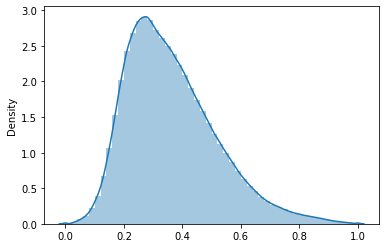

In [3]:
fig = sns.distplot(all_comp.flatten())

In [ ]:
fig.figure.savefig('array_dist.png')

And now we load the TensorFlow trained ADAGE model.

First train a keras model on this compendium.

In [8]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]
seq_temp = run_model.run_model('../data_files/refine_bio_seq_clean_with_names.csv',960,kl1=0, act = 'tanh', tied = True, epochs=1, init='glorot_normal')
arr_temp = run_model.run_model('../data_files/train_set_normalized.csv',960,kl1=0, act = 'tanh', tied = True, epochs=1, init='glorot_normal')
tf_adage = Adage.Adage(arr_temp.autoencoder, arr_temp.history, arr_temp.compendium)
tf_weights = np.array(pd.read_csv('../outputs/ADAGE_OG_weights.csv', header = None))
tf_cost = pd.read_csv('../outputs/ADAGE_OG_cost_log.csv')
tf_adage.weights = tf_weights
tf_adage.loss = tf_cost['cost']
tf_adage.set_hwg_cutoff(2.5).shape

test
tensorflow
(5210, 995)
float32
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               1563300   
_________________________________________________________________
tied_weights_encoder (TiedWe (None, 5210)              1563300   
Total params: 

/home/georgia/anaconda3/envs/tfk/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


test
tensorflow
(5549, 950)
float32
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               1665000   
_________________________________________________________________
tied_weights_encoder_1 (Tied (None, 5549)              1665000   
Total params: 1,665,000
Trainable params: 1,665,000
Non-trainable params: 0
_________________________________________________________________
86/86 [==============================] - 2s 18ms/step - loss: 0.6961 - val_loss: 0.6954
(2,)


(5549, 600)

In [14]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict = {
    "tf_adage": tf_adage
}

for seed in range(2):
    for i in inits:
    #print(i)
        for l in L1_norm:
        #print(l)
            for a in act_fun:
            #print(a)
                for t in tied:
                    m = run_model.run_model('../data_files/train_set_normalized.csv',seed=seed+460,kl1=l, act = a, tied = t, epochs=500, init=i)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                    print(name)
                    model_dict[name] = m

test
tensorflow
(5549, 950)
float32
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 300)               1665000   
_________________________________________________________________
tied_weights_encoder_4 (Tied (None, 5549)              1665000   
Total params: 1,665,000
Trainable params: 1,665,000
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
86/86 [==============================] - 2s 15ms/step - loss: 0.6964 - val_loss: 0.6960
Epoch 2/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6960 - val_loss: 0.6956
Epoch 3/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6955 - val_loss: 0.6952
Epoch 4/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6951 - val_loss: 0.6947
Epoch 5/500
86/86 [==============================] - 1s 11ms/step - lo

86/86 [==============================] - 1s 13ms/step - loss: 0.6625 - val_loss: 0.6623
Epoch 156/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6627 - val_loss: 0.6622
Epoch 157/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6620 - val_loss: 0.6620
Epoch 158/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6627 - val_loss: 0.6618
Epoch 159/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6623 - val_loss: 0.6616
Epoch 160/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6618 - val_loss: 0.6615
Epoch 161/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6621 - val_loss: 0.6613
Epoch 162/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6624 - val_loss: 0.6611
Epoch 163/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6609 - val_loss: 0.6610
Epoch 164/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6613 - val_loss: 0

86/86 [==============================] - 1s 11ms/step - loss: 0.6462 - val_loss: 0.6462
Epoch 316/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6457 - val_loss: 0.6462
Epoch 317/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6461 - val_loss: 0.6461
Epoch 318/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6474 - val_loss: 0.6461
Epoch 319/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6458 - val_loss: 0.6460
Epoch 320/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6465 - val_loss: 0.6460
Epoch 321/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6472 - val_loss: 0.6459
Epoch 322/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6458 - val_loss: 0.6459
Epoch 323/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6447 - val_loss: 0.6458
Epoch 324/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6463 - val_loss: 0

86/86 [==============================] - 1s 11ms/step - loss: 0.6420 - val_loss: 0.6414
Epoch 476/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6401 - val_loss: 0.6414
Epoch 477/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6419 - val_loss: 0.6414
Epoch 478/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6409 - val_loss: 0.6414
Epoch 479/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6427 - val_loss: 0.6414
Epoch 480/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6412 - val_loss: 0.6413
Epoch 481/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6416 - val_loss: 0.6413
Epoch 482/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6415 - val_loss: 0.6413
Epoch 483/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6408 - val_loss: 0.6413
Epoch 484/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6422 - val_loss: 0

Epoch 48/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6808 - val_loss: 0.6805
Epoch 49/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6801 - val_loss: 0.6802
Epoch 50/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6798 - val_loss: 0.6799
Epoch 51/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6797 - val_loss: 0.6795
Epoch 52/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6795 - val_loss: 0.6792
Epoch 53/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6790 - val_loss: 0.6789
Epoch 54/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6788 - val_loss: 0.6786
Epoch 55/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6785 - val_loss: 0.6782
Epoch 56/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6784 - val_loss: 0.6779
Epoch 57/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6780 - val_los

Epoch 129/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6561 - val_loss: 0.6549
Epoch 130/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6550 - val_loss: 0.6546
Epoch 131/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6546 - val_loss: 0.6544
Epoch 132/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6542 - val_loss: 0.6541
Epoch 133/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6537 - val_loss: 0.6539
Epoch 134/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6546 - val_loss: 0.6537
Epoch 135/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6540 - val_loss: 0.6534
Epoch 136/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6534 - val_loss: 0.6532
Epoch 137/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6529 - val_loss: 0.6530
Epoch 138/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6528

86/86 [==============================] - 1s 11ms/step - loss: 0.6390 - val_loss: 0.6391
Epoch 290/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6397 - val_loss: 0.6391
Epoch 291/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6400 - val_loss: 0.6391
Epoch 292/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6377 - val_loss: 0.6391
Epoch 293/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6380 - val_loss: 0.6390
Epoch 294/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6391 - val_loss: 0.6390
Epoch 295/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6400 - val_loss: 0.6390
Epoch 296/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6395 - val_loss: 0.6390
Epoch 297/500
86/86 [==============================] - 1s 16ms/step - loss: 0.6380 - val_loss: 0.6390
Epoch 298/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6409 - val_loss: 0

86/86 [==============================] - 1s 11ms/step - loss: 0.6376 - val_loss: 0.6378
Epoch 450/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6377 - val_loss: 0.6378
Epoch 451/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6377 - val_loss: 0.6378
Epoch 452/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6383 - val_loss: 0.6378
Epoch 453/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6388 - val_loss: 0.6378
Epoch 454/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6376 - val_loss: 0.6378
Epoch 455/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6379 - val_loss: 0.6378
Epoch 456/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6373 - val_loss: 0.6378
Epoch 457/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6373 - val_loss: 0.6378
Epoch 458/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6400 - val_loss: 0

Epoch 23/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6883 - val_loss: 0.6881
Epoch 24/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6879 - val_loss: 0.6880
Epoch 25/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6879 - val_loss: 0.6878
Epoch 26/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6878 - val_loss: 0.6877
Epoch 27/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6877 - val_loss: 0.6875
Epoch 28/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6876 - val_loss: 0.6874
Epoch 29/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6873 - val_loss: 0.6872
Epoch 30/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6872 - val_loss: 0.6871
Epoch 31/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6870 - val_loss: 0.6869
Epoch 32/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6868 - val_los

86/86 [==============================] - 1s 12ms/step - loss: 0.6707 - val_loss: 0.6706
Epoch 105/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6705 - val_loss: 0.6704
Epoch 106/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6703 - val_loss: 0.6701
Epoch 107/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6700 - val_loss: 0.6699
Epoch 108/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6697 - val_loss: 0.6697
Epoch 109/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6690 - val_loss: 0.6695
Epoch 110/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6698 - val_loss: 0.6692
Epoch 111/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6682 - val_loss: 0.6690
Epoch 112/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6688 - val_loss: 0.6688
Epoch 113/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6690 - val_loss: 0

86/86 [==============================] - 1s 13ms/step - loss: 0.6508 - val_loss: 0.6508
Epoch 265/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6491 - val_loss: 0.6508
Epoch 266/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6517 - val_loss: 0.6507
Epoch 267/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6512 - val_loss: 0.6507
Epoch 268/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6512 - val_loss: 0.6506
Epoch 269/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6496 - val_loss: 0.6506
Epoch 270/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6536 - val_loss: 0.6505
Epoch 271/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6495 - val_loss: 0.6505
Epoch 272/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6518 - val_loss: 0.6504
Epoch 273/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6511 - val_loss: 0

86/86 [==============================] - 1s 12ms/step - loss: 0.6472 - val_loss: 0.6467
Epoch 425/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6460 - val_loss: 0.6467
Epoch 426/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6478 - val_loss: 0.6466
Epoch 427/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6464 - val_loss: 0.6466
Epoch 428/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6457 - val_loss: 0.6466
Epoch 429/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6457 - val_loss: 0.6466
Epoch 430/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6451 - val_loss: 0.6466
Epoch 431/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6449 - val_loss: 0.6466
Epoch 432/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6464 - val_loss: 0.6465
Epoch 433/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6467 - val_loss: 0

86/86 [==============================] - 2s 15ms/step - loss: 0.6963 - val_loss: 0.6958
Epoch 2/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6957 - val_loss: 0.6952
Epoch 3/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6951 - val_loss: 0.6947
Epoch 4/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6946 - val_loss: 0.6942
Epoch 5/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6940 - val_loss: 0.6937
Epoch 6/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6936 - val_loss: 0.6933
Epoch 7/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6932 - val_loss: 0.6928
Epoch 8/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6928 - val_loss: 0.6925
Epoch 9/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6923 - val_loss: 0.6921
Epoch 10/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6921 - val_loss: 0.6917
Epoch 11/50

86/86 [==============================] - 1s 11ms/step - loss: 0.6445 - val_loss: 0.6444
Epoch 163/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6439 - val_loss: 0.6443
Epoch 164/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6446 - val_loss: 0.6442
Epoch 165/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6434 - val_loss: 0.6441
Epoch 166/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6436 - val_loss: 0.6440
Epoch 167/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6446 - val_loss: 0.6439
Epoch 168/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6432 - val_loss: 0.6438
Epoch 169/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6425 - val_loss: 0.6437
Epoch 170/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6450 - val_loss: 0.6436
Epoch 171/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6442 - val_loss: 0

86/86 [==============================] - 1s 11ms/step - loss: 0.6380 - val_loss: 0.6378
Epoch 323/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6378 - val_loss: 0.6378
Epoch 324/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6377 - val_loss: 0.6377
Epoch 325/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6380 - val_loss: 0.6377
Epoch 326/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6367 - val_loss: 0.6377
Epoch 327/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6370 - val_loss: 0.6377
Epoch 328/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6370 - val_loss: 0.6377
Epoch 329/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6374 - val_loss: 0.6377
Epoch 330/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6366 - val_loss: 0.6377
Epoch 331/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6393 - val_loss: 0

86/86 [==============================] - 1s 11ms/step - loss: 0.6349 - val_loss: 0.6360
Epoch 483/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6364 - val_loss: 0.6360
Epoch 484/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6350 - val_loss: 0.6360
Epoch 485/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6353 - val_loss: 0.6360
Epoch 486/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6360 - val_loss: 0.6360
Epoch 487/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6357 - val_loss: 0.6359
Epoch 488/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6350 - val_loss: 0.6359
Epoch 489/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6363 - val_loss: 0.6359
Epoch 490/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6363 - val_loss: 0.6359
Epoch 491/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6364 - val_loss: 0

Epoch 137/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6522 - val_loss: 0.6519
Epoch 138/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6501 - val_loss: 0.6518
Epoch 139/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6516 - val_loss: 0.6516
Epoch 140/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6534 - val_loss: 0.6515
Epoch 141/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6517 - val_loss: 0.6513
Epoch 142/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6515 - val_loss: 0.6512
Epoch 143/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6506 - val_loss: 0.6511
Epoch 144/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6518 - val_loss: 0.6509
Epoch 145/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6500 - val_loss: 0.6508
Epoch 146/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6509

86/86 [==============================] - 1s 14ms/step - loss: 0.6444 - val_loss: 0.6439
Epoch 298/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6455 - val_loss: 0.6439
Epoch 299/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6447 - val_loss: 0.6438
Epoch 300/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6449 - val_loss: 0.6438
Epoch 301/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6424 - val_loss: 0.6438
Epoch 302/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6439 - val_loss: 0.6438
Epoch 303/500
86/86 [==============================] - 1s 17ms/step - loss: 0.6424 - val_loss: 0.6437
Epoch 304/500
86/86 [==============================] - 1s 17ms/step - loss: 0.6428 - val_loss: 0.6437
Epoch 305/500
86/86 [==============================] - 1s 16ms/step - loss: 0.6438 - val_loss: 0.6437
Epoch 306/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6427 - val_loss: 0

86/86 [==============================] - 1s 13ms/step - loss: 0.6385 - val_loss: 0.6403
Epoch 458/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6422 - val_loss: 0.6403
Epoch 459/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6394 - val_loss: 0.6402
Epoch 460/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6403 - val_loss: 0.6402
Epoch 461/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6373 - val_loss: 0.6402
Epoch 462/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6392 - val_loss: 0.6402
Epoch 463/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6394 - val_loss: 0.6402
Epoch 464/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6386 - val_loss: 0.6401
Epoch 465/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6402 - val_loss: 0.6401
Epoch 466/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6387 - val_loss: 0

86/86 [==============================] - 1s 11ms/step - loss: 0.6387 - val_loss: 0.6385
Epoch 111/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6380 - val_loss: 0.6384
Epoch 112/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6378 - val_loss: 0.6382
Epoch 113/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6370 - val_loss: 0.6381
Epoch 114/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6371 - val_loss: 0.6380
Epoch 115/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6368 - val_loss: 0.6379
Epoch 116/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6368 - val_loss: 0.6378
Epoch 117/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6378 - val_loss: 0.6377
Epoch 118/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6360 - val_loss: 0.6376
Epoch 119/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6366 - val_loss: 0

86/86 [==============================] - 1s 11ms/step - loss: 0.6334 - val_loss: 0.6347
Epoch 271/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6320 - val_loss: 0.6347
Epoch 272/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6337 - val_loss: 0.6346
Epoch 273/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6346 - val_loss: 0.6346
Epoch 274/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6353 - val_loss: 0.6346
Epoch 275/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6354 - val_loss: 0.6346
Epoch 276/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6355 - val_loss: 0.6346
Epoch 277/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6329 - val_loss: 0.6346
Epoch 278/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6363 - val_loss: 0.6346
Epoch 279/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6337 - val_loss: 0

86/86 [==============================] - 1s 11ms/step - loss: 0.6321 - val_loss: 0.6330
Epoch 431/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6321 - val_loss: 0.6330
Epoch 432/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6320 - val_loss: 0.6330
Epoch 433/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6322 - val_loss: 0.6330
Epoch 434/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6337 - val_loss: 0.6330
Epoch 435/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6319 - val_loss: 0.6330
Epoch 436/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6325 - val_loss: 0.6330
Epoch 437/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6347 - val_loss: 0.6329
Epoch 438/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6311 - val_loss: 0.6329
Epoch 439/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6329 - val_loss: 0

86/86 [==============================] - 1s 16ms/step - loss: 0.9323 - val_loss: 0.9319
Epoch 85/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9316 - val_loss: 0.9316
Epoch 86/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9320 - val_loss: 0.9313
Epoch 87/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9316 - val_loss: 0.9309
Epoch 88/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9308 - val_loss: 0.9306
Epoch 89/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9306 - val_loss: 0.9302
Epoch 90/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9302 - val_loss: 0.9299
Epoch 91/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9300 - val_loss: 0.9296
Epoch 92/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9294 - val_loss: 0.9292
Epoch 93/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9294 - val_loss: 0.9289
Epo

86/86 [==============================] - 2s 21ms/step - loss: 0.8873 - val_loss: 0.8864
Epoch 245/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8859 - val_loss: 0.8861
Epoch 246/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8868 - val_loss: 0.8859
Epoch 247/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8864 - val_loss: 0.8857
Epoch 248/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8865 - val_loss: 0.8855
Epoch 249/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8856 - val_loss: 0.8853
Epoch 250/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8855 - val_loss: 0.8851
Epoch 251/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8855 - val_loss: 0.8849
Epoch 252/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8845 - val_loss: 0.8847
Epoch 253/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8848 - val_loss: 0

86/86 [==============================] - 2s 18ms/step - loss: 0.8599 - val_loss: 0.8588
Epoch 405/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8575 - val_loss: 0.8587
Epoch 406/500
86/86 [==============================] - 2s 17ms/step - loss: 0.8583 - val_loss: 0.8585
Epoch 407/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8575 - val_loss: 0.8584
Epoch 408/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8596 - val_loss: 0.8582
Epoch 409/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8596 - val_loss: 0.8581
Epoch 410/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8581 - val_loss: 0.8579
Epoch 411/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8577 - val_loss: 0.8578
Epoch 412/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8560 - val_loss: 0.8576
Epoch 413/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8578 - val_loss: 0

Epoch 57/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9380 - val_loss: 0.9377
Epoch 58/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9376 - val_loss: 0.9373
Epoch 59/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9373 - val_loss: 0.9368
Epoch 60/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9368 - val_loss: 0.9363
Epoch 61/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9361 - val_loss: 0.9359
Epoch 62/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9357 - val_loss: 0.9354
Epoch 63/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9356 - val_loss: 0.9350
Epoch 64/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9351 - val_loss: 0.9345
Epoch 65/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9342 - val_loss: 0.9340
Epoch 66/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9337 - val_los

86/86 [==============================] - 1s 17ms/step - loss: 0.8793 - val_loss: 0.8795
Epoch 218/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8795 - val_loss: 0.8792
Epoch 219/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8778 - val_loss: 0.8790
Epoch 220/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8788 - val_loss: 0.8788
Epoch 221/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8788 - val_loss: 0.8786
Epoch 222/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8798 - val_loss: 0.8784
Epoch 223/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8790 - val_loss: 0.8782
Epoch 224/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8786 - val_loss: 0.8780
Epoch 225/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8774 - val_loss: 0.8778
Epoch 226/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8762 - val_loss: 0

86/86 [==============================] - 2s 18ms/step - loss: 0.8553 - val_loss: 0.8539
Epoch 378/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8522 - val_loss: 0.8538
Epoch 379/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8537 - val_loss: 0.8537
Epoch 380/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8556 - val_loss: 0.8535
Epoch 381/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8532 - val_loss: 0.8534
Epoch 382/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8539 - val_loss: 0.8533
Epoch 383/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8521 - val_loss: 0.8531
Epoch 384/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8540 - val_loss: 0.8530
Epoch 385/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8535 - val_loss: 0.8529
Epoch 386/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8538 - val_loss: 0

Epoch 31/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9495 - val_loss: 0.9491
Epoch 32/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9489 - val_loss: 0.9488
Epoch 33/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9488 - val_loss: 0.9485
Epoch 34/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9482 - val_loss: 0.9482
Epoch 35/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9482 - val_loss: 0.9479
Epoch 36/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9476 - val_loss: 0.9475
Epoch 37/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9474 - val_loss: 0.9472
Epoch 38/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9473 - val_loss: 0.9469
Epoch 39/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9471 - val_loss: 0.9466
Epoch 40/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9466 - val_los

Epoch 112/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9210 - val_loss: 0.9200
Epoch 113/500
86/86 [==============================] - 2s 19ms/step - loss: 0.9198 - val_loss: 0.9197
Epoch 114/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9199 - val_loss: 0.9193
Epoch 115/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9198 - val_loss: 0.9190
Epoch 116/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9187 - val_loss: 0.9186
Epoch 117/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9181 - val_loss: 0.9183
Epoch 118/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9179 - val_loss: 0.9179
Epoch 119/500
86/86 [==============================] - 2s 23ms/step - loss: 0.9178 - val_loss: 0.9176
Epoch 120/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9177 - val_loss: 0.9173
Epoch 121/500
86/86 [==============================] - 2s 21ms/step - loss: 0.9169

86/86 [==============================] - 1s 17ms/step - loss: 0.8824 - val_loss: 0.8817
Epoch 273/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8804 - val_loss: 0.8815
Epoch 274/500
86/86 [==============================] - 2s 23ms/step - loss: 0.8799 - val_loss: 0.8814
Epoch 275/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8817 - val_loss: 0.8812
Epoch 276/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8795 - val_loss: 0.8810
Epoch 277/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8821 - val_loss: 0.8809
Epoch 278/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8813 - val_loss: 0.8807
Epoch 279/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8811 - val_loss: 0.8805
Epoch 280/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8808 - val_loss: 0.8804
Epoch 281/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8809 - val_loss: 0

86/86 [==============================] - 2s 20ms/step - loss: 0.8592 - val_loss: 0.8581
Epoch 433/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8582 - val_loss: 0.8580
Epoch 434/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8576 - val_loss: 0.8579
Epoch 435/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8583 - val_loss: 0.8577
Epoch 436/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8580 - val_loss: 0.8576
Epoch 437/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8551 - val_loss: 0.8575
Epoch 438/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8594 - val_loss: 0.8573
Epoch 439/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8574 - val_loss: 0.8572
Epoch 440/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8574 - val_loss: 0.8571
Epoch 441/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8569 - val_loss: 0

86/86 [==============================] - 1s 17ms/step - loss: 0.9160 - val_loss: 0.9156
Epoch 86/500
86/86 [==============================] - 2s 19ms/step - loss: 0.9158 - val_loss: 0.9150
Epoch 87/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9136 - val_loss: 0.9145
Epoch 88/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9148 - val_loss: 0.9141
Epoch 89/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9132 - val_loss: 0.9136
Epoch 90/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9135 - val_loss: 0.9131
Epoch 91/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9128 - val_loss: 0.9126
Epoch 92/500
86/86 [==============================] - 2s 19ms/step - loss: 0.9125 - val_loss: 0.9121
Epoch 93/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9116 - val_loss: 0.9116
Epoch 94/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9114 - val_loss: 0.9112
Epo

86/86 [==============================] - 2s 18ms/step - loss: 0.8718 - val_loss: 0.8721
Epoch 246/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8730 - val_loss: 0.8720
Epoch 247/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8714 - val_loss: 0.8718
Epoch 248/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8716 - val_loss: 0.8716
Epoch 249/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8722 - val_loss: 0.8715
Epoch 250/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8713 - val_loss: 0.8713
Epoch 251/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8708 - val_loss: 0.8712
Epoch 252/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8717 - val_loss: 0.8710
Epoch 253/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8718 - val_loss: 0.8708
Epoch 254/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8706 - val_loss: 0

86/86 [==============================] - 2s 18ms/step - loss: 0.8498 - val_loss: 0.8492
Epoch 406/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8502 - val_loss: 0.8491
Epoch 407/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8473 - val_loss: 0.8489
Epoch 408/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8499 - val_loss: 0.8488
Epoch 409/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8479 - val_loss: 0.8486
Epoch 410/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8502 - val_loss: 0.8485
Epoch 411/500
86/86 [==============================] - 2s 17ms/step - loss: 0.8491 - val_loss: 0.8484
Epoch 412/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8467 - val_loss: 0.8482
Epoch 413/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8481 - val_loss: 0.8481
Epoch 414/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8506 - val_loss: 0

86/86 [==============================] - 2s 18ms/step - loss: 0.9401 - val_loss: 0.9392
Epoch 60/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9387 - val_loss: 0.9387
Epoch 61/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9384 - val_loss: 0.9381
Epoch 62/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9377 - val_loss: 0.9376
Epoch 63/500
86/86 [==============================] - 2s 19ms/step - loss: 0.9376 - val_loss: 0.9370
Epoch 64/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9366 - val_loss: 0.9364
Epoch 65/500
86/86 [==============================] - 2s 19ms/step - loss: 0.9363 - val_loss: 0.9358
Epoch 66/500
86/86 [==============================] - 2s 19ms/step - loss: 0.9360 - val_loss: 0.9352
Epoch 67/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9354 - val_loss: 0.9346
Epoch 68/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9346 - val_loss: 0.9340
Epo

Epoch 140/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8988 - val_loss: 0.8994
Epoch 141/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8982 - val_loss: 0.8991
Epoch 142/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8994 - val_loss: 0.8989
Epoch 143/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8967 - val_loss: 0.8986
Epoch 144/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8991 - val_loss: 0.8983
Epoch 145/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8982 - val_loss: 0.8980
Epoch 146/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8965 - val_loss: 0.8978
Epoch 147/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8981 - val_loss: 0.8975
Epoch 148/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8976 - val_loss: 0.8973
Epoch 149/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8979

86/86 [==============================] - 1s 16ms/step - loss: 0.8709 - val_loss: 0.8709
Epoch 301/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8707 - val_loss: 0.8708
Epoch 302/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8692 - val_loss: 0.8706
Epoch 303/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8698 - val_loss: 0.8705
Epoch 304/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8677 - val_loss: 0.8703
Epoch 305/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8718 - val_loss: 0.8702
Epoch 306/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8685 - val_loss: 0.8700
Epoch 307/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8687 - val_loss: 0.8699
Epoch 308/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8685 - val_loss: 0.8697
Epoch 309/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8695 - val_loss: 0

86/86 [==============================] - 1s 17ms/step - loss: 0.8451 - val_loss: 0.8478
Epoch 461/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8480 - val_loss: 0.8477
Epoch 462/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8458 - val_loss: 0.8475
Epoch 463/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8479 - val_loss: 0.8474
Epoch 464/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8473 - val_loss: 0.8472
Epoch 465/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8481 - val_loss: 0.8471
Epoch 466/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8450 - val_loss: 0.8470
Epoch 467/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8472 - val_loss: 0.8468
Epoch 468/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8458 - val_loss: 0.8467
Epoch 469/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8447 - val_loss: 0

86/86 [==============================] - 1s 16ms/step - loss: 0.8904 - val_loss: 0.8883
Epoch 114/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8879 - val_loss: 0.8881
Epoch 115/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8891 - val_loss: 0.8879
Epoch 116/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8870 - val_loss: 0.8877
Epoch 117/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8868 - val_loss: 0.8875
Epoch 118/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8889 - val_loss: 0.8873
Epoch 119/500
86/86 [==============================] - 2s 17ms/step - loss: 0.8869 - val_loss: 0.8871
Epoch 120/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8864 - val_loss: 0.8869
Epoch 121/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8859 - val_loss: 0.8867
Epoch 122/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8857 - val_loss: 0

86/86 [==============================] - 1s 16ms/step - loss: 0.8626 - val_loss: 0.8637
Epoch 274/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8637 - val_loss: 0.8636
Epoch 275/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8619 - val_loss: 0.8635
Epoch 276/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8642 - val_loss: 0.8633
Epoch 277/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8622 - val_loss: 0.8632
Epoch 278/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8632 - val_loss: 0.8630
Epoch 279/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8627 - val_loss: 0.8629
Epoch 280/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8621 - val_loss: 0.8627
Epoch 281/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8630 - val_loss: 0.8626
Epoch 282/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8608 - val_loss: 0

86/86 [==============================] - 1s 17ms/step - loss: 0.8418 - val_loss: 0.8415
Epoch 434/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8420 - val_loss: 0.8414
Epoch 435/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8410 - val_loss: 0.8413
Epoch 436/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8408 - val_loss: 0.8411
Epoch 437/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8396 - val_loss: 0.8410
Epoch 438/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8415 - val_loss: 0.8408
Epoch 439/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8401 - val_loss: 0.8407
Epoch 440/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8398 - val_loss: 0.8406
Epoch 441/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8403 - val_loss: 0.8404
Epoch 442/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8376 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.6764 - val_loss: 0.6765
Epoch 88/500
86/86 [==============================] - 1s 16ms/step - loss: 0.6763 - val_loss: 0.6763
Epoch 89/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6764 - val_loss: 0.6761
Epoch 90/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6763 - val_loss: 0.6758
Epoch 91/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6758 - val_loss: 0.6756
Epoch 92/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6756 - val_loss: 0.6754
Epoch 93/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6750 - val_loss: 0.6752
Epoch 94/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6750 - val_loss: 0.6750
Epoch 95/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6749 - val_loss: 0.6748
Epoch 96/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6749 - val_loss: 0.6746
Epo

86/86 [==============================] - 1s 10ms/step - loss: 0.6499 - val_loss: 0.6510
Epoch 248/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6506 - val_loss: 0.6510
Epoch 249/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6512 - val_loss: 0.6509
Epoch 250/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6511 - val_loss: 0.6508
Epoch 251/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6515 - val_loss: 0.6507
Epoch 252/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6509 - val_loss: 0.6506
Epoch 253/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6515 - val_loss: 0.6505
Epoch 254/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6506 - val_loss: 0.6504
Epoch 255/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6513 - val_loss: 0.6504
Epoch 256/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6517 - val_loss: 0.

86/86 [==============================] - 1s 10ms/step - loss: 0.6415 - val_loss: 0.6430
Epoch 408/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6430 - val_loss: 0.6430
Epoch 409/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6421 - val_loss: 0.6429
Epoch 410/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6429 - val_loss: 0.6429
Epoch 411/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6444 - val_loss: 0.6429
Epoch 412/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6426 - val_loss: 0.6429
Epoch 413/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6444 - val_loss: 0.6428
Epoch 414/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6434 - val_loss: 0.6428
Epoch 415/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6426 - val_loss: 0.6428
Epoch 416/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6420 - val_loss: 0.

86/86 [==============================] - 1s 10ms/step - loss: 0.6776 - val_loss: 0.6775
Epoch 61/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6775 - val_loss: 0.6772
Epoch 62/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6770 - val_loss: 0.6769
Epoch 63/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6766 - val_loss: 0.6766
Epoch 64/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6760 - val_loss: 0.6762
Epoch 65/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6763 - val_loss: 0.6759
Epoch 66/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6760 - val_loss: 0.6756
Epoch 67/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6752 - val_loss: 0.6753
Epoch 68/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6753 - val_loss: 0.6749
Epoch 69/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6747 - val_loss: 0.6746
Epoch 70

Epoch 222/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6422 - val_loss: 0.6422
Epoch 223/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6423 - val_loss: 0.6421
Epoch 224/500
86/86 [==============================] - 1s 8ms/step - loss: 0.6423 - val_loss: 0.6420
Epoch 225/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6421 - val_loss: 0.6420
Epoch 226/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6427 - val_loss: 0.6419
Epoch 227/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6405 - val_loss: 0.6418
Epoch 228/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6411 - val_loss: 0.6418
Epoch 229/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6427 - val_loss: 0.6417
Epoch 230/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6423 - val_loss: 0.6416
Epoch 231/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6423 - val_

Epoch 303/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6403 - val_loss: 0.6390
Epoch 304/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6398 - val_loss: 0.6390
Epoch 305/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6401 - val_loss: 0.6390
Epoch 306/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6401 - val_loss: 0.6389
Epoch 307/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6407 - val_loss: 0.6389
Epoch 308/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6391 - val_loss: 0.6389
Epoch 309/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6400 - val_loss: 0.6389
Epoch 310/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6389 - val_loss: 0.6389
Epoch 311/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6382 - val_loss: 0.6389
Epoch 312/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6390 - val_l

Epoch 384/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6374 - val_loss: 0.6381
Epoch 385/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6375 - val_loss: 0.6381
Epoch 386/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6385 - val_loss: 0.6381
Epoch 387/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6374 - val_loss: 0.6381
Epoch 388/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6360 - val_loss: 0.6381
Epoch 389/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6374 - val_loss: 0.6381
Epoch 390/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6362 - val_loss: 0.6381
Epoch 391/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6384 - val_loss: 0.6381
Epoch 392/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6368 - val_loss: 0.6381
Epoch 393/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6383 - va

Epoch 465/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6375 - val_loss: 0.6378
Epoch 466/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6372 - val_loss: 0.6378
Epoch 467/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6370 - val_loss: 0.6378
Epoch 468/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6370 - val_loss: 0.6378
Epoch 469/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6377 - val_loss: 0.6378
Epoch 470/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6386 - val_loss: 0.6378
Epoch 471/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6370 - val_loss: 0.6378
Epoch 472/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6370 - val_loss: 0.6378
Epoch 473/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6383 - val_loss: 0.6378
Epoch 474/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6387 - val

86/86 [==============================] - 1s 10ms/step - loss: 0.6674 - val_loss: 0.6675
Epoch 121/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6668 - val_loss: 0.6672
Epoch 122/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6672 - val_loss: 0.6670
Epoch 123/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6671 - val_loss: 0.6668
Epoch 124/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6675 - val_loss: 0.6666
Epoch 125/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6661 - val_loss: 0.6664
Epoch 126/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6662 - val_loss: 0.6662
Epoch 127/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6663 - val_loss: 0.6660
Epoch 128/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6660 - val_loss: 0.6658
Epoch 129/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6662 - val_loss: 0.

86/86 [==============================] - 1s 9ms/step - loss: 0.6514 - val_loss: 0.6501
Epoch 281/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6510 - val_loss: 0.6501
Epoch 282/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6513 - val_loss: 0.6501
Epoch 283/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6514 - val_loss: 0.6500
Epoch 284/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6514 - val_loss: 0.6500
Epoch 285/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6498 - val_loss: 0.6500
Epoch 286/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6499 - val_loss: 0.6499
Epoch 287/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6495 - val_loss: 0.6499
Epoch 288/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6503 - val_loss: 0.6498
Epoch 289/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6507 - val_loss: 0.6498

86/86 [==============================] - 1s 10ms/step - loss: 0.6461 - val_loss: 0.6466
Epoch 441/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6469 - val_loss: 0.6466
Epoch 442/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6481 - val_loss: 0.6465
Epoch 443/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6462 - val_loss: 0.6465
Epoch 444/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6461 - val_loss: 0.6465
Epoch 445/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6465 - val_loss: 0.6465
Epoch 446/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6470 - val_loss: 0.6465
Epoch 447/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6471 - val_loss: 0.6465
Epoch 448/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6463 - val_loss: 0.6464
Epoch 449/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6466 - val_loss: 0.6

86/86 [==============================] - 1s 9ms/step - loss: 0.6592 - val_loss: 0.6587
Epoch 94/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6593 - val_loss: 0.6584
Epoch 95/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6586 - val_loss: 0.6581
Epoch 96/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6580 - val_loss: 0.6577
Epoch 97/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6582 - val_loss: 0.6574
Epoch 98/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6571 - val_loss: 0.6571
Epoch 99/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6573 - val_loss: 0.6568
Epoch 100/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6573 - val_loss: 0.6564
Epoch 101/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6561 - val_loss: 0.6561
Epoch 102/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6559 - val_loss: 0.6558
Epoch

86/86 [==============================] - 1s 10ms/step - loss: 0.6426 - val_loss: 0.6429
Epoch 175/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6419 - val_loss: 0.6428
Epoch 176/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6430 - val_loss: 0.6427
Epoch 177/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6435 - val_loss: 0.6426
Epoch 178/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6419 - val_loss: 0.6425
Epoch 179/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6419 - val_loss: 0.6425
Epoch 180/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6432 - val_loss: 0.6424
Epoch 181/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6419 - val_loss: 0.6423
Epoch 182/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6422 - val_loss: 0.6422
Epoch 183/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6422 - val_loss: 0.642

Epoch 255/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6391 - val_loss: 0.6389
Epoch 256/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6378 - val_loss: 0.6389
Epoch 257/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6386 - val_loss: 0.6389
Epoch 258/500
86/86 [==============================] - 1s 8ms/step - loss: 0.6382 - val_loss: 0.6389
Epoch 259/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6386 - val_loss: 0.6388
Epoch 260/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6396 - val_loss: 0.6388
Epoch 261/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6395 - val_loss: 0.6388
Epoch 262/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6387 - val_loss: 0.6388
Epoch 263/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6384 - val_loss: 0.6388
Epoch 264/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6383 - val_lo

Epoch 336/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6374 - val_loss: 0.6377
Epoch 337/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6388 - val_loss: 0.6377
Epoch 338/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6381 - val_loss: 0.6377
Epoch 339/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6375 - val_loss: 0.6377
Epoch 340/500
86/86 [==============================] - 1s 8ms/step - loss: 0.6378 - val_loss: 0.6377
Epoch 341/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6390 - val_loss: 0.6377
Epoch 342/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6371 - val_loss: 0.6377
Epoch 343/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6384 - val_loss: 0.6376
Epoch 344/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6362 - val_loss: 0.6376
Epoch 345/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6361 - va

Epoch 417/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6387 - val_loss: 0.6369
Epoch 418/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6381 - val_loss: 0.6369
Epoch 419/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6373 - val_loss: 0.6369
Epoch 420/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6372 - val_loss: 0.6369
Epoch 421/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6371 - val_loss: 0.6369
Epoch 422/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6365 - val_loss: 0.6369
Epoch 423/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6373 - val_loss: 0.6369
Epoch 424/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6356 - val_loss: 0.6369
Epoch 425/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6366 - val_loss: 0.6369
Epoch 426/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6366 - val

Epoch 498/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6346 - val_loss: 0.6361
Epoch 499/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6378 - val_loss: 0.6361
Epoch 500/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6364 - val_loss: 0.6360
(4,)
ad_glorot_normal_0_tanh_tiedFalse
test
tensorflow
(5549, 950)
float32
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 300)               1665000   
_________________________________________________________________
tied_weights_encoder_12 (Tie (None, 5549)              1665000   
Total params: 1,665,000
Trainable params: 1,665,000
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
86/86 [==============================] - 2s 14ms/step - loss: 0.6949 - val_loss: 0.6943
Epoch 2/500
86/86 [=======

Epoch 153/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6514 - val_loss: 0.6498
Epoch 154/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6508 - val_loss: 0.6497
Epoch 155/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6482 - val_loss: 0.6496
Epoch 156/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6491 - val_loss: 0.6495
Epoch 157/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6483 - val_loss: 0.6494
Epoch 158/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6493 - val_loss: 0.6493
Epoch 159/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6498 - val_loss: 0.6492
Epoch 160/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6497 - val_loss: 0.6491
Epoch 161/500
86/86 [==============================] - 2s 18ms/step - loss: 0.6495 - val_loss: 0.6490
Epoch 162/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6479

86/86 [==============================] - 1s 12ms/step - loss: 0.6421 - val_loss: 0.6436
Epoch 314/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6449 - val_loss: 0.6436
Epoch 315/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6424 - val_loss: 0.6436
Epoch 316/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6449 - val_loss: 0.6436
Epoch 317/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6429 - val_loss: 0.6435
Epoch 318/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6440 - val_loss: 0.6435
Epoch 319/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6442 - val_loss: 0.6435
Epoch 320/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6433 - val_loss: 0.6435
Epoch 321/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6435 - val_loss: 0.6435
Epoch 322/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6435 - val_loss: 0.64

86/86 [==============================] - 1s 10ms/step - loss: 0.6389 - val_loss: 0.6401
Epoch 474/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6395 - val_loss: 0.6401
Epoch 475/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6393 - val_loss: 0.6401
Epoch 476/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6394 - val_loss: 0.6400
Epoch 477/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6425 - val_loss: 0.6400
Epoch 478/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6382 - val_loss: 0.6400
Epoch 479/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6382 - val_loss: 0.6400
Epoch 480/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6402 - val_loss: 0.6400
Epoch 481/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6399 - val_loss: 0.6399
Epoch 482/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6401 - val_loss: 0

86/86 [==============================] - 1s 9ms/step - loss: 0.6377 - val_loss: 0.6368
Epoch 128/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6371 - val_loss: 0.6368
Epoch 129/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6366 - val_loss: 0.6367
Epoch 130/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6361 - val_loss: 0.6367
Epoch 131/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6363 - val_loss: 0.6366
Epoch 132/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6368 - val_loss: 0.6366
Epoch 133/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6353 - val_loss: 0.6366
Epoch 134/500
86/86 [==============================] - 1s 8ms/step - loss: 0.6372 - val_loss: 0.6365
Epoch 135/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6367 - val_loss: 0.6365
Epoch 136/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6368 - val_loss: 0.6365
E

Epoch 208/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6356 - val_loss: 0.6353
Epoch 209/500
86/86 [==============================] - 1s 16ms/step - loss: 0.6342 - val_loss: 0.6353
Epoch 210/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6352 - val_loss: 0.6353
Epoch 211/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6354 - val_loss: 0.6353
Epoch 212/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6368 - val_loss: 0.6353
Epoch 213/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6374 - val_loss: 0.6353
Epoch 214/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6352 - val_loss: 0.6353
Epoch 215/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6351 - val_loss: 0.6353
Epoch 216/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6361 - val_loss: 0.6353
Epoch 217/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6355

86/86 [==============================] - 1s 11ms/step - loss: 0.6344 - val_loss: 0.6337
Epoch 369/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6319 - val_loss: 0.6337
Epoch 370/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6329 - val_loss: 0.6337
Epoch 371/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6340 - val_loss: 0.6337
Epoch 372/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6326 - val_loss: 0.6337
Epoch 373/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6352 - val_loss: 0.6336
Epoch 374/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6333 - val_loss: 0.6336
Epoch 375/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6348 - val_loss: 0.6336
Epoch 376/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6345 - val_loss: 0.6336
Epoch 377/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6319 - val_loss: 0

Epoch 22/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9392 - val_loss: 0.9389
Epoch 23/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9389 - val_loss: 0.9385
Epoch 24/500
86/86 [==============================] - 2s 20ms/step - loss: 0.9384 - val_loss: 0.9381
Epoch 25/500
86/86 [==============================] - 2s 20ms/step - loss: 0.9381 - val_loss: 0.9377
Epoch 26/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9376 - val_loss: 0.9373
Epoch 27/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9373 - val_loss: 0.9370
Epoch 28/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9368 - val_loss: 0.9366
Epoch 29/500
86/86 [==============================] - 2s 19ms/step - loss: 0.9364 - val_loss: 0.9362
Epoch 30/500
86/86 [==============================] - 2s 19ms/step - loss: 0.9361 - val_loss: 0.9359
Epoch 31/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9358 - val_los

86/86 [==============================] - 2s 17ms/step - loss: 0.9115 - val_loss: 0.9115
Epoch 104/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9114 - val_loss: 0.9111
Epoch 105/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9107 - val_loss: 0.9108
Epoch 106/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9105 - val_loss: 0.9105
Epoch 107/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9108 - val_loss: 0.9101
Epoch 108/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9104 - val_loss: 0.9098
Epoch 109/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9100 - val_loss: 0.9095
Epoch 110/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9101 - val_loss: 0.9091
Epoch 111/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9091 - val_loss: 0.9088
Epoch 112/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9087 - val_loss: 0

86/86 [==============================] - 1s 16ms/step - loss: 0.8720 - val_loss: 0.8699
Epoch 264/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8703 - val_loss: 0.8697
Epoch 265/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8703 - val_loss: 0.8695
Epoch 266/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8699 - val_loss: 0.8693
Epoch 267/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8700 - val_loss: 0.8691
Epoch 268/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8695 - val_loss: 0.8689
Epoch 269/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8679 - val_loss: 0.8687
Epoch 270/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8682 - val_loss: 0.8685
Epoch 271/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8687 - val_loss: 0.8684
Epoch 272/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8680 - val_loss: 0

86/86 [==============================] - 2s 18ms/step - loss: 0.8450 - val_loss: 0.8446
Epoch 424/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8438 - val_loss: 0.8444
Epoch 425/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8451 - val_loss: 0.8443
Epoch 426/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8445 - val_loss: 0.8442
Epoch 427/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8441 - val_loss: 0.8440
Epoch 428/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8446 - val_loss: 0.8439
Epoch 429/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8447 - val_loss: 0.8438
Epoch 430/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8442 - val_loss: 0.8436
Epoch 431/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8439 - val_loss: 0.8435
Epoch 432/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8430 - val_loss: 0

86/86 [==============================] - 2s 20ms/step - loss: 0.9495 - val_loss: 0.9490
Epoch 2/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9490 - val_loss: 0.9485
Epoch 3/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9484 - val_loss: 0.9480
Epoch 4/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9480 - val_loss: 0.9475
Epoch 5/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9474 - val_loss: 0.9470
Epoch 6/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9469 - val_loss: 0.9465
Epoch 7/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9464 - val_loss: 0.9460
Epoch 8/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9460 - val_loss: 0.9455
Epoch 9/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9455 - val_loss: 0.9451
Epoch 10/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9450 - val_loss: 0.9446
Epoch 11/50

86/86 [==============================] - 1s 15ms/step - loss: 0.8796 - val_loss: 0.8798
Epoch 163/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8799 - val_loss: 0.8795
Epoch 164/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8790 - val_loss: 0.8792
Epoch 165/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8785 - val_loss: 0.8789
Epoch 166/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8786 - val_loss: 0.8786
Epoch 167/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8784 - val_loss: 0.8783
Epoch 168/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8784 - val_loss: 0.8781
Epoch 169/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8788 - val_loss: 0.8778
Epoch 170/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8769 - val_loss: 0.8775
Epoch 171/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8765 - val_loss: 0

86/86 [==============================] - 1s 13ms/step - loss: 0.8488 - val_loss: 0.8487
Epoch 323/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8484 - val_loss: 0.8485
Epoch 324/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8475 - val_loss: 0.8484
Epoch 325/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8462 - val_loss: 0.8482
Epoch 326/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8489 - val_loss: 0.8481
Epoch 327/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8472 - val_loss: 0.8480
Epoch 328/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8468 - val_loss: 0.8478
Epoch 329/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8472 - val_loss: 0.8477
Epoch 330/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8461 - val_loss: 0.8475
Epoch 331/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8460 - val_loss: 0

86/86 [==============================] - 1s 15ms/step - loss: 0.8283 - val_loss: 0.8280
Epoch 483/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8292 - val_loss: 0.8279
Epoch 484/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8289 - val_loss: 0.8278
Epoch 485/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8274 - val_loss: 0.8276
Epoch 486/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8279 - val_loss: 0.8275
Epoch 487/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8276 - val_loss: 0.8274
Epoch 488/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8274 - val_loss: 0.8273
Epoch 489/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8270 - val_loss: 0.8272
Epoch 490/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8270 - val_loss: 0.8270
Epoch 491/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8258 - val_loss: 0

Epoch 137/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8979 - val_loss: 0.8979
Epoch 138/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8978 - val_loss: 0.8976
Epoch 139/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8972 - val_loss: 0.8973
Epoch 140/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8962 - val_loss: 0.8970
Epoch 141/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8971 - val_loss: 0.8967
Epoch 142/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8963 - val_loss: 0.8964
Epoch 143/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8969 - val_loss: 0.8961
Epoch 144/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8964 - val_loss: 0.8958
Epoch 145/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8954 - val_loss: 0.8955
Epoch 146/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8956

86/86 [==============================] - 1s 17ms/step - loss: 0.8647 - val_loss: 0.8647
Epoch 298/500
86/86 [==============================] - 2s 17ms/step - loss: 0.8650 - val_loss: 0.8645
Epoch 299/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8667 - val_loss: 0.8644
Epoch 300/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8642 - val_loss: 0.8642
Epoch 301/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8642 - val_loss: 0.8640
Epoch 302/500
86/86 [==============================] - 2s 23ms/step - loss: 0.8650 - val_loss: 0.8639
Epoch 303/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8632 - val_loss: 0.8637
Epoch 304/500
86/86 [==============================] - 2s 23ms/step - loss: 0.8662 - val_loss: 0.8636
Epoch 305/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8626 - val_loss: 0.8634
Epoch 306/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8626 - val_loss: 0

86/86 [==============================] - 2s 18ms/step - loss: 0.8434 - val_loss: 0.8427
Epoch 458/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8451 - val_loss: 0.8426
Epoch 459/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8430 - val_loss: 0.8425
Epoch 460/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8422 - val_loss: 0.8424
Epoch 461/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8415 - val_loss: 0.8422
Epoch 462/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8413 - val_loss: 0.8421
Epoch 463/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8428 - val_loss: 0.8420
Epoch 464/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8429 - val_loss: 0.8418
Epoch 465/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8425 - val_loss: 0.8417
Epoch 466/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8408 - val_loss: 0

86/86 [==============================] - 2s 18ms/step - loss: 0.8918 - val_loss: 0.8914
Epoch 111/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8915 - val_loss: 0.8910
Epoch 112/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8916 - val_loss: 0.8906
Epoch 113/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8903 - val_loss: 0.8902
Epoch 114/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8901 - val_loss: 0.8898
Epoch 115/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8899 - val_loss: 0.8894
Epoch 116/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8893 - val_loss: 0.8890
Epoch 117/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8893 - val_loss: 0.8887
Epoch 118/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8894 - val_loss: 0.8883
Epoch 119/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8880 - val_loss: 0

86/86 [==============================] - 2s 18ms/step - loss: 0.8545 - val_loss: 0.8549
Epoch 271/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8547 - val_loss: 0.8548
Epoch 272/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8533 - val_loss: 0.8546
Epoch 273/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8551 - val_loss: 0.8545
Epoch 274/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8536 - val_loss: 0.8543
Epoch 275/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8539 - val_loss: 0.8542
Epoch 276/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8537 - val_loss: 0.8540
Epoch 277/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8531 - val_loss: 0.8539
Epoch 278/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8544 - val_loss: 0.8537
Epoch 279/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8541 - val_loss: 0

86/86 [==============================] - 1s 17ms/step - loss: 0.8324 - val_loss: 0.8329
Epoch 431/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8352 - val_loss: 0.8327
Epoch 432/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8327 - val_loss: 0.8326
Epoch 433/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8323 - val_loss: 0.8325
Epoch 434/500
86/86 [==============================] - 2s 20ms/step - loss: 0.8316 - val_loss: 0.8323
Epoch 435/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8309 - val_loss: 0.8322
Epoch 436/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8330 - val_loss: 0.8321
Epoch 437/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8324 - val_loss: 0.8319
Epoch 438/500
86/86 [==============================] - 2s 17ms/step - loss: 0.8322 - val_loss: 0.8318
Epoch 439/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8314 - val_loss: 0

86/86 [==============================] - 1s 17ms/step - loss: 0.9112 - val_loss: 0.9108
Epoch 85/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9109 - val_loss: 0.9102
Epoch 86/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9095 - val_loss: 0.9096
Epoch 87/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9100 - val_loss: 0.9090
Epoch 88/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9100 - val_loss: 0.9084
Epoch 89/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9092 - val_loss: 0.9079
Epoch 90/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9089 - val_loss: 0.9073
Epoch 91/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9082 - val_loss: 0.9067
Epoch 92/500
86/86 [==============================] - 2s 19ms/step - loss: 0.9058 - val_loss: 0.9061
Epoch 93/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9067 - val_loss: 0.9056
Epo

86/86 [==============================] - 2s 18ms/step - loss: 0.8649 - val_loss: 0.8666
Epoch 245/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8650 - val_loss: 0.8664
Epoch 246/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8663 - val_loss: 0.8663
Epoch 247/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8668 - val_loss: 0.8661
Epoch 248/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8657 - val_loss: 0.8660
Epoch 249/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8663 - val_loss: 0.8658
Epoch 250/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8667 - val_loss: 0.8657
Epoch 251/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8656 - val_loss: 0.8655
Epoch 252/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8640 - val_loss: 0.8654
Epoch 253/500
86/86 [==============================] - 2s 25ms/step - loss: 0.8645 - val_loss: 0

86/86 [==============================] - 2s 19ms/step - loss: 0.8427 - val_loss: 0.8439
Epoch 405/500
86/86 [==============================] - 2s 26ms/step - loss: 0.8458 - val_loss: 0.8438
Epoch 406/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8427 - val_loss: 0.8436
Epoch 407/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8444 - val_loss: 0.8435
Epoch 408/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8439 - val_loss: 0.8434
Epoch 409/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8432 - val_loss: 0.8432
Epoch 410/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8413 - val_loss: 0.8431
Epoch 411/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8415 - val_loss: 0.8430
Epoch 412/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8429 - val_loss: 0.8428
Epoch 413/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8421 - val_loss: 0

Epoch 57/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9121 - val_loss: 0.9117
Epoch 58/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9114 - val_loss: 0.9105
Epoch 59/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9101 - val_loss: 0.9094
Epoch 60/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9089 - val_loss: 0.9083
Epoch 61/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9079 - val_loss: 0.9072
Epoch 62/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9064 - val_loss: 0.9060
Epoch 63/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9057 - val_loss: 0.9049
Epoch 64/500
86/86 [==============================] - 2s 17ms/step - loss: 0.9050 - val_loss: 0.9038
Epoch 65/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9028 - val_loss: 0.9027
Epoch 66/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9028 - val_los

86/86 [==============================] - 1s 15ms/step - loss: 0.8574 - val_loss: 0.8586
Epoch 218/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8564 - val_loss: 0.8584
Epoch 219/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8581 - val_loss: 0.8583
Epoch 220/500
86/86 [==============================] - 2s 22ms/step - loss: 0.8594 - val_loss: 0.8581
Epoch 221/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8596 - val_loss: 0.8580
Epoch 222/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8573 - val_loss: 0.8578
Epoch 223/500
86/86 [==============================] - 2s 21ms/step - loss: 0.8575 - val_loss: 0.8577
Epoch 224/500
86/86 [==============================] - 2s 18ms/step - loss: 0.8568 - val_loss: 0.8576
Epoch 225/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8566 - val_loss: 0.8574
Epoch 226/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8581 - val_loss: 0

86/86 [==============================] - 1s 15ms/step - loss: 0.8365 - val_loss: 0.8366
Epoch 378/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8370 - val_loss: 0.8365
Epoch 379/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8364 - val_loss: 0.8363
Epoch 380/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8356 - val_loss: 0.8362
Epoch 381/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8367 - val_loss: 0.8361
Epoch 382/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8351 - val_loss: 0.8359
Epoch 383/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8350 - val_loss: 0.8358
Epoch 384/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8374 - val_loss: 0.8357
Epoch 385/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8349 - val_loss: 0.8355
Epoch 386/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8356 - val_loss: 0

Epoch 31/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6878 - val_loss: 0.6875
Epoch 32/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6876 - val_loss: 0.6873
Epoch 33/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6873 - val_loss: 0.6871
Epoch 34/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6871 - val_loss: 0.6869
Epoch 35/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6867 - val_loss: 0.6867
Epoch 36/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6868 - val_loss: 0.6865
Epoch 37/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6864 - val_loss: 0.6863
Epoch 38/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6864 - val_loss: 0.6861
Epoch 39/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6861 - val_loss: 0.6859
Epoch 40/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6858 - val_los

86/86 [==============================] - 1s 10ms/step - loss: 0.6719 - val_loss: 0.6712
Epoch 113/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6718 - val_loss: 0.6709
Epoch 114/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6716 - val_loss: 0.6707
Epoch 115/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6716 - val_loss: 0.6705
Epoch 116/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6709 - val_loss: 0.6703
Epoch 117/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6708 - val_loss: 0.6701
Epoch 118/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6705 - val_loss: 0.6699
Epoch 119/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6702 - val_loss: 0.6697
Epoch 120/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6699 - val_loss: 0.6694
Epoch 121/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6701 - val_loss: 0

86/86 [==============================] - 1s 12ms/step - loss: 0.6488 - val_loss: 0.6481
Epoch 273/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6483 - val_loss: 0.6480
Epoch 274/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6493 - val_loss: 0.6480
Epoch 275/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6483 - val_loss: 0.6479
Epoch 276/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6487 - val_loss: 0.6478
Epoch 277/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6501 - val_loss: 0.6477
Epoch 278/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6503 - val_loss: 0.6477
Epoch 279/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6482 - val_loss: 0.6476
Epoch 280/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6485 - val_loss: 0.6475
Epoch 281/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6498 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.6413 - val_loss: 0.6411
Epoch 433/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6426 - val_loss: 0.6410
Epoch 434/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6420 - val_loss: 0.6410
Epoch 435/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6426 - val_loss: 0.6410
Epoch 436/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6433 - val_loss: 0.6410
Epoch 437/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6433 - val_loss: 0.6410
Epoch 438/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6408 - val_loss: 0.6409
Epoch 439/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6440 - val_loss: 0.6409
Epoch 440/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6434 - val_loss: 0.6409
Epoch 441/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6426 - val_loss: 0

86/86 [==============================] - 1s 13ms/step - loss: 0.6698 - val_loss: 0.6691
Epoch 86/500
86/86 [==============================] - 2s 19ms/step - loss: 0.6693 - val_loss: 0.6687
Epoch 87/500
86/86 [==============================] - 1s 17ms/step - loss: 0.6687 - val_loss: 0.6684
Epoch 88/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6693 - val_loss: 0.6680
Epoch 89/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6682 - val_loss: 0.6677
Epoch 90/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6682 - val_loss: 0.6673
Epoch 91/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6679 - val_loss: 0.6670
Epoch 92/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6674 - val_loss: 0.6667
Epoch 93/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6672 - val_loss: 0.6663
Epoch 94/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6664 - val_loss: 0.6660
Epo

86/86 [==============================] - 1s 12ms/step - loss: 0.6405 - val_loss: 0.6398
Epoch 246/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6408 - val_loss: 0.6397
Epoch 247/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6403 - val_loss: 0.6397
Epoch 248/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6414 - val_loss: 0.6396
Epoch 249/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6404 - val_loss: 0.6396
Epoch 250/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6415 - val_loss: 0.6395
Epoch 251/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6402 - val_loss: 0.6395
Epoch 252/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6414 - val_loss: 0.6395
Epoch 253/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6398 - val_loss: 0.6394
Epoch 254/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6406 - val_loss: 0

86/86 [==============================] - 1s 12ms/step - loss: 0.6389 - val_loss: 0.6370
Epoch 406/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6374 - val_loss: 0.6370
Epoch 407/500
86/86 [==============================] - ETA: 0s - loss: 0.638 - 1s 11ms/step - loss: 0.6380 - val_loss: 0.6370
Epoch 408/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6382 - val_loss: 0.6370
Epoch 409/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6387 - val_loss: 0.6370
Epoch 410/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6381 - val_loss: 0.6369
Epoch 411/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6408 - val_loss: 0.6369
Epoch 412/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6387 - val_loss: 0.6369
Epoch 413/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6372 - val_loss: 0.6369
Epoch 414/500
86/86 [==============================] - 1s 12ms/step - lo

86/86 [==============================] - 1s 15ms/step - loss: 0.6816 - val_loss: 0.6811
Epoch 60/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6818 - val_loss: 0.6808
Epoch 61/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6812 - val_loss: 0.6806
Epoch 62/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6808 - val_loss: 0.6804
Epoch 63/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6807 - val_loss: 0.6801
Epoch 64/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6802 - val_loss: 0.6799
Epoch 65/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6803 - val_loss: 0.6796
Epoch 66/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6798 - val_loss: 0.6794
Epoch 67/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6795 - val_loss: 0.6791
Epoch 68/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6797 - val_loss: 0.6789
Epo

Epoch 140/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6627 - val_loss: 0.6619
Epoch 141/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6636 - val_loss: 0.6618
Epoch 142/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6624 - val_loss: 0.6616
Epoch 143/500
86/86 [==============================] - 1s 17ms/step - loss: 0.6628 - val_loss: 0.6614
Epoch 144/500
86/86 [==============================] - 2s 20ms/step - loss: 0.6629 - val_loss: 0.6612
Epoch 145/500
86/86 [==============================] - 1s 17ms/step - loss: 0.6609 - val_loss: 0.6610
Epoch 146/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6615 - val_loss: 0.6609
Epoch 147/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6618 - val_loss: 0.6607
Epoch 148/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6628 - val_loss: 0.6605
Epoch 149/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6616

86/86 [==============================] - 1s 13ms/step - loss: 0.6498 - val_loss: 0.6483
Epoch 301/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6516 - val_loss: 0.6483
Epoch 302/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6492 - val_loss: 0.6483
Epoch 303/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6496 - val_loss: 0.6482
Epoch 304/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6485 - val_loss: 0.6482
Epoch 305/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6485 - val_loss: 0.6482
Epoch 306/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6486 - val_loss: 0.6481
Epoch 307/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6479 - val_loss: 0.6481
Epoch 308/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6494 - val_loss: 0.6481
Epoch 309/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6491 - val_loss: 0

86/86 [==============================] - 1s 13ms/step - loss: 0.6451 - val_loss: 0.6451
Epoch 461/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6472 - val_loss: 0.6451
Epoch 462/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6460 - val_loss: 0.6451
Epoch 463/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6450 - val_loss: 0.6451
Epoch 464/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6457 - val_loss: 0.6451
Epoch 465/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6461 - val_loss: 0.6451
Epoch 466/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6451 - val_loss: 0.6450
Epoch 467/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6458 - val_loss: 0.6450
Epoch 468/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6480 - val_loss: 0.6450
Epoch 469/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6478 - val_loss: 0

86/86 [==============================] - 1s 12ms/step - loss: 0.6528 - val_loss: 0.6521
Epoch 114/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6525 - val_loss: 0.6518
Epoch 115/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6526 - val_loss: 0.6516
Epoch 116/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6520 - val_loss: 0.6514
Epoch 117/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6527 - val_loss: 0.6511
Epoch 118/500
86/86 [==============================] - 2s 19ms/step - loss: 0.6527 - val_loss: 0.6509
Epoch 119/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6517 - val_loss: 0.6506
Epoch 120/500
86/86 [==============================] - 1s 16ms/step - loss: 0.6509 - val_loss: 0.6504
Epoch 121/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6515 - val_loss: 0.6502
Epoch 122/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6509 - val_loss: 0

86/86 [==============================] - 1s 11ms/step - loss: 0.6384 - val_loss: 0.6377
Epoch 274/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6387 - val_loss: 0.6377
Epoch 275/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6377 - val_loss: 0.6376
Epoch 276/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6385 - val_loss: 0.6376
Epoch 277/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6387 - val_loss: 0.6376
Epoch 278/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6381 - val_loss: 0.6376
Epoch 279/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6379 - val_loss: 0.6376
Epoch 280/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6382 - val_loss: 0.6375
Epoch 281/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6384 - val_loss: 0.6375
Epoch 282/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6381 - val_loss: 0

86/86 [==============================] - 1s 11ms/step - loss: 0.6376 - val_loss: 0.6358
Epoch 434/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6368 - val_loss: 0.6358
Epoch 435/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6366 - val_loss: 0.6358
Epoch 436/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6375 - val_loss: 0.6358
Epoch 437/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6380 - val_loss: 0.6358
Epoch 438/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6368 - val_loss: 0.6358
Epoch 439/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6379 - val_loss: 0.6357
Epoch 440/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6371 - val_loss: 0.6357
Epoch 441/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6368 - val_loss: 0.6357
Epoch 442/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6382 - val_loss: 0

86/86 [==============================] - 1s 13ms/step - loss: 0.6689 - val_loss: 0.6682
Epoch 88/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6697 - val_loss: 0.6677
Epoch 89/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6683 - val_loss: 0.6672
Epoch 90/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6681 - val_loss: 0.6668
Epoch 91/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6675 - val_loss: 0.6663
Epoch 92/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6675 - val_loss: 0.6658
Epoch 93/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6665 - val_loss: 0.6654
Epoch 94/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6658 - val_loss: 0.6649
Epoch 95/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6645 - val_loss: 0.6644
Epoch 96/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6663 - val_loss: 0.6640
Epo

86/86 [==============================] - 1s 12ms/step - loss: 0.6440 - val_loss: 0.6433
Epoch 248/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6460 - val_loss: 0.6433
Epoch 249/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6463 - val_loss: 0.6432
Epoch 250/500
86/86 [==============================] - 1s 17ms/step - loss: 0.6445 - val_loss: 0.6432
Epoch 251/500
86/86 [==============================] - 1s 16ms/step - loss: 0.6449 - val_loss: 0.6432
Epoch 252/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6467 - val_loss: 0.6431
Epoch 253/500
86/86 [==============================] - 2s 18ms/step - loss: 0.6443 - val_loss: 0.6431
Epoch 254/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6437 - val_loss: 0.6431
Epoch 255/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6441 - val_loss: 0.6431
Epoch 256/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6441 - val_loss: 0

86/86 [==============================] - 1s 12ms/step - loss: 0.6417 - val_loss: 0.6394
Epoch 408/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6412 - val_loss: 0.6394
Epoch 409/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6399 - val_loss: 0.6394
Epoch 410/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6403 - val_loss: 0.6394
Epoch 411/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6406 - val_loss: 0.6393
Epoch 412/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6414 - val_loss: 0.6393
Epoch 413/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6397 - val_loss: 0.6393
Epoch 414/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6411 - val_loss: 0.6393
Epoch 415/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6407 - val_loss: 0.6393
Epoch 416/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6412 - val_loss: 0

Epoch 60/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6657 - val_loss: 0.6638
Epoch 61/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6644 - val_loss: 0.6628
Epoch 62/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6642 - val_loss: 0.6618
Epoch 63/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6615 - val_loss: 0.6608
Epoch 64/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6616 - val_loss: 0.6598
Epoch 65/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6605 - val_loss: 0.6588
Epoch 66/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6598 - val_loss: 0.6578
Epoch 67/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6580 - val_loss: 0.6568
Epoch 68/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6564 - val_loss: 0.6559
Epoch 69/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6562 - val_los

Epoch 141/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6354 - val_loss: 0.6351
Epoch 142/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6369 - val_loss: 0.6350
Epoch 143/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6372 - val_loss: 0.6350
Epoch 144/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6369 - val_loss: 0.6350
Epoch 145/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6377 - val_loss: 0.6350
Epoch 146/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6369 - val_loss: 0.6350
Epoch 147/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6368 - val_loss: 0.6349
Epoch 148/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6363 - val_loss: 0.6349
Epoch 149/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6362 - val_loss: 0.6349
Epoch 150/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6360 - va

Epoch 302/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6350 - val_loss: 0.6330
Epoch 303/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6354 - val_loss: 0.6330
Epoch 304/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6348 - val_loss: 0.6329
Epoch 305/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6339 - val_loss: 0.6329
Epoch 306/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6331 - val_loss: 0.6329
Epoch 307/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6340 - val_loss: 0.6329
Epoch 308/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6340 - val_loss: 0.6329
Epoch 309/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6349 - val_loss: 0.6329
Epoch 310/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6350 - val_loss: 0.6329
Epoch 311/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6343 - val

Epoch 463/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6319 - val_loss: 0.6312
Epoch 464/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6333 - val_loss: 0.6312
Epoch 465/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6314 - val_loss: 0.6311
Epoch 466/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6338 - val_loss: 0.6311
Epoch 467/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6331 - val_loss: 0.6311
Epoch 468/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6321 - val_loss: 0.6311
Epoch 469/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6331 - val_loss: 0.6311
Epoch 470/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6330 - val_loss: 0.6311
Epoch 471/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6331 - val_loss: 0.6311
Epoch 472/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6317 - va

86/86 [==============================] - 1s 15ms/step - loss: 0.9472 - val_loss: 0.9468
Epoch 38/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9469 - val_loss: 0.9465
Epoch 39/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9467 - val_loss: 0.9461
Epoch 40/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9462 - val_loss: 0.9458
Epoch 41/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9458 - val_loss: 0.9455
Epoch 42/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9456 - val_loss: 0.9451
Epoch 43/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9452 - val_loss: 0.9448
Epoch 44/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9445 - val_loss: 0.9444
Epoch 45/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9444 - val_loss: 0.9441
Epoch 46/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9445 - val_loss: 0.9438
Epo

86/86 [==============================] - 1s 13ms/step - loss: 0.9199 - val_loss: 0.9193
Epoch 119/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9203 - val_loss: 0.9190
Epoch 120/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9192 - val_loss: 0.9187
Epoch 121/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9197 - val_loss: 0.9183
Epoch 122/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9188 - val_loss: 0.9180
Epoch 123/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9185 - val_loss: 0.9177
Epoch 124/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9178 - val_loss: 0.9173
Epoch 125/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9178 - val_loss: 0.9170
Epoch 126/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9174 - val_loss: 0.9167
Epoch 127/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9167 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.8795 - val_loss: 0.8783
Epoch 279/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8802 - val_loss: 0.8781
Epoch 280/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8791 - val_loss: 0.8780
Epoch 281/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8789 - val_loss: 0.8778
Epoch 282/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8790 - val_loss: 0.8776
Epoch 283/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8792 - val_loss: 0.8774
Epoch 284/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8788 - val_loss: 0.8772
Epoch 285/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8774 - val_loss: 0.8770
Epoch 286/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8786 - val_loss: 0.8768
Epoch 287/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8772 - val_loss: 0

86/86 [==============================] - 1s 15ms/step - loss: 0.8536 - val_loss: 0.8526
Epoch 439/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8546 - val_loss: 0.8524
Epoch 440/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8534 - val_loss: 0.8523
Epoch 441/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8552 - val_loss: 0.8521
Epoch 442/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8531 - val_loss: 0.8520
Epoch 443/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8527 - val_loss: 0.8519
Epoch 444/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8534 - val_loss: 0.8517
Epoch 445/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8529 - val_loss: 0.8516
Epoch 446/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8547 - val_loss: 0.8514
Epoch 447/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8521 - val_loss: 0

86/86 [==============================] - 1s 15ms/step - loss: 0.9222 - val_loss: 0.9209
Epoch 92/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9215 - val_loss: 0.9205
Epoch 93/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9206 - val_loss: 0.9200
Epoch 94/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9196 - val_loss: 0.9195
Epoch 95/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9200 - val_loss: 0.9190
Epoch 96/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9197 - val_loss: 0.9186
Epoch 97/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9181 - val_loss: 0.9181
Epoch 98/500
86/86 [==============================] - 1s 12ms/step - loss: 0.9185 - val_loss: 0.9176
Epoch 99/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9178 - val_loss: 0.9172
Epoch 100/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9179 - val_loss: 0.9167
Ep

86/86 [==============================] - 1s 13ms/step - loss: 0.8725 - val_loss: 0.8718
Epoch 252/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8730 - val_loss: 0.8716
Epoch 253/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8725 - val_loss: 0.8715
Epoch 254/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8725 - val_loss: 0.8713
Epoch 255/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8718 - val_loss: 0.8711
Epoch 256/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8735 - val_loss: 0.8709
Epoch 257/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8709 - val_loss: 0.8708
Epoch 258/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8726 - val_loss: 0.8706
Epoch 259/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8726 - val_loss: 0.8704
Epoch 260/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8724 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.8518 - val_loss: 0.8483
Epoch 412/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8480 - val_loss: 0.8482
Epoch 413/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8495 - val_loss: 0.8481
Epoch 414/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8496 - val_loss: 0.8479
Epoch 415/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8491 - val_loss: 0.8478
Epoch 416/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8488 - val_loss: 0.8477
Epoch 417/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8493 - val_loss: 0.8475
Epoch 418/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8487 - val_loss: 0.8474
Epoch 419/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8491 - val_loss: 0.8473
Epoch 420/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8474 - val_loss: 0

86/86 [==============================] - 1s 13ms/step - loss: 0.9379 - val_loss: 0.9374
Epoch 66/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9379 - val_loss: 0.9370
Epoch 67/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9374 - val_loss: 0.9366
Epoch 68/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9367 - val_loss: 0.9362
Epoch 69/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9365 - val_loss: 0.9358
Epoch 70/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9361 - val_loss: 0.9355
Epoch 71/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9360 - val_loss: 0.9351
Epoch 72/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9357 - val_loss: 0.9347
Epoch 73/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9347 - val_loss: 0.9343
Epoch 74/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9349 - val_loss: 0.9339
Epo

Epoch 146/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9091 - val_loss: 0.9083
Epoch 147/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9093 - val_loss: 0.9080
Epoch 148/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9092 - val_loss: 0.9077
Epoch 149/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9083 - val_loss: 0.9074
Epoch 150/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9074 - val_loss: 0.9071
Epoch 151/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9086 - val_loss: 0.9068
Epoch 152/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9076 - val_loss: 0.9066
Epoch 153/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9070 - val_loss: 0.9063
Epoch 154/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9069 - val_loss: 0.9060
Epoch 155/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9066

86/86 [==============================] - 1s 15ms/step - loss: 0.8758 - val_loss: 0.8753
Epoch 307/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8785 - val_loss: 0.8751
Epoch 308/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8769 - val_loss: 0.8750
Epoch 309/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8753 - val_loss: 0.8748
Epoch 310/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8764 - val_loss: 0.8746
Epoch 311/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8753 - val_loss: 0.8745
Epoch 312/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8759 - val_loss: 0.8743
Epoch 313/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8766 - val_loss: 0.8742
Epoch 314/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8753 - val_loss: 0.8740
Epoch 315/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8739 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.8537 - val_loss: 0.8527
Epoch 467/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8545 - val_loss: 0.8525
Epoch 468/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8541 - val_loss: 0.8524
Epoch 469/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8525 - val_loss: 0.8523
Epoch 470/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8543 - val_loss: 0.8521
Epoch 471/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8540 - val_loss: 0.8520
Epoch 472/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8522 - val_loss: 0.8519
Epoch 473/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8522 - val_loss: 0.8517
Epoch 474/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8538 - val_loss: 0.8516
Epoch 475/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8531 - val_loss: 0

86/86 [==============================] - 2s 21ms/step - loss: 0.9021 - val_loss: 0.9010
Epoch 120/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9024 - val_loss: 0.9006
Epoch 121/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9011 - val_loss: 0.9002
Epoch 122/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9006 - val_loss: 0.8999
Epoch 123/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9009 - val_loss: 0.8995
Epoch 124/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9012 - val_loss: 0.8991
Epoch 125/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8998 - val_loss: 0.8988
Epoch 126/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8995 - val_loss: 0.8984
Epoch 127/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8992 - val_loss: 0.8981
Epoch 128/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8993 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.8678 - val_loss: 0.8657
Epoch 280/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8661 - val_loss: 0.8655
Epoch 281/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8661 - val_loss: 0.8654
Epoch 282/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8663 - val_loss: 0.8652
Epoch 283/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8650 - val_loss: 0.8651
Epoch 284/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8658 - val_loss: 0.8649
Epoch 285/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8651 - val_loss: 0.8648
Epoch 286/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8653 - val_loss: 0.8646
Epoch 287/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8671 - val_loss: 0.8645
Epoch 288/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8663 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.8447 - val_loss: 0.8432
Epoch 440/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8453 - val_loss: 0.8431
Epoch 441/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8451 - val_loss: 0.8430
Epoch 442/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8450 - val_loss: 0.8428
Epoch 443/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8446 - val_loss: 0.8427
Epoch 444/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8435 - val_loss: 0.8426
Epoch 445/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8432 - val_loss: 0.8424
Epoch 446/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8430 - val_loss: 0.8423
Epoch 447/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8430 - val_loss: 0.8422
Epoch 448/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8434 - val_loss: 0

86/86 [==============================] - 1s 17ms/step - loss: 0.9204 - val_loss: 0.9189
Epoch 94/500
86/86 [==============================] - 2s 20ms/step - loss: 0.9195 - val_loss: 0.9183
Epoch 95/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9185 - val_loss: 0.9177
Epoch 96/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9191 - val_loss: 0.9172
Epoch 97/500
86/86 [==============================] - 2s 19ms/step - loss: 0.9179 - val_loss: 0.9166
Epoch 98/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9170 - val_loss: 0.9160
Epoch 99/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9176 - val_loss: 0.9155
Epoch 100/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9163 - val_loss: 0.9149
Epoch 101/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9156 - val_loss: 0.9144
Epoch 102/500
86/86 [==============================] - 2s 18ms/step - loss: 0.9147 - val_loss: 0.9138


86/86 [==============================] - 1s 16ms/step - loss: 0.8774 - val_loss: 0.8763
Epoch 254/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8772 - val_loss: 0.8762
Epoch 255/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8790 - val_loss: 0.8760
Epoch 256/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8804 - val_loss: 0.8758
Epoch 257/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8764 - val_loss: 0.8757
Epoch 258/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8779 - val_loss: 0.8755
Epoch 259/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8781 - val_loss: 0.8754
Epoch 260/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8763 - val_loss: 0.8752
Epoch 261/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8770 - val_loss: 0.8751
Epoch 262/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8787 - val_loss: 0

86/86 [==============================] - 1s 15ms/step - loss: 0.8542 - val_loss: 0.8526
Epoch 414/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8522 - val_loss: 0.8525
Epoch 415/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8548 - val_loss: 0.8523
Epoch 416/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8551 - val_loss: 0.8522
Epoch 417/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8526 - val_loss: 0.8520
Epoch 418/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8533 - val_loss: 0.8519
Epoch 419/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8534 - val_loss: 0.8518
Epoch 420/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8532 - val_loss: 0.8516
Epoch 421/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8511 - val_loss: 0.8515
Epoch 422/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8530 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.9200 - val_loss: 0.9182
Epoch 67/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9184 - val_loss: 0.9171
Epoch 68/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9173 - val_loss: 0.9160
Epoch 69/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9159 - val_loss: 0.9149
Epoch 70/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9157 - val_loss: 0.9138
Epoch 71/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9137 - val_loss: 0.9127
Epoch 72/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9130 - val_loss: 0.9116
Epoch 73/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9124 - val_loss: 0.9106
Epoch 74/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9108 - val_loss: 0.9096
Epoch 75/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9092 - val_loss: 0.9086
Epo

Epoch 147/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8823 - val_loss: 0.8812
Epoch 148/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8813 - val_loss: 0.8811
Epoch 149/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8835 - val_loss: 0.8809
Epoch 150/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8824 - val_loss: 0.8808
Epoch 151/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8828 - val_loss: 0.8806
Epoch 152/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8818 - val_loss: 0.8804
Epoch 153/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8827 - val_loss: 0.8803
Epoch 154/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8821 - val_loss: 0.8801
Epoch 155/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8804 - val_loss: 0.8800
Epoch 156/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8811

86/86 [==============================] - 1s 14ms/step - loss: 0.8601 - val_loss: 0.8578
Epoch 308/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8587 - val_loss: 0.8577
Epoch 309/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8592 - val_loss: 0.8575
Epoch 310/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8592 - val_loss: 0.8574
Epoch 311/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8579 - val_loss: 0.8573
Epoch 312/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8591 - val_loss: 0.8571
Epoch 313/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8598 - val_loss: 0.8570
Epoch 314/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8593 - val_loss: 0.8568
Epoch 315/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8599 - val_loss: 0.8567
Epoch 316/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8588 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.8361 - val_loss: 0.8358
Epoch 468/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8357 - val_loss: 0.8357
Epoch 469/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8366 - val_loss: 0.8356
Epoch 470/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8368 - val_loss: 0.8354
Epoch 471/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8371 - val_loss: 0.8353
Epoch 472/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8364 - val_loss: 0.8351
Epoch 473/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8358 - val_loss: 0.8350
Epoch 474/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8366 - val_loss: 0.8349
Epoch 475/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8348 - val_loss: 0.8347
Epoch 476/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8361 - val_loss: 0

86/86 [==============================] - 1s 9ms/step - loss: 0.6690 - val_loss: 0.6682
Epoch 123/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6687 - val_loss: 0.6680
Epoch 124/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6684 - val_loss: 0.6678
Epoch 125/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6681 - val_loss: 0.6676
Epoch 126/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6678 - val_loss: 0.6674
Epoch 127/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6678 - val_loss: 0.6672
Epoch 128/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6686 - val_loss: 0.6670
Epoch 129/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6679 - val_loss: 0.6668
Epoch 130/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6681 - val_loss: 0.6666
Epoch 131/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6666 - val_loss: 0.666

86/86 [==============================] - 1s 10ms/step - loss: 0.6491 - val_loss: 0.6471
Epoch 283/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6503 - val_loss: 0.6470
Epoch 284/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6485 - val_loss: 0.6470
Epoch 285/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6487 - val_loss: 0.6469
Epoch 286/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6477 - val_loss: 0.6468
Epoch 287/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6468 - val_loss: 0.6468
Epoch 288/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6472 - val_loss: 0.6467
Epoch 289/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6476 - val_loss: 0.6466
Epoch 290/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6480 - val_loss: 0.6466
Epoch 291/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6495 - val_loss: 0.646

86/86 [==============================] - 1s 10ms/step - loss: 0.6421 - val_loss: 0.6407
Epoch 443/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6431 - val_loss: 0.6407
Epoch 444/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6422 - val_loss: 0.6407
Epoch 445/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6422 - val_loss: 0.6406
Epoch 446/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6418 - val_loss: 0.6406
Epoch 447/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6424 - val_loss: 0.6406
Epoch 448/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6425 - val_loss: 0.6406
Epoch 449/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6424 - val_loss: 0.6405
Epoch 450/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6413 - val_loss: 0.6405
Epoch 451/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6447 - val_loss: 0.

86/86 [==============================] - 1s 9ms/step - loss: 0.6654 - val_loss: 0.6649
Epoch 96/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6651 - val_loss: 0.6646
Epoch 97/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6645 - val_loss: 0.6643
Epoch 98/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6647 - val_loss: 0.6640
Epoch 99/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6639 - val_loss: 0.6636
Epoch 100/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6639 - val_loss: 0.6633
Epoch 101/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6644 - val_loss: 0.6630
Epoch 102/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6629 - val_loss: 0.6627
Epoch 103/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6635 - val_loss: 0.6624
Epoch 104/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6623 - val_loss: 0.6620
Epoc

Epoch 176/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6480 - val_loss: 0.6458
Epoch 177/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6458 - val_loss: 0.6456
Epoch 178/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6465 - val_loss: 0.6455
Epoch 179/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6454 - val_loss: 0.6454
Epoch 180/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6461 - val_loss: 0.6452
Epoch 181/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6466 - val_loss: 0.6451
Epoch 182/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6470 - val_loss: 0.6450
Epoch 183/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6453 - val_loss: 0.6448
Epoch 184/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6462 - val_loss: 0.6447
Epoch 185/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6459 - v

Epoch 257/500
86/86 [==============================] - 1s 8ms/step - loss: 0.6401 - val_loss: 0.6393
Epoch 258/500
86/86 [==============================] - 1s 8ms/step - loss: 0.6407 - val_loss: 0.6392
Epoch 259/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6402 - val_loss: 0.6392
Epoch 260/500
86/86 [==============================] - 1s 15ms/step - loss: 0.6403 - val_loss: 0.6392
Epoch 261/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6397 - val_loss: 0.6391
Epoch 262/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6411 - val_loss: 0.6391
Epoch 263/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6413 - val_loss: 0.6391
Epoch 264/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6397 - val_loss: 0.6390
Epoch 265/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6399 - val_loss: 0.6390
Epoch 266/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6392 - v

Epoch 338/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6396 - val_loss: 0.6375
Epoch 339/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6385 - val_loss: 0.6375
Epoch 340/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6382 - val_loss: 0.6374
Epoch 341/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6393 - val_loss: 0.6374
Epoch 342/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6398 - val_loss: 0.6374
Epoch 343/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6370 - val_loss: 0.6374
Epoch 344/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6401 - val_loss: 0.6374
Epoch 345/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6380 - val_loss: 0.6374
Epoch 346/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6380 - val_loss: 0.6374
Epoch 347/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6392 - val_

Epoch 419/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6374 - val_loss: 0.6369
Epoch 420/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6369 - val_loss: 0.6369
Epoch 421/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6370 - val_loss: 0.6369
Epoch 422/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6385 - val_loss: 0.6369
Epoch 423/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6379 - val_loss: 0.6369
Epoch 424/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6382 - val_loss: 0.6369
Epoch 425/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6369 - val_loss: 0.6369
Epoch 426/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6389 - val_loss: 0.6369
Epoch 427/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6391 - val_loss: 0.6369
Epoch 428/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6384 - val_

Epoch 500/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6376 - val_loss: 0.6367
(4,)
ad_glorot_normal_0_sigmoid_tiedFalse
test
tensorflow
(5549, 950)
float32
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 300)               1665000   
_________________________________________________________________
tied_weights_encoder_23 (Tie (None, 5549)              1665000   
Total params: 1,665,000
Trainable params: 1,665,000
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
86/86 [==============================] - 2s 13ms/step - loss: 0.6952 - val_loss: 0.6945
Epoch 2/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6942 - val_loss: 0.6937
Epoch 3/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6935 - val_loss: 0.6930
Epoch 4/500
86/86 [=======

Epoch 155/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6603 - val_loss: 0.6592
Epoch 156/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6606 - val_loss: 0.6591
Epoch 157/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6600 - val_loss: 0.6589
Epoch 158/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6598 - val_loss: 0.6588
Epoch 159/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6605 - val_loss: 0.6586
Epoch 160/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6599 - val_loss: 0.6585
Epoch 161/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6594 - val_loss: 0.6583
Epoch 162/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6600 - val_loss: 0.6582
Epoch 163/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6582 - val_loss: 0.6580
Epoch 164/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6588 - 

86/86 [==============================] - 1s 9ms/step - loss: 0.6492 - val_loss: 0.6478
Epoch 316/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6490 - val_loss: 0.6478
Epoch 317/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6508 - val_loss: 0.6478
Epoch 318/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6499 - val_loss: 0.6477
Epoch 319/500
86/86 [==============================] - 2s 19ms/step - loss: 0.6496 - val_loss: 0.6477
Epoch 320/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6492 - val_loss: 0.6477
Epoch 321/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6479 - val_loss: 0.6477
Epoch 322/500
86/86 [==============================] - 1s 13ms/step - loss: 0.6497 - val_loss: 0.6476
Epoch 323/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6483 - val_loss: 0.6476
Epoch 324/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6477 - val_loss: 0.64

86/86 [==============================] - 1s 10ms/step - loss: 0.6466 - val_loss: 0.6448
Epoch 476/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6447 - val_loss: 0.6448
Epoch 477/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6469 - val_loss: 0.6447
Epoch 478/500
86/86 [==============================] - 1s 14ms/step - loss: 0.6437 - val_loss: 0.6447
Epoch 479/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6477 - val_loss: 0.6447
Epoch 480/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6451 - val_loss: 0.6447
Epoch 481/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6449 - val_loss: 0.6447
Epoch 482/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6465 - val_loss: 0.6447
Epoch 483/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6463 - val_loss: 0.6446
Epoch 484/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6453 - val_loss: 0

Epoch 48/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6778 - val_loss: 0.6771
Epoch 49/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6773 - val_loss: 0.6767
Epoch 50/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6772 - val_loss: 0.6762
Epoch 51/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6764 - val_loss: 0.6758
Epoch 52/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6763 - val_loss: 0.6753
Epoch 53/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6756 - val_loss: 0.6749
Epoch 54/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6752 - val_loss: 0.6744
Epoch 55/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6746 - val_loss: 0.6739
Epoch 56/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6743 - val_loss: 0.6735
Epoch 57/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6744 - val_loss: 0.673

Epoch 210/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6411 - val_loss: 0.6396
Epoch 211/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6408 - val_loss: 0.6396
Epoch 212/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6395 - val_loss: 0.6395
Epoch 213/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6410 - val_loss: 0.6395
Epoch 214/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6409 - val_loss: 0.6394
Epoch 215/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6407 - val_loss: 0.6394
Epoch 216/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6399 - val_loss: 0.6393
Epoch 217/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6408 - val_loss: 0.6393
Epoch 218/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6399 - val_loss: 0.6392
Epoch 219/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6387 - val_lo

Epoch 291/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6389 - val_loss: 0.6373
Epoch 292/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6389 - val_loss: 0.6373
Epoch 293/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6382 - val_loss: 0.6373
Epoch 294/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6387 - val_loss: 0.6373
Epoch 295/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6388 - val_loss: 0.6373
Epoch 296/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6384 - val_loss: 0.6373
Epoch 297/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6369 - val_loss: 0.6372
Epoch 298/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6374 - val_loss: 0.6372
Epoch 299/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6381 - val_loss: 0.6372
Epoch 300/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6391 - va

Epoch 452/500
86/86 [==============================] - ETA: 0s - loss: 0.636 - 1s 9ms/step - loss: 0.6364 - val_loss: 0.6355
Epoch 453/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6362 - val_loss: 0.6355
Epoch 454/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6355 - val_loss: 0.6355
Epoch 455/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6370 - val_loss: 0.6355
Epoch 456/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6376 - val_loss: 0.6355
Epoch 457/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6362 - val_loss: 0.6355
Epoch 458/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6366 - val_loss: 0.6354
Epoch 459/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6367 - val_loss: 0.6354
Epoch 460/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6361 - val_loss: 0.6354
Epoch 461/500
86/86 [==============================] - 1s 9ms/ste

86/86 [==============================] - 1s 10ms/step - loss: 0.6612 - val_loss: 0.6591
Epoch 107/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6611 - val_loss: 0.6588
Epoch 108/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6604 - val_loss: 0.6584
Epoch 109/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6595 - val_loss: 0.6581
Epoch 110/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6587 - val_loss: 0.6577
Epoch 111/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6584 - val_loss: 0.6574
Epoch 112/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6588 - val_loss: 0.6571
Epoch 113/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6577 - val_loss: 0.6567
Epoch 114/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6588 - val_loss: 0.6564
Epoch 115/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6578 - val_loss: 0.6

86/86 [==============================] - 1s 13ms/step - loss: 0.6452 - val_loss: 0.6427
Epoch 267/500
86/86 [==============================] - 1s 16ms/step - loss: 0.6448 - val_loss: 0.6427
Epoch 268/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6461 - val_loss: 0.6426
Epoch 269/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6442 - val_loss: 0.6426
Epoch 270/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6433 - val_loss: 0.6426
Epoch 271/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6434 - val_loss: 0.6426
Epoch 272/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6458 - val_loss: 0.6425
Epoch 273/500
86/86 [==============================] - 1s 12ms/step - loss: 0.6468 - val_loss: 0.6425
Epoch 274/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6438 - val_loss: 0.6425
Epoch 275/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6416 - val_loss: 0.

86/86 [==============================] - 1s 10ms/step - loss: 0.6404 - val_loss: 0.6389
Epoch 427/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6411 - val_loss: 0.6389
Epoch 428/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6399 - val_loss: 0.6389
Epoch 429/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6395 - val_loss: 0.6388
Epoch 430/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6400 - val_loss: 0.6388
Epoch 431/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6403 - val_loss: 0.6388
Epoch 432/500
86/86 [==============================] - 1s 16ms/step - loss: 0.6414 - val_loss: 0.6388
Epoch 433/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6410 - val_loss: 0.6387
Epoch 434/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6422 - val_loss: 0.6387
Epoch 435/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6419 - val_loss: 0.

86/86 [==============================] - 1s 12ms/step - loss: 0.6949 - val_loss: 0.6945
Epoch 2/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6945 - val_loss: 0.6941
Epoch 3/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6940 - val_loss: 0.6937
Epoch 4/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6936 - val_loss: 0.6933
Epoch 5/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 6/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6930 - val_loss: 0.6928
Epoch 7/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6927 - val_loss: 0.6925
Epoch 8/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6925 - val_loss: 0.6923
Epoch 9/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6923 - val_loss: 0.6921
Epoch 10/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6921 - val_loss: 0.6919
Epoch 11/500
86/86 

Epoch 83/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6462 - val_loss: 0.6434
Epoch 84/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6432 - val_loss: 0.6429
Epoch 85/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6433 - val_loss: 0.6424
Epoch 86/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6440 - val_loss: 0.6420
Epoch 87/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6434 - val_loss: 0.6416
Epoch 88/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6412 - val_loss: 0.6412
Epoch 89/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6418 - val_loss: 0.6408
Epoch 90/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6411 - val_loss: 0.6404
Epoch 91/500
86/86 [==============================] - 1s 8ms/step - loss: 0.6426 - val_loss: 0.6401
Epoch 92/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6404 - val_loss: 0.63

Epoch 164/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6360 - val_loss: 0.6345
Epoch 165/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6352 - val_loss: 0.6345
Epoch 166/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6342 - val_loss: 0.6345
Epoch 167/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6358 - val_loss: 0.6345
Epoch 168/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6359 - val_loss: 0.6344
Epoch 169/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6359 - val_loss: 0.6344
Epoch 170/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6355 - val_loss: 0.6344
Epoch 171/500
86/86 [==============================] - 1s 8ms/step - loss: 0.6360 - val_loss: 0.6344
Epoch 172/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6362 - val_loss: 0.6344
Epoch 173/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6375 - va

Epoch 245/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6340 - val_loss: 0.6335
Epoch 246/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6357 - val_loss: 0.6335
Epoch 247/500
86/86 [==============================] - 1s 8ms/step - loss: 0.6344 - val_loss: 0.6335
Epoch 248/500
86/86 [==============================] - 1s 8ms/step - loss: 0.6344 - val_loss: 0.6335
Epoch 249/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6337 - val_loss: 0.6335
Epoch 250/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6344 - val_loss: 0.6334
Epoch 251/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6350 - val_loss: 0.6334
Epoch 252/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6353 - val_loss: 0.6334
Epoch 253/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6341 - val_loss: 0.6334
Epoch 254/500
86/86 [==============================] - 1s 8ms/step - loss: 0.6350 - val

Epoch 326/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6357 - val_loss: 0.6326
Epoch 327/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6345 - val_loss: 0.6326
Epoch 328/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6331 - val_loss: 0.6326
Epoch 329/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6344 - val_loss: 0.6326
Epoch 330/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6336 - val_loss: 0.6326
Epoch 331/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6345 - val_loss: 0.6326
Epoch 332/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6328 - val_loss: 0.6325
Epoch 333/500
86/86 [==============================] - 1s 11ms/step - loss: 0.6334 - val_loss: 0.6325
Epoch 334/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6354 - val_loss: 0.6325
Epoch 335/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6342 - va

Epoch 487/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6314 - val_loss: 0.6308
Epoch 488/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6325 - val_loss: 0.6308
Epoch 489/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6328 - val_loss: 0.6307
Epoch 490/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6312 - val_loss: 0.6307
Epoch 491/500
86/86 [==============================] - ETA: 0s - loss: 0.632 - 1s 10ms/step - loss: 0.6326 - val_loss: 0.6307
Epoch 492/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6292 - val_loss: 0.6307
Epoch 493/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6325 - val_loss: 0.6307
Epoch 494/500
86/86 [==============================] - 1s 9ms/step - loss: 0.6318 - val_loss: 0.6307
Epoch 495/500
86/86 [==============================] - 1s 10ms/step - loss: 0.6325 - val_loss: 0.6307
Epoch 496/500
86/86 [==============================] - 1s 9ms/ste

Epoch 61/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9263 - val_loss: 0.9258
Epoch 62/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9259 - val_loss: 0.9255
Epoch 63/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9256 - val_loss: 0.9251
Epoch 64/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9252 - val_loss: 0.9248
Epoch 65/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9249 - val_loss: 0.9245
Epoch 66/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9244 - val_loss: 0.9241
Epoch 67/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9239 - val_loss: 0.9238
Epoch 68/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9239 - val_loss: 0.9235
Epoch 69/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9238 - val_loss: 0.9232
Epoch 70/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9233 - val_los

86/86 [==============================] - 1s 17ms/step - loss: 0.8790 - val_loss: 0.8780
Epoch 222/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8791 - val_loss: 0.8778
Epoch 223/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8787 - val_loss: 0.8775
Epoch 224/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8782 - val_loss: 0.8773
Epoch 225/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8778 - val_loss: 0.8771
Epoch 226/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8782 - val_loss: 0.8769
Epoch 227/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8773 - val_loss: 0.8766
Epoch 228/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8782 - val_loss: 0.8764
Epoch 229/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8770 - val_loss: 0.8762
Epoch 230/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8768 - val_loss: 0

86/86 [==============================] - 1s 13ms/step - loss: 0.8511 - val_loss: 0.8493
Epoch 382/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8514 - val_loss: 0.8492
Epoch 383/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8507 - val_loss: 0.8490
Epoch 384/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8496 - val_loss: 0.8489
Epoch 385/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8509 - val_loss: 0.8487
Epoch 386/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8498 - val_loss: 0.8486
Epoch 387/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8505 - val_loss: 0.8484
Epoch 388/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8499 - val_loss: 0.8483
Epoch 389/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8500 - val_loss: 0.8481
Epoch 390/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8504 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.9339 - val_loss: 0.9334
Epoch 34/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9333 - val_loss: 0.9330
Epoch 35/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9331 - val_loss: 0.9325
Epoch 36/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9327 - val_loss: 0.9321
Epoch 37/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9320 - val_loss: 0.9317
Epoch 38/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9316 - val_loss: 0.9312
Epoch 39/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9313 - val_loss: 0.9308
Epoch 40/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9309 - val_loss: 0.9303
Epoch 41/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9304 - val_loss: 0.9299
Epoch 42/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9300 - val_loss: 0.9294
Epo

86/86 [==============================] - 1s 15ms/step - loss: 0.8969 - val_loss: 0.8958
Epoch 115/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8955 - val_loss: 0.8954
Epoch 116/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8956 - val_loss: 0.8950
Epoch 117/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8954 - val_loss: 0.8945
Epoch 118/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8949 - val_loss: 0.8941
Epoch 119/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8947 - val_loss: 0.8937
Epoch 120/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8936 - val_loss: 0.8933
Epoch 121/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8933 - val_loss: 0.8929
Epoch 122/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8935 - val_loss: 0.8925
Epoch 123/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8928 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.8561 - val_loss: 0.8545
Epoch 275/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8549 - val_loss: 0.8544
Epoch 276/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8557 - val_loss: 0.8542
Epoch 277/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8559 - val_loss: 0.8541
Epoch 278/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8541 - val_loss: 0.8539
Epoch 279/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8564 - val_loss: 0.8537
Epoch 280/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8540 - val_loss: 0.8536
Epoch 281/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8547 - val_loss: 0.8534
Epoch 282/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8561 - val_loss: 0.8533
Epoch 283/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8555 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.8337 - val_loss: 0.8326
Epoch 435/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8318 - val_loss: 0.8325
Epoch 436/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8327 - val_loss: 0.8324
Epoch 437/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8328 - val_loss: 0.8323
Epoch 438/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8337 - val_loss: 0.8321
Epoch 439/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8335 - val_loss: 0.8320
Epoch 440/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8341 - val_loss: 0.8319
Epoch 441/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8321 - val_loss: 0.8318
Epoch 442/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8334 - val_loss: 0.8316
Epoch 443/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8317 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.9149 - val_loss: 0.9141
Epoch 89/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9139 - val_loss: 0.9137
Epoch 90/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9141 - val_loss: 0.9133
Epoch 91/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9132 - val_loss: 0.9129
Epoch 92/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9136 - val_loss: 0.9126
Epoch 93/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9128 - val_loss: 0.9122
Epoch 94/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9125 - val_loss: 0.9118
Epoch 95/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9125 - val_loss: 0.9114
Epoch 96/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9121 - val_loss: 0.9111
Epoch 97/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9118 - val_loss: 0.9107
Epo

86/86 [==============================] - 1s 15ms/step - loss: 0.8724 - val_loss: 0.8718
Epoch 249/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8720 - val_loss: 0.8717
Epoch 250/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8735 - val_loss: 0.8715
Epoch 251/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8723 - val_loss: 0.8713
Epoch 252/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8728 - val_loss: 0.8711
Epoch 253/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8730 - val_loss: 0.8710
Epoch 254/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8735 - val_loss: 0.8708
Epoch 255/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8713 - val_loss: 0.8706
Epoch 256/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8712 - val_loss: 0.8705
Epoch 257/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8728 - val_loss: 0

86/86 [==============================] - 1s 16ms/step - loss: 0.8509 - val_loss: 0.8483
Epoch 409/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8505 - val_loss: 0.8482
Epoch 410/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8497 - val_loss: 0.8481
Epoch 411/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8488 - val_loss: 0.8480
Epoch 412/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8491 - val_loss: 0.8478
Epoch 413/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8493 - val_loss: 0.8477
Epoch 414/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8491 - val_loss: 0.8476
Epoch 415/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8488 - val_loss: 0.8474
Epoch 416/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8461 - val_loss: 0.8473
Epoch 417/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8470 - val_loss: 0

Epoch 61/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9174 - val_loss: 0.9171
Epoch 62/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9174 - val_loss: 0.9165
Epoch 63/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9167 - val_loss: 0.9159
Epoch 64/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9160 - val_loss: 0.9153
Epoch 65/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9153 - val_loss: 0.9147
Epoch 66/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9151 - val_loss: 0.9141
Epoch 67/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9148 - val_loss: 0.9136
Epoch 68/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9135 - val_loss: 0.9130
Epoch 69/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9129 - val_loss: 0.9124
Epoch 70/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9127 - val_los

86/86 [==============================] - 1s 15ms/step - loss: 0.8635 - val_loss: 0.8622
Epoch 222/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8642 - val_loss: 0.8620
Epoch 223/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8644 - val_loss: 0.8618
Epoch 224/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8627 - val_loss: 0.8617
Epoch 225/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8616 - val_loss: 0.8615
Epoch 226/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8633 - val_loss: 0.8613
Epoch 227/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8607 - val_loss: 0.8611
Epoch 228/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8632 - val_loss: 0.8610
Epoch 229/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8622 - val_loss: 0.8608
Epoch 230/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8633 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.8393 - val_loss: 0.8387
Epoch 382/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8399 - val_loss: 0.8386
Epoch 383/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8390 - val_loss: 0.8384
Epoch 384/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8390 - val_loss: 0.8383
Epoch 385/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8399 - val_loss: 0.8382
Epoch 386/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8402 - val_loss: 0.8380
Epoch 387/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8393 - val_loss: 0.8379
Epoch 388/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8389 - val_loss: 0.8378
Epoch 389/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8391 - val_loss: 0.8376
Epoch 390/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8399 - val_loss: 0

Epoch 35/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9365 - val_loss: 0.9361
Epoch 36/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9361 - val_loss: 0.9357
Epoch 37/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9359 - val_loss: 0.9354
Epoch 38/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9356 - val_loss: 0.9350
Epoch 39/500
86/86 [==============================] - 1s 15ms/step - loss: 0.9350 - val_loss: 0.9346
Epoch 40/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9346 - val_loss: 0.9343
Epoch 41/500
86/86 [==============================] - 1s 16ms/step - loss: 0.9342 - val_loss: 0.9339
Epoch 42/500
86/86 [==============================] - 1s 17ms/step - loss: 0.9339 - val_loss: 0.9335
Epoch 43/500
86/86 [==============================] - 1s 14ms/step - loss: 0.9335 - val_loss: 0.9330
Epoch 44/500
86/86 [==============================] - 1s 13ms/step - loss: 0.9331 - val_los

Epoch 116/500
86/86 [==============================] - 2s 19ms/step - loss: 0.8938 - val_loss: 0.8931
Epoch 117/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8947 - val_loss: 0.8927
Epoch 118/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8928 - val_loss: 0.8923
Epoch 119/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8920 - val_loss: 0.8919
Epoch 120/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8931 - val_loss: 0.8915
Epoch 121/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8933 - val_loss: 0.8911
Epoch 122/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8916 - val_loss: 0.8907
Epoch 123/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8918 - val_loss: 0.8904
Epoch 124/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8908 - val_loss: 0.8900
Epoch 125/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8914

86/86 [==============================] - 1s 14ms/step - loss: 0.8617 - val_loss: 0.8601
Epoch 277/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8623 - val_loss: 0.8599
Epoch 278/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8615 - val_loss: 0.8598
Epoch 279/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8635 - val_loss: 0.8596
Epoch 280/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8618 - val_loss: 0.8595
Epoch 281/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8613 - val_loss: 0.8593
Epoch 282/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8602 - val_loss: 0.8592
Epoch 283/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8603 - val_loss: 0.8591
Epoch 284/500
86/86 [==============================] - 2s 23ms/step - loss: 0.8599 - val_loss: 0.8589
Epoch 285/500
86/86 [==============================] - 1s 16ms/step - loss: 0.8613 - val_loss: 0

86/86 [==============================] - 1s 15ms/step - loss: 0.8403 - val_loss: 0.8377
Epoch 437/500
86/86 [==============================] - 1s 17ms/step - loss: 0.8395 - val_loss: 0.8375
Epoch 438/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8381 - val_loss: 0.8374
Epoch 439/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8382 - val_loss: 0.8373
Epoch 440/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8395 - val_loss: 0.8371
Epoch 441/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8399 - val_loss: 0.8370
Epoch 442/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8384 - val_loss: 0.8369
Epoch 443/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8396 - val_loss: 0.8367
Epoch 444/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8389 - val_loss: 0.8366
Epoch 445/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8384 - val_loss: 0

86/86 [==============================] - 1s 13ms/step - loss: 0.8850 - val_loss: 0.8833
Epoch 90/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8848 - val_loss: 0.8828
Epoch 91/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8848 - val_loss: 0.8822
Epoch 92/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8832 - val_loss: 0.8817
Epoch 93/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8831 - val_loss: 0.8811
Epoch 94/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8827 - val_loss: 0.8806
Epoch 95/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8820 - val_loss: 0.8801
Epoch 96/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8805 - val_loss: 0.8797
Epoch 97/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8814 - val_loss: 0.8792
Epoch 98/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8801 - val_loss: 0.8788
Epo

86/86 [==============================] - 1s 14ms/step - loss: 0.8563 - val_loss: 0.8525
Epoch 250/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8533 - val_loss: 0.8523
Epoch 251/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8534 - val_loss: 0.8522
Epoch 252/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8547 - val_loss: 0.8521
Epoch 253/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8557 - val_loss: 0.8519
Epoch 254/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8538 - val_loss: 0.8518
Epoch 255/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8536 - val_loss: 0.8516
Epoch 256/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8533 - val_loss: 0.8515
Epoch 257/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8537 - val_loss: 0.8514
Epoch 258/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8526 - val_loss: 0

86/86 [==============================] - 1s 14ms/step - loss: 0.8307 - val_loss: 0.8307
Epoch 410/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8330 - val_loss: 0.8305
Epoch 411/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8318 - val_loss: 0.8304
Epoch 412/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8327 - val_loss: 0.8303
Epoch 413/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8323 - val_loss: 0.8302
Epoch 414/500
86/86 [==============================] - 1s 13ms/step - loss: 0.8310 - val_loss: 0.8300
Epoch 415/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8321 - val_loss: 0.8299
Epoch 416/500
86/86 [==============================] - 1s 14ms/step - loss: 0.8315 - val_loss: 0.8298
Epoch 417/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8317 - val_loss: 0.8296
Epoch 418/500
86/86 [==============================] - 1s 15ms/step - loss: 0.8305 - val_loss: 0

In [ ]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict2 = {
    "tf_adage": tf_adage
}
model_dict_seq2 = {
    "tf_adage": tf_adage
}

for seed in range(10):
    for i in inits:
    #print(i)
        for l in L1_norm:
        #print(l)
            for a in act_fun:
            #print(a)
                for t in tied:
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                    print(name)
                    mseq = run_model.run_model('data_files/refine_bio_seq_clean_with_names.csv',seed=seed+560,kl1=l, act = a, tied = t, epochs=500, init=i)
                    marr = run_model.run_model('data_files/train_set_normalized.csv',seed=seed+560,kl1=l, act = a, tied = t, epochs=500, init=i)

                    model_dict2[name] = marr
                    model_dict_seq2[name] = mseq

And now we load the TensorFlow trained ADAGE model and 'cast' it into and Adage object.

In [12]:
for m in model_dict:
    print(model_dict[m])

### Alt. Load models from files



In [30]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict = {
    "tf_adage": tf_adage
}

for i in inits:
    #print(i)
    for l in L1_norm:
        #print(l)
        for a in act_fun:
            #print(a)
            for t in tied:
                for s in range(3):
                    seed = str(460 + s)
                    #print(t)
                    #m = run_model.run_model('data_files/train_set_normalized.csv',seed=460,kl1=l, act = a, tied = t, epochs=500, init=i)
                    prefix = '/data_files/train_set_normalized_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:500_tied:' + str(t)
                    #print(prefix)
                    weights_temp = np.array(pd.read_csv('../outputs/' + prefix + '_en_weights.csv', header = None))
                    loss_temp = np.array(pd.read_csv('../outputs/' + prefix + '_loss.csv', header = None))
                    val_loss_temp = np.array(pd.read_csv('../outputs/' + prefix + '_val_loss.csv', header = None))
                    adage_temp = Adage.Adage(tf_adage.autoencoder, tf_adage.history, tf_adage.compendium)
                    adage_temp.weights = weights_temp
                    adage_temp.loss = loss_temp[0]
                    adage_temp.val_loss = val_loss_temp[0]
                    adage_temp.set_hwg_cutoff(2.5)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_dict[name] = adage_temp
          
                    
for m in model_dict:
    print(model_dict[m])

FileNotFoundError: [Errno 2] No such file or directory: '../outputs//data_files/train_set_normalized_seed:460_kl1:0_kl2:0_act:sigmoid_init:glorot_uniform_ep:500_tied:True_en_weights.csv'

### 1. Training Loss

Plotting the loss over epochs as the model is trained.

Note: TF ADAGE logs 'cost' wihle Keras ADAGE outputed 'loss' and 'validation loss' so the two models are definitely logging different statistics evident by the orders of magnitudes of the values (b/c batch sum v mean?).

[Text(0.5, 1.0, 'tf_adage')]

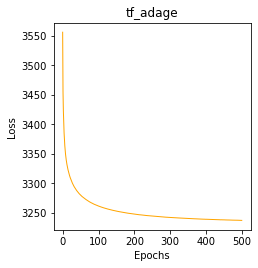

In [15]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)


#name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'tf_adage'
model_temp = model_dict[name]
ax.plot(list(range(0,500)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
ax.set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
#ax.axvline(x = np.std(model_temp.weights)*2.5)
#ax.axvline(x = np.std(model_temp.weights)*-2.5)
ax.set(title = name)
#ax.set_yscale('log')



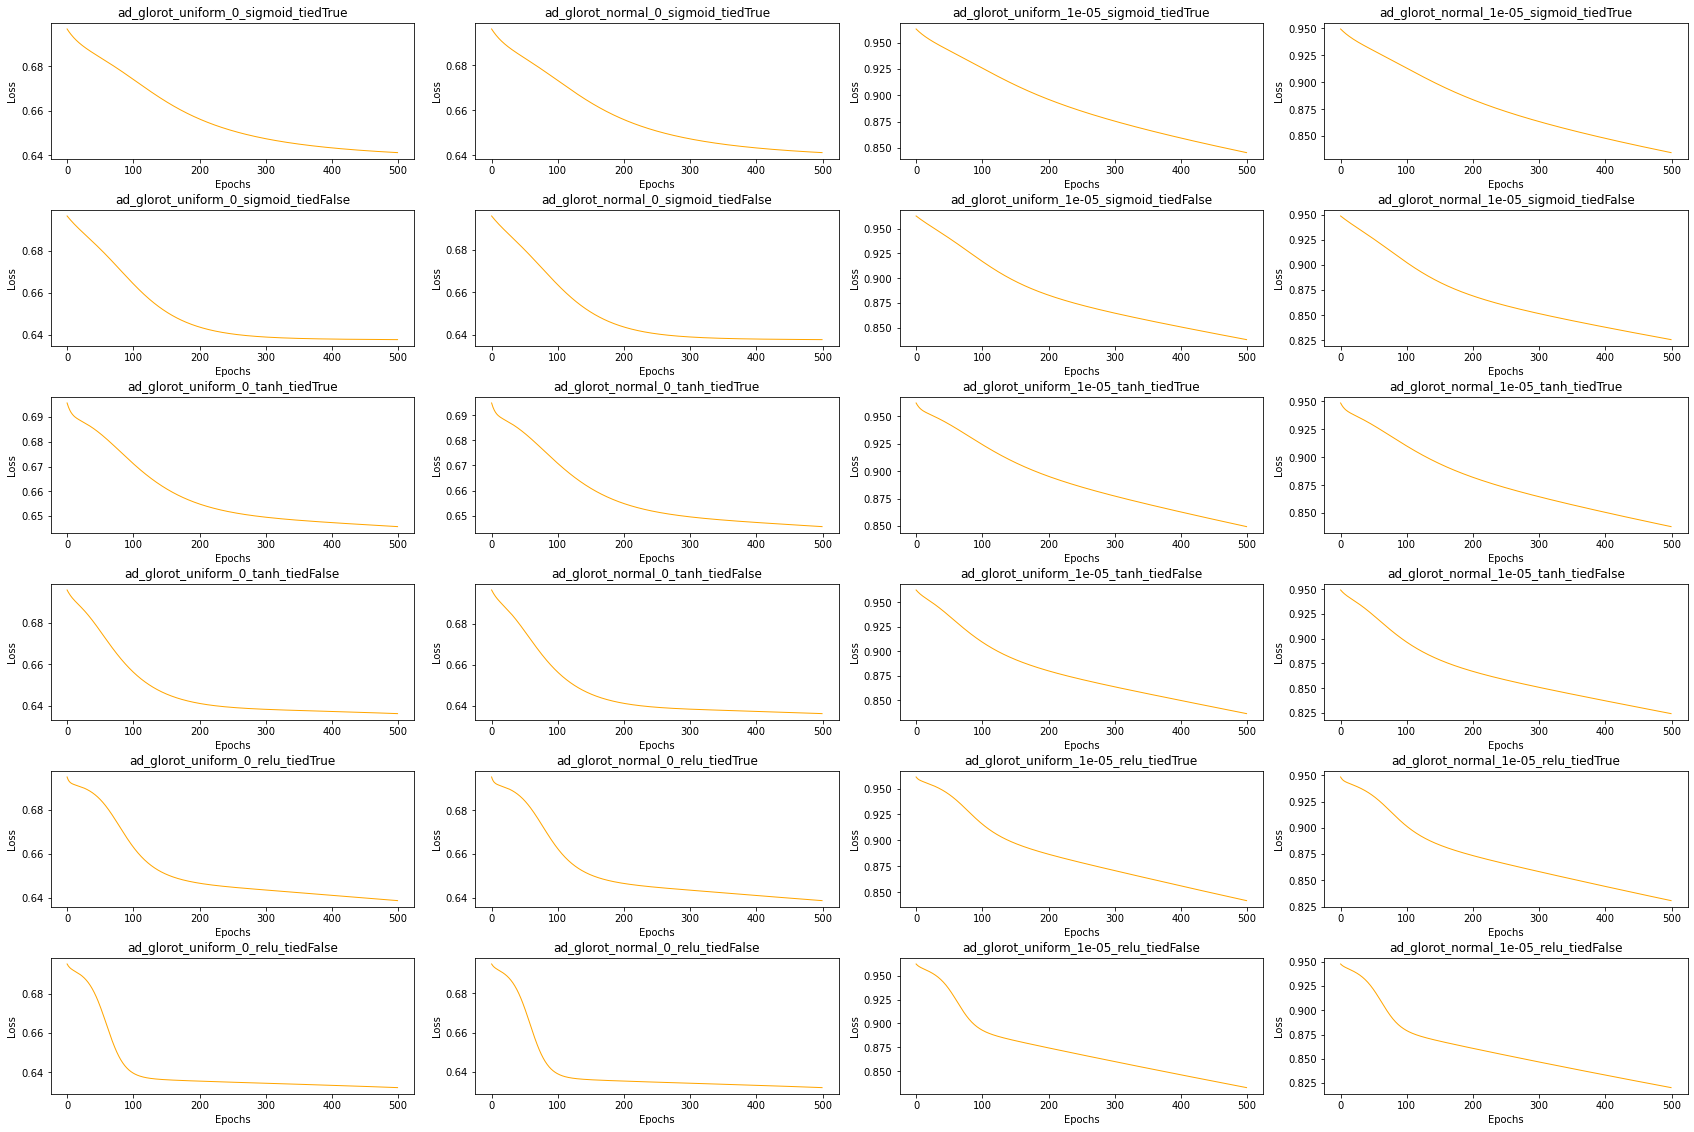

In [17]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) #+ str(460)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].plot(list(range(0,500)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
                ax[xi,yi].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
                xi = xi+1
        yi=yi+1


    

In [ ]:
fig.savefig('loss_array.png')

*Takeaway*: Both models reach asymptotes though TF ADAGE has a sharper elbow, perhaps due to L1?

### 2. Node weight dists

We expect the node weights to follow a *certain* distribution and this has bene important for our definition of 'high weight genes' and our interpretation of ADAGE models. 

[Text(9.125, 0.5, '# Nodes'),
 Text(0.5, 15.0, '# HW genes'),
 Text(0.5, 1, 'tf_adage')]

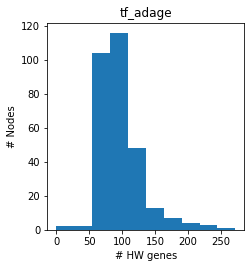

In [23]:
model_dict.keys()

dict_keys(['tf_adage', 'ad_glorot_uniform_0_sigmoid_tiedTrue'])

/home/georgia/anaconda3/envs/tfk/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'tf_adage')]

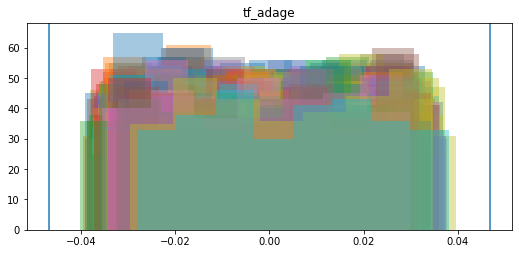

In [18]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)


#name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'tf_adage'
model_temp = model_dict['ad_glorot_uniform_0_sigmoid_tiedTrue']
for node in range(0,300):
    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
    ax=ax,
    hist=True,
    kde=False,
    rug=False)
ax.axvline(x = np.std(model_temp.weights)*2.5)
ax.axvline(x = np.std(model_temp.weights)*-2.5)
ax.set(title = name)
#ax.set_yscale('log')




In [ ]:
fig.savefig('weight_dists_adage.png')

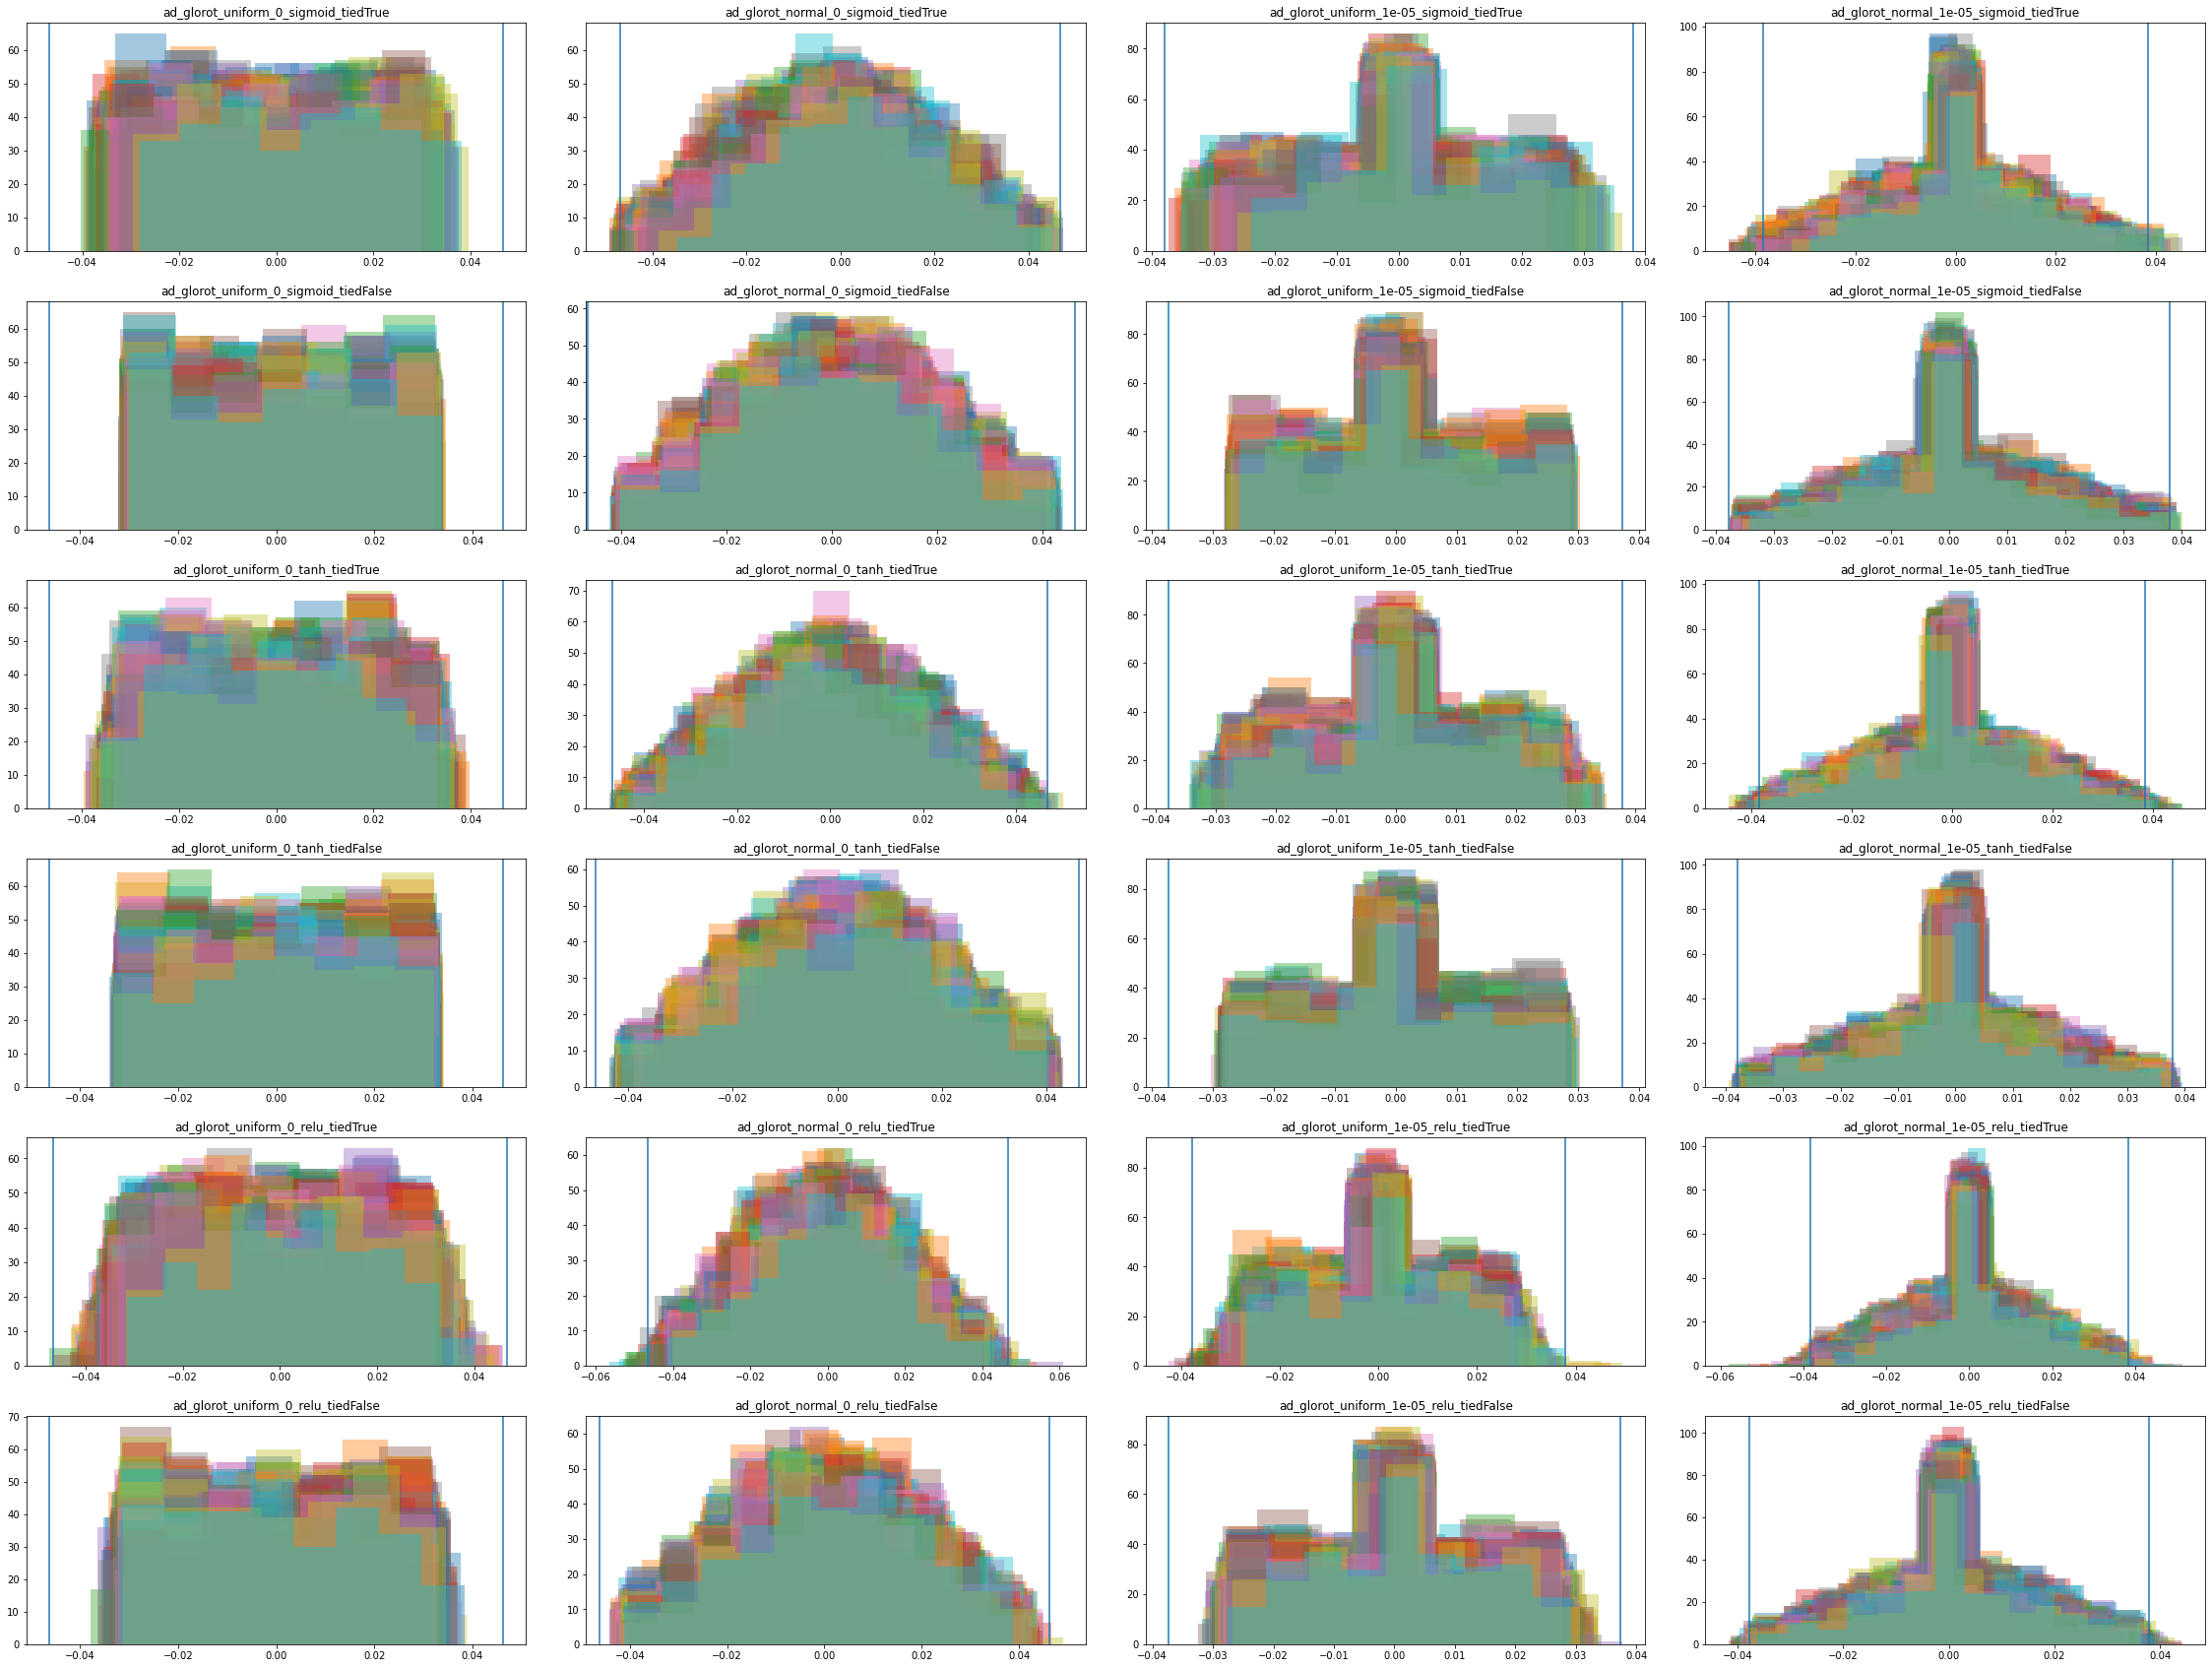

In [19]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(yd*8 ,xd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) #+ str(460)
                #print(name)
                model_temp = model_dict[name]
                for node in range(0,300):
                    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
                        ax=ax[xi,yi],
                        hist=True,
                        kde=False,
                        rug=False)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*2.5)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*-2.5)
                ax[xi,yi].set(title = name)
                xi = xi+1
        yi=yi+1


    

In [ ]:
fig.savefig('weight_dists_array.png')

[Text(0.5, 1, 'ad_glorot_normal_1e-05_relu_tiedFalse460')]

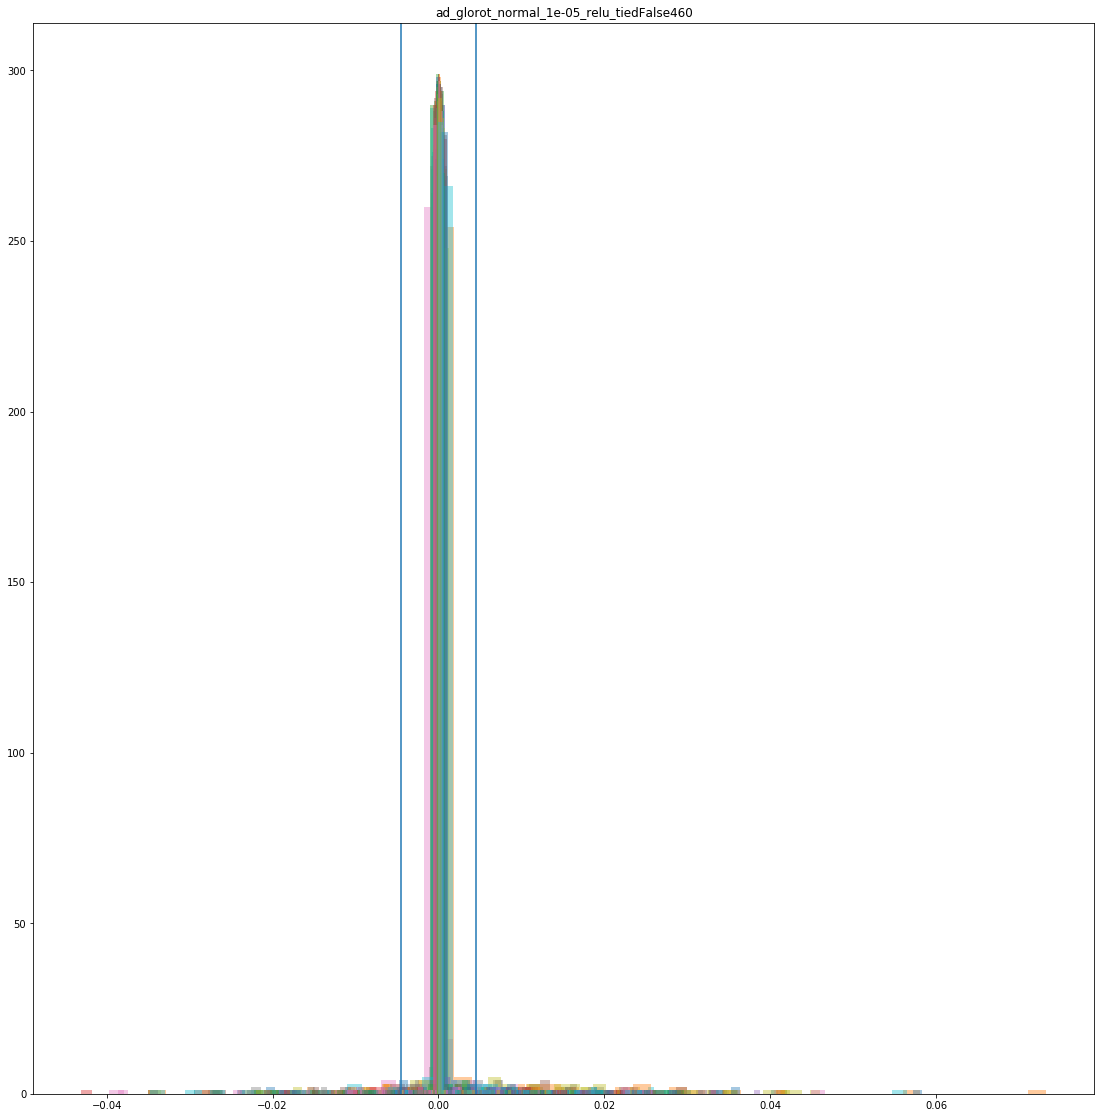

In [51]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*16 ,yd *16))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'ad_glorot_normal_1e-05_relu_tiedFalse460'
model_temp = model_dict[name]
for node in range(0,300):
    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
    ax=ax,
    hist=True,
    kde=False,
    rug=False)
ax.axvline(x = np.std(model_temp.weights)*2.5)
ax.axvline(x = np.std(model_temp.weights)*-2.5)
ax.set(title = name)
#ax.set_yscale('log')



In [ ]:
fig.savefig('single_weight_dist_skewed.png')

In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict_seq[name]
                for node in range(0,300):
                    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
                        ax=ax[xi,yi],
                        hist=True,
                        kde=False,
                        rug=False)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*2.5)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*-2.5)
                ax[xi,yi].set(title = name)
                xi = xi+1
        yi=yi+1


In [ ]:
fig.savefig('weight_dist_seq.png')

In [ ]:
### Signature sizes

[Text(9.125, 0.5, '# Nodes'),
 Text(0.5, 15.0, '# HW genes'),
 Text(0.5, 1, 'tf_adage')]

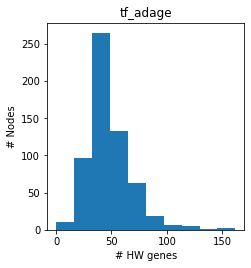

In [102]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

name = 'tf_adage'
model_temp = model_dict[name]
ax.hist(model_temp.hw_genes_all.sum(0))
ax.set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
#ax.set_yscale('log')


In [ ]:
fig.savefig('sig_sizes_adage.png')

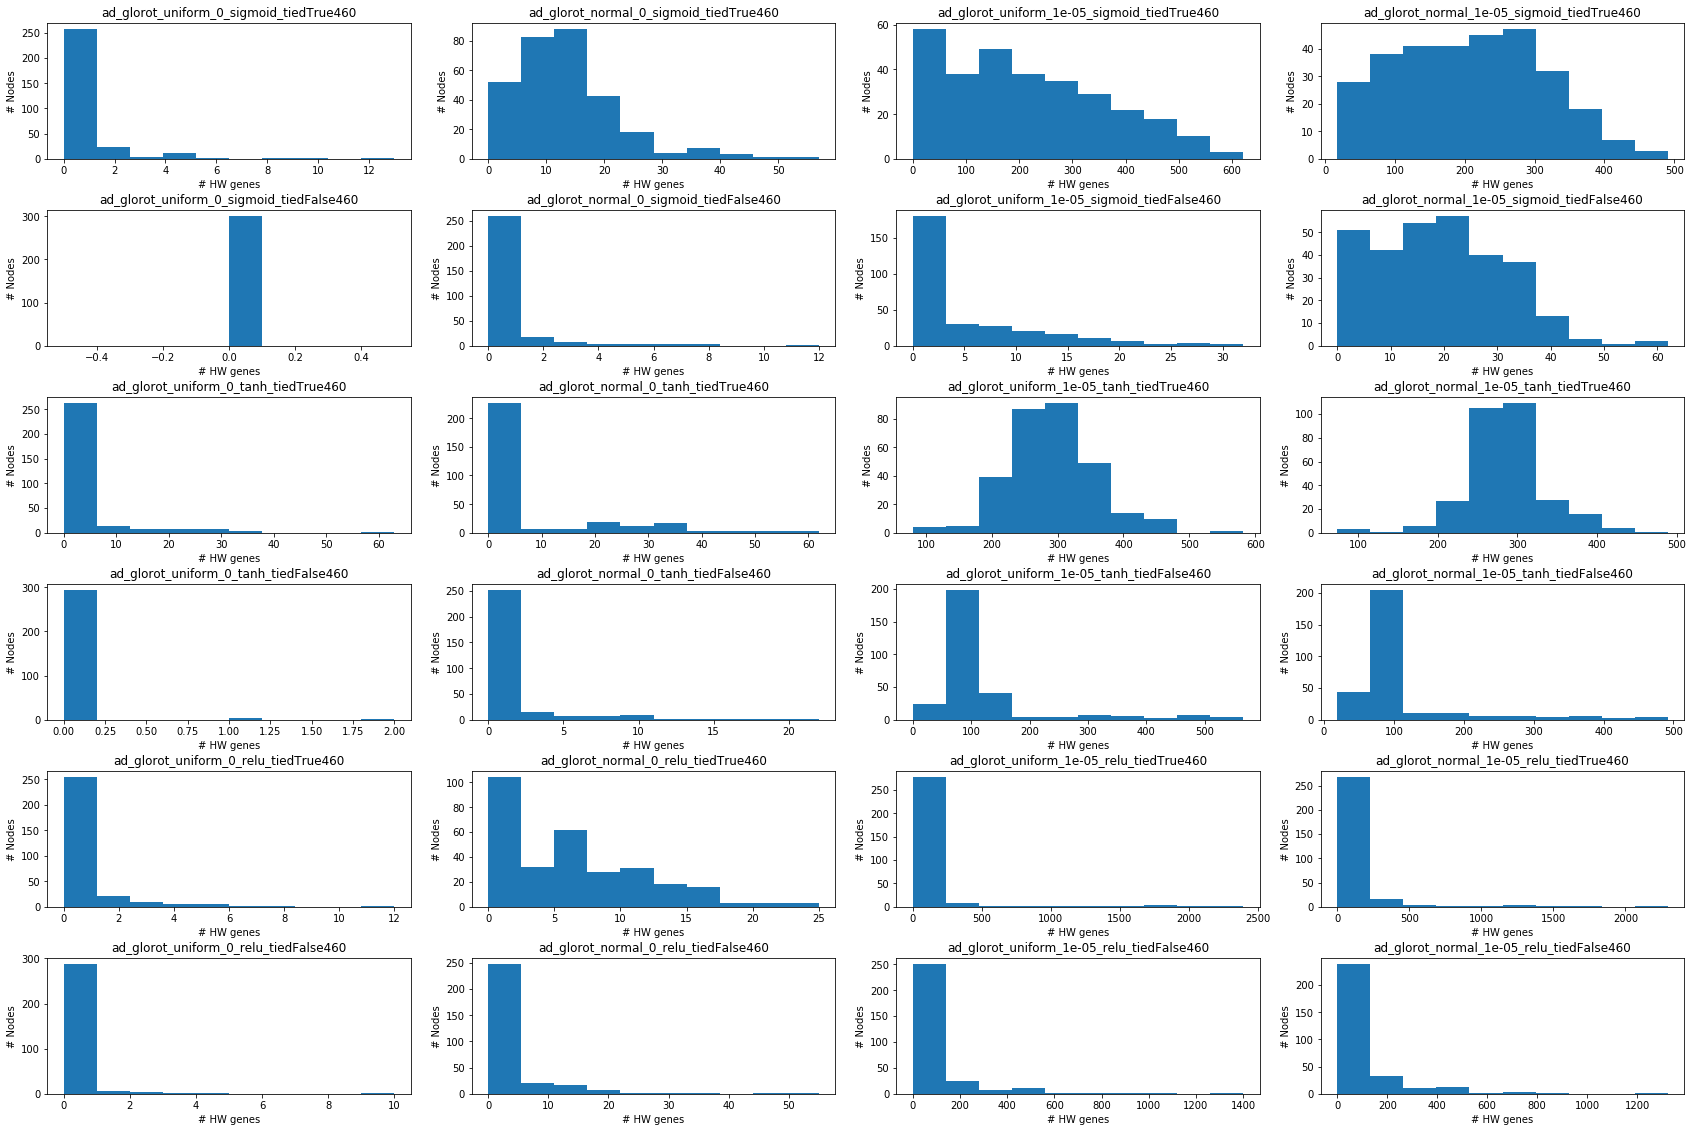

In [57]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].hist(model_temp.hw_genes.sum(0))
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                xi = xi+1
        yi=yi+1


    

In [ ]:
fig.savefig('sig_sizes_array.png')

[Text(9.125, 0.5, '# Nodes'),
 Text(0.5, 15.0, '# HW genes'),
 Text(0.5, 1, 'tf_adage')]

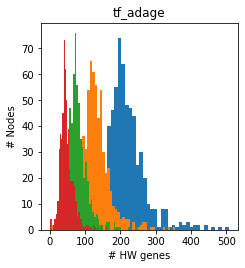

In [103]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'tf_adage'
model_temp = model_dict[name]
for c in [1.75,2,2.25,2.5]:
    model_temp.set_hwg_cutoff(c)
    ax.hist(model_temp.hw_genes_all.sum(0), bins=50)
ax.set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
#ax.set_yscale('log')



In [ ]:
fig.savefig('hwgs_grad_adage.png')

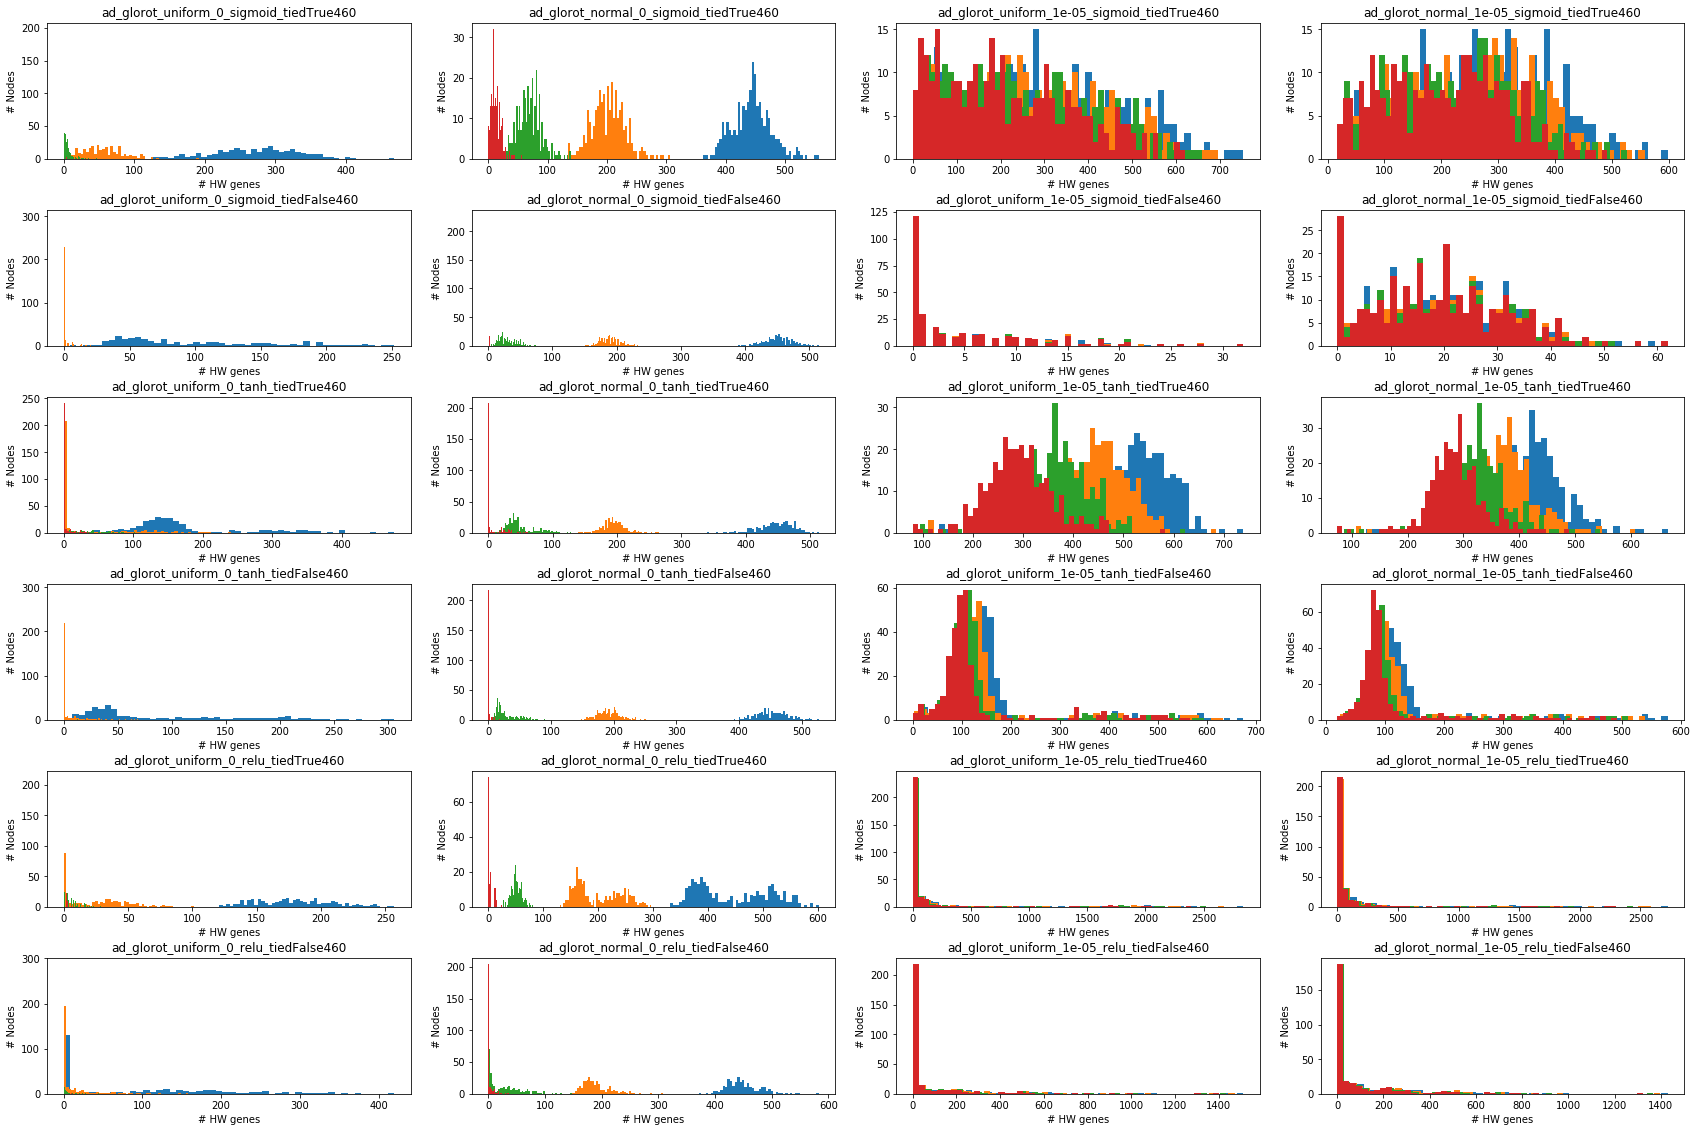

In [60]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                #ax[xi,yi].set_xscale('log')
                for c in [1.75,2,2.25,2.5]:
                    model_temp.set_hwg_cutoff(c)
                    ax[xi,yi].hist(model_temp.hw_genes.sum(0), bins=50)

                xi = xi+1
        yi=yi+1

In [ ]:
fig.savefig('hwgs_grad_array.png')

*Takeaway*: TF ADAGE may have a wider range of distributions and one *curious" node, though it is hard to say which distribution is "better" without looking at the genes themselves.

### 3. Node KEGG and GO enrichemnts

One of the primary ways we assess ADAGE models is enrichment analyses of each node for KEGG and GO pathways. Based on ADAGE, ADAGE2 and eADAGE we expect over three-quarters of the KEGG pathways to be enriched in at least one node and about half of nodes to be have enrichemnt for at least one KEGG pathway.

In [112]:
model_dict['tf_adage'].set_hwg_cutoff(2.5)
model_dict['tf_adage'].set_reg('node_interpretation/regulons_format.txt')
#model_dict[m].set_go('node_interpretation/regulons_format.txt')

0     Regulon  Anr_regulon  PhoB_regulon  PvdR_regulon  PchR_regulon  \
0    4.709350     7.751267      0.854906     12.117012      2.272795   
1    4.358693     0.499701      0.490322      1.800917      1.942702   
2    5.325536     3.051244      0.603320      2.716854      2.866349   
3    5.254077     1.152198      1.593672      2.647723      2.796863   
4    5.443319     1.310983      3.488575      2.831144      2.981172   
..        ...          ...           ...           ...           ...   
595  5.325536    10.787093      4.967311      2.716854      2.866349   
596  4.932494     2.359278      2.232509      2.338918      2.486112   
597  4.251925     2.495871      0.102574      1.703336      4.419290   
598  4.632389     0.677867      0.766548      2.055020      2.199758   
599  4.494239     8.918652      0.619450      1.926101      2.069446   

0    AlgU_regulon  LasR_regulon  RhlR_regulon  PqsR_regulon  QscR_regulon  \
0        1.799518      0.703028      0.392138      2.143654      8.600160   
1        1.013102      0.377483      0.225077      0.670775      0.105111   
2        0.364276      0.516656      0.787832      3.654475      9.471000   
3        0.327877     18.095144      3.668061      9.881495     19.710989   
4        0.428360      4.926666      0.875319      2.191071     10.550106   
..            ...           ...           ...           ...           ...   
595      2.233795      1.499811      0.787832      5.624612      0.516319   
596      0.188831      1.937869      4.478694      0.474199      1.809032   
597      0.151205      0.720518      1.366327      0.563366      5.448425   
598      0.890621      6.317501      5.028026      0.986484      1.024386   
599      0.284628      1.091794      7.833060      7.359862      3.366743   

0    VreI_regulon  
0        1.434043  
1        1.135859  
2        1.991735  
3        1.925405  
4        4.927604  
..            ...  
595      4.697263  
596      1.631885  
597      1.048845  
598      3.381904  
599      1.249025  

[600 rows x 11 columns]

In [ ]:

for m in model_dict:
    model_dict[m].set_hwg_cutoff(2.5)
    model_dict[m].set_op('node_interpretation/operons_format.txt')
    model_dict[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    model_dict[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    model_dict[m].set_reg('node_interpretation/regulons_format.txt')
  


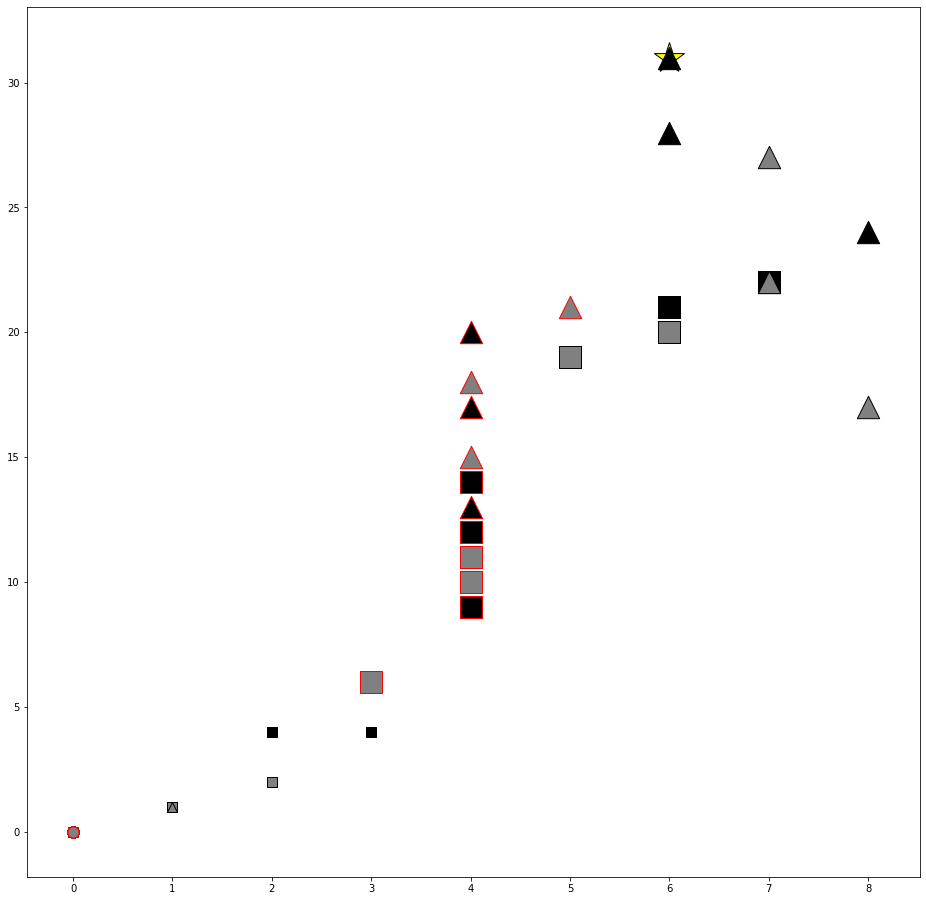

In [123]:
plimk=30
plimg=30
plimr=30
plimo=30
xd=4
yd=4
fig, ax = plt.subplots(xd,yd,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

x = ((model_dict['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[1,2].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

x = ((model_dict['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[2,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[2,2].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[1,2].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[2,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                    y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[2,2].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'



In [161]:
total_kegg = []
node_rep = []
names = []
for m in model_d:
    total_kegg.append(((model_d[m].kegg_ps > 10).sum(0) > 0).sum())
    node_rep.append(((model_d[m].kegg_ps > 10).sum(1) > 0).sum())
    names.append(m)
    #print(m + '\n\t' + str(((model_d[m].kegg_ps > 10).sum(0) > 0).sum()) + '\t' + str(((model_d[m].kegg_ps > 10).sum(1) > 0).sum()))
    

fig, ax = plt.subplots()
ax.scatter(total_kegg, node_rep)

i=0
for x,y in zip(total_kegg, node_rep):
    label = names[i]
    if(i < 24):
        ax.annotate(label,(x,y))
    i = i+1
ax.set_xlabel('# KEGG Pathways represented', fontsize=15)
ax.set_ylabel('# Nodes with Pathways', fontsize=15)


NameError: name 'model_d' is not defined

In [162]:
model_temp = model_dict['tf_adage']

hw_gene_lists = []
for n in range(model_temp.hw_genes.shape[1]):
    genes_temp = ['node'+str(n)]
    weights_temp = [1]
    for g in range(model_temp.hw_genes.shape[0]):
        if(model_temp.hw_genes[g,n]):
            #print(g)
            genes_temp.append(model_temp.compendium.index[g])
            weights_temp.append(model_temp.weights[g,n])
    genes_temp_sorted = [x for _,x in sorted(zip(weights_temp, genes_temp), reverse=True)]
    hw_gene_lists.append(genes_temp_sorted)
    

In [ ]:
hw_gene_lists[1]

In [ ]:
#write_data('test_hwgs.csv', hw_gene_lists)
with open("adage_hwgs.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(hw_gene_lists)

In [ ]:
model_temp = model_dict['tf_adage']

hw_gene_lists = []
for n in range(model_temp.hw_genes.shape[1]):
    genes_temp = ['node'+str(n)]
    weights_temp = [1]
    for g in range(model_temp.hw_genes.shape[0]):
        if(model_temp.hw_genes[g,n]):
            #print(g)
            genes_temp.append(model_temp.compendium.index[g])
            weights_temp.append(model_temp.weights[g,n])
    genes_temp_sorted = [x for _,x in sorted(zip(weights_temp, genes_temp), reverse=True)]
    hw_gene_lists.append(genes_temp_sorted)
hw_gene_lists[1]
#write_data('test_hwgs.csv', hw_gene_lists)
with open("adage_hwgs.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(hw_gene_lists)

In [ ]:
total_kegg = []
node_rep = []
names = []
for m in model_d:
    total_kegg.append(((model_d[m].kegg_ps > 10).sum(0) > 0).sum())
    node_rep.append(((model_d[m].kegg_ps > 10).sum(1) > 0).sum())
    names.append(m)
    #print(m + '\n\t' + str(((model_d[m].kegg_ps > 10).sum(0) > 0).sum()) + '\t' + str(((model_d[m].kegg_ps > 10).sum(1) > 0).sum()))
    

fig, ax = plt.subplots()
ax.scatter(total_kegg, node_rep)

i=0
for x,y in zip(total_kegg, node_rep):
    label = names[i]
    if(i < 24):
        ax.annotate(label,(x,y))
    i = i+1
ax.set_xlabel('# KEGG Pathways represented', fontsize=15)
ax.set_ylabel('# Nodes with Pathways', fontsize=15)


In [ ]:
model_dict

KeyError: 'ad_glorot_uniform_0_sigmoid_tiedTrue460'

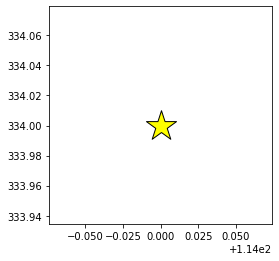

In [114]:
fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].kegg_ps > 10).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(10):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict[name]
                    x = ((model_temp.regs_ps > 10).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > 10).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    #ax[xi,yi].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'




In [ ]:

for m in model_dict:
    model_dict[m].set_hwg_cutoff(2.5)
    model_dict[m].set_go('node_interpretation/regulons_format.txt')
#model_dict['tf_adage'].set_hwg_cutoff(2.5)
#model_dict['tf_adage'].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')    




In [ ]:
plim = 30

fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].go_ps > plim).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plim).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(10):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict[name]
                    x = ((model_temp.go_ps > plim).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plim).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    ax.set(title = m, xlabel = '# Regulons', ylabel = '# Nodes')

                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'


In [ ]:

fig.savefig('regulon_summary_array.png')

In [ ]:

fig, ax = plt.subplots(len(model_d), 2,figsize=(10,3*len(model_d)))
fig.tight_layout(pad=3.0)

#ax[0].plot(list(range(0,500)), tf_adage.loss,'go-', linewidth=1, markersize=2)
#ax[0].set(title = 'TF', xlabel = 'Epochs', ylabel = 'Cost')
i = 0
for m in model_d:
    ax[i,0].hist((model_d[m].kegg_ps > 10).sum(0))
    ax[i,0].set(title = m, xlabel = '# Nodes per Pathway', ylabel = '# Pathways')
    ax[i,1].hist((model_d[m].kegg_ps > 10).sum(1))
    ax[i,1].set(title = m, xlabel = '# Pathways in Node', ylabel = '# Nodes')
    i = i+1

In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for i in inits:
    for l in L1_norm:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].hist((model_temp.kegg_ps > 10).sum(0))
                ax[xi,yi].set(title = name, xlabel = '# Nodes per Pathway', ylabel = '# Pathways')
                xi = xi+1
        yi=yi+1



In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for i in inits:
    for l in L1_norm:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].hist((model_temp.kegg_ps > 10).sum(0))
                ax[xi,yi].set(title = name, xlabel = '# Nodes per Pathway', ylabel = '# Pathways')
                xi = xi+1
        yi=yi+1


yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for i in inits:
    for l in L1_norm:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].hist((model_temp.kegg_ps > 10).sum(1))
                ax[xi,yi].set(title = name, xlabel = '# Pathways in Node', ylabel = '# Nodes')
                xi = xi+1
        yi=yi+1



In [ ]:
fig.savefig('kegg_details.png')

*Takeaway*: This is where the red flag really stands out. Using Keras there was nearly no enrichemnt for any pathways in any nodes at all, perhaps what one would expect using randomly permuted weights? It could be nice to get a good pre- and post- training picture, but I think it is safe to say something has missed the boat.

## seqADAGE

Although the above comparison suggests an error in the Keras workflow, below I have outlines the training of a Keras model on the RNAseq compendium in anticipation of an re-iterative analysis going forward with promising edits.

In [ ]:
#adage_comp = pandas.read_csv('data_files/ADAGE_compendium.csv')
seq_comp = np.loadtxt(open('data_files/refine_bio_seq_clean.csv', "rb"),delimiter=',',skiprows = 1)
seq_gene_num = np.size(seq_comp, 0)
seq_samp_num = np.size(seq_comp, 1)
print(seq_gene_num, seq_samp_num)

In [ ]:
fig = sns.distplot(seq_comp)

In [ ]:
fig.figure.savefig('seq_dist01.png')

In [ ]:
seq_adage = run_model.run_model('data_files/refine_bio_seq_with_gene_names.csv',seed=460,kl1=0,act='relu', tied=True, epochs=500, init = 'glorot_normal')

In [ ]:
model_d = {
    "tf_adage": tf_adage,
    "keras" : keras_adage,
    "keras_L1" : keras_adage_L1,
    'seq_adage': seq_adage
}

for m in model_d:
    print(model_d[m])

In [ ]:
model_dict_seq = {
    "tf_adage": tf_adage
}

for i in inits:
    #print(i)
    for l in L1_norm:
        #print(l)
        for a in act_fun:
            #print(a)
            for t in tied:
                m = run_model.run_model('data_files/refine_bio_seq_01_with_names.csv',seed=460,kl1=l, act = a, tied = t, epochs=500, init=i, batch_size=100)
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                print(name)
                model_dict_seq[name] = m

In [164]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict_seq = {
    "tf_adage": tf_adage
}

for i in inits:
    #print(i)
    for l in L1_norm:
        #print(l)
        for a in act_fun:
            #print(a)
            for t in tied:
                for s in range(3):
                    seed = str(460 + s)
                    #print(t)
                    #m = run_model.run_model('data_files/train_set_normalized.csv',seed=460,kl1=l, act = a, tied = t, epochs=500, init=i)
                    prefix = 'data_files/refine_bio_seq_01_with_names_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:500_tied:' + str(t) + '_batch:' + str(batch)
                    #print(prefix)
                    weights_temp = np.array(pandas.read_csv('outputs/' + prefix + '_en_weights.csv', header = None))
                    loss_temp = np.array(pandas.read_csv('outputs/' + prefix + '_loss.csv', header = None))
                    val_loss_temp = np.array(pandas.read_csv('outputs/' + prefix + '_val_loss.csv', header = None))
                    adage_temp = Adage.Adage(tf_adage.autoencoder, tf_adage.history, tf_adage.compendium)
                    adage_temp.weights = weights_temp
                    adage_temp.loss = loss_temp[0]
                    adage_temp.val_loss = val_loss_temp[0]
                    adage_temp.set_hwg_cutoff(2.5)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_dict_seq[name] = adage_temp
          
                    


In [165]:
model_dict_seq

{'tf_adage': <Adage.Adage at 0x7f6bffe070d0>,
 'ad_glorot_uniform_0_sigmoid_tiedTrue460': <Adage.Adage at 0x7f6ca14fce50>,
 'ad_glorot_uniform_0_sigmoid_tiedTrue461': <Adage.Adage at 0x7f6ca14fc090>,
 'ad_glorot_uniform_0_sigmoid_tiedTrue462': <Adage.Adage at 0x7f6c41b93510>,
 'ad_glorot_uniform_0_sigmoid_tiedFalse460': <Adage.Adage at 0x7f6c48c23cd0>,
 'ad_glorot_uniform_0_sigmoid_tiedFalse461': <Adage.Adage at 0x7f6b994f4e50>,
 'ad_glorot_uniform_0_sigmoid_tiedFalse462': <Adage.Adage at 0x7f6ca80164d0>,
 'ad_glorot_uniform_0_tanh_tiedTrue460': <Adage.Adage at 0x7f6c41b98ad0>,
 'ad_glorot_uniform_0_tanh_tiedTrue461': <Adage.Adage at 0x7f6c41b98750>,
 'ad_glorot_uniform_0_tanh_tiedTrue462': <Adage.Adage at 0x7f6c073d31d0>,
 'ad_glorot_uniform_0_tanh_tiedFalse460': <Adage.Adage at 0x7f6c073d3b10>,
 'ad_glorot_uniform_0_tanh_tiedFalse461': <Adage.Adage at 0x7f6c073d3c90>,
 'ad_glorot_uniform_0_tanh_tiedFalse462': <Adage.Adage at 0x7f6c073d3b50>,
 'ad_glorot_uniform_0_relu_tiedTrue460': <

In [ ]:
model_d = model_dict_seq

In [ ]:

fig, ax = plt.subplots(len(model_d), 1,figsize=(6,3*len(model_d)))
fig.tight_layout(pad=3.0)

#ax[0].plot(list(range(0,500)), tf_adage.loss,'go-', linewidth=1, markersize=2)
#ax[0].set(title = 'TF', xlabel = 'Epochs', ylabel = 'Cost')
i = 0
for m in model_d:
    ax[i].plot(list(range(0,500)), model_d[m].loss, 'go-', linewidth=1, markersize=2, color = 'orange')
    ax[i].set(title = m, xlabel = 'Epochs', ylabel = 'Loss')
    i = i+1

In [ ]:
fig.savefig('seq_loss.png')

In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict_seq[name]
                ax[xi,yi].plot(list(range(0,500)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
                ax[xi,yi].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
                xi = xi+1
        yi=yi+1



In [ ]:
fig.savefig('loss_seq.png')

In [ ]:
fig, ax = plt.subplots(len(model_d), 1,figsize=(6,3*len(model_d)))
fig.tight_layout(pad=3.0)


i = 0
for m in model_d:
    #ax[i].sns.distplot(list(range(0,500)), model_d[m].weights[0], 'go-', linewidth=1, markersize=2, color = 'orange')
    ax[i].set(title = m, xlabel = 'Weight', ylabel = 'Density')
    for node in range(0,300):
        sns.distplot(model_d[m].weights[node],
            ax=ax[i],
            hist=False,
            kde=True,
            rug=False)
    i = i+1

In [ ]:
fig.savefig('seq_weight_dist.png')

In [ ]:
fig, ax = plt.subplots(len(model_d), 1,figsize=(6,3*len(model_d)))
fig.tight_layout(pad=3.0)

#ax[0].plot(list(range(0,500)), tf_adage.loss,'go-', linewidth=1, markersize=2)
#ax[0].set(title = 'TF', xlabel = 'Epochs', ylabel = 'Cost')
i = 0
for m in model_d:
    ax[i].hist(model_d[m].hw_genes.sum(0))
    ax[i].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
    i = i+1

In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict_seq[name]
                for node in range(0,300):
                    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
                        ax=ax[xi,yi],
                        hist=True,
                        kde=False,
                        rug=False)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*2.5)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*-2.5)
                ax[xi,yi].set(title = name)
                xi = xi+1
        yi=yi+1



In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
                model_temp = model_dict_seq[name]
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                #ax[xi,yi].set_xscale('log')
                for c in [1.75,2,2.25,2.5]:
                    model_temp.set_hwg_cutoff(c)
                    ax[xi,yi].hist(model_temp.hw_genes.sum(0), bins=50)

                xi = xi+1
        yi=yi+1

In [ ]:
fig.savefig('seq_sig_sizes.png')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].kegg_ps > 10).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(10):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq[name]
                    x = ((model_temp.kegg_ps > 10).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > 10).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    #ax[xi,yi].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'


In [ ]:

for m in model_d:
    model_d[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')

In [ ]:
for m in model_dict_seq:
    model_dict_seq[m].set_hwg_cutoff(2.5)
    model_dict_seq[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].kegg_ps > 10).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '.', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(1):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) 
                    print(name)
                    model_temp = model_dict_seq[name]
                    x = ((model_temp.kegg_ps > 10).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > 10).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    #ax[xi,yi].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=200
    c = 'grey'



In [ ]:
fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].kegg_ps > 10).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '.', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi=0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:

                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) 
                print(name)
                model_temp = model_dict_seq[name]
                x = ((model_temp.kegg_ps > 10).sum(0) > 0).sum()
                y = ((model_temp.kegg_ps > 10).sum(1) > 0).sum()
                ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    #ax[xi,yi].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
                xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'

In [ ]:
total_kegg = []
node_rep = []
names = []
for m in model_d:
    total_kegg.append(((model_d[m].kegg_ps > 10).sum(0) > 0).sum())
    node_rep.append(((model_d[m].kegg_ps > 10).sum(1) > 0).sum())
    names.append(m)
    #print(m + '\n\t' + str(((model_d[m].kegg_ps > 10).sum(0) > 0).sum()) + '\t' + str(((model_d[m].kegg_ps > 10).sum(1) > 0).sum()))
    

fig, ax = plt.subplots()
ax.scatter(total_kegg, node_rep)

i=0
for x,y in zip(total_kegg, node_rep):
    label = names[i]
    if(i < 24):
        ax.annotate(label,(x,y))
    i = i+1
ax.set_xlabel('# KEGG Pathways represented', fontsize=15)
ax.set_ylabel('# Nodes with Pathways', fontsize=15)



In [ ]:
fig.savefig('seq_kegg_summary.png')

In [ ]:

fig, ax = plt.subplots(len(model_d), 2,figsize=(8,3*len(model_d)))
fig.tight_layout(pad=3.0)

#ax[0].plot(list(range(0,500)), tf_adage.loss,'go-', linewidth=1, markersize=2)
#ax[0].set(title = 'TF', xlabel = 'Epochs', ylabel = 'Cost')
i = 0
for m in model_d:
    ax[i,0].hist((model_d[m].kegg_ps > 10).sum(0))
    ax[i,0].set(title = m, xlabel = '# Nodes per Pathway', ylabel = '# Pathways')
    ax[i,1].hist((model_d[m].kegg_ps > 10).sum(1))
    ax[i,1].set(title = m, xlabel = '# Pathways in Node', ylabel = '# Nodes')
    i = i+1

In [ ]:
fig.savefig('seq_kegg_details.png')

In [ ]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict = {
    "tf_adage": tf_adage
}

for seed in range(10):
    for i in inits:
    #print(i)
        for l in L1_norm:
        #print(l)
            for a in act_fun:
            #print(a)
                for t in tied:
                    m = run_model.run_model('data_files/refine_bio_seq_01_with_names.csv',seed=seed+460,kl1=l, act = a, tied = t, epochs=500, init=i)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                    print(name)
                    model_dict_seq[name] = m
                    
for m in model_dict_seq:
    model_dict_seq[m].set_hwg_cutoff(2.5)
    model_dict_seq[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')

In [ ]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict_seq = {
    "tf_adage": tf_adage
}

for i in inits:
    #print(i)
    for l in L1_norm:
        #print(l)
        for a in act_fun:
            #print(a)
            for t in tied:
                for s in range(10):
                    seed = str(460 + s)
                    #print(t)
                    #m = run_model.run_model('data_files/train_set_normalized.csv',seed=460,kl1=l, act = a, tied = t, epochs=500, init=i)
                    prefix = 'data_files/refine_bio_seq_01_with_names_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:500_tied:' + str(t)
                    #print(prefix)
                    weights_temp = np.array(pandas.read_csv('outputs/' + prefix + '_en_weights.csv', header = None))
                    loss_temp = np.array(pandas.read_csv('outputs/' + prefix + '_loss.csv', header = None))
                    val_loss_temp = np.array(pandas.read_csv('outputs/' + prefix + '_val_loss.csv', header = None))

                    adage_temp = Adage.Adage(keras_adage.autoencoder, keras_adage.history, keras_adage.compendium)
                    adage_temp.weights = weights_temp
                    adage_temp.loss = loss_temp[0]
                    adage_temp.val_loss = val_loss_temp[0]
                    adage_temp.set_hwg_cutoff(2.5)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    print(name)
                    model_dict_seq[name] = adage_temp
                    
model_dict_seq

In [ ]:
for m in model_dict_seq:
    model_dict_seq[m].set_hwg_cutoff(2.5)
    model_dict_seq[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')

In [ ]:
model_temp = model_dict_seq['ad_glorot_uniform_0_sigmoid_tiedTrue460']

hw_gene_lists = []
for n in range(model_temp.hw_genes.shape[1]):
    genes_temp = ['node'+str(n)]
    weights_temp = [1]
    for g in range(model_temp.hw_genes.shape[0]):
        if(model_temp.hw_genes[g,n]):
            #print(g)
            genes_temp.append(model_temp.compendium.index[g])
            weights_temp.append(model_temp.weights[g,n])
    genes_temp_sorted = [x for _,x in sorted(zip(weights_temp, genes_temp), reverse=True)]
    hw_gene_lists.append(genes_temp_sorted)
    

In [ ]:
#write_data('test_hwgs.csv', hw_gene_lists)
with open("group8_seq_hwgs.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(hw_gene_lists)

In [ ]:

model_dict_seq

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].kegg_ps > 10).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(10):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq[name]
                    x = ((model_temp.kegg_ps > 10).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > 10).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    #ax[xi,yi].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'




In [ ]:
for m in model_dict:
    model_dict_seq[m].set_hwg_cutoff(2.5)
    model_dict_seq[m].set_go('node_interpretation/regulons_format.txt')
#model_dict['tf_adage'].set_hwg_cutoff(2.5)
#model_dict['tf_adage'].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')    


In [ ]:
plim = 8
fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].go_ps > plim).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plim).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(10):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq[name]
                    x = ((model_temp.go_ps > plim).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plim).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    #ax[xi,yi].set(title = m, xlabel = '# HW genes', ylabel = '# Nodes')
                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'


In [ ]:
fig.savefig('regulon_summary_seq.png')

## seqADAGE

Although the above comparison suggests an error in the Keras workflow, below I have outlines the training of a Keras model on the RNAseq compendium in anticipation of an re-iterative analysis going forward with promising edits.

In [ ]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict2 = {
    "tf_adage": tf_adage
}
model_dict_seq2 = {
    "tf_adage": tf_adage
}

for seed in range(10):
    for i in inits:
    #print(i)
        for l in L1_norm:
        #print(l)
            for a in act_fun:
            #print(a)
                for t in tied:
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(seed)
                    print(name)
                    mseq = run_model.run_model('data_files/refine_bio_seq_clean_with_names.csv',seed=seed+560,kl1=l, act = a, tied = t, epochs=500, init=i)
                    marr = run_model.run_model('data_files/train_set_normalized.csv',seed=seed+560,kl1=l, act = a, tied = t, epochs=500, init=i)

                    model_dict2[name] = marr
                    model_dict_seq2[name] = mseq
                

In [8]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]
seq_temp = run_model.run_model('../data_files/refine_bio_seq_clean_with_names.csv',960,kl1=0, act = 'tanh', tied = True, epochs=1, init='glorot_normal')
arr_temp = run_model.run_model('../data_files/train_set_normalized.csv',960,kl1=0, act = 'tanh', tied = True, epochs=1, init='glorot_normal')
tf_adage = Adage.Adage(arr_temp.autoencoder, arr_temp.history, arr_temp.compendium)
tf_weights = np.array(pd.read_csv('../outputs/ADAGE_OG_weights.csv', header = None))
tf_cost = pd.read_csv('../outputs/ADAGE_OG_cost_log.csv')
tf_adage.weights = tf_weights
tf_adage.loss = tf_cost['cost']
tf_adage.set_hwg_cutoff(2.5).shape

tensorflow
(5210, 995)
90/90 [==============================] - 2s 15ms/step - loss: 2.4632 - val_loss: 1.8423
(2,)
tensorflow
(5549, 950)
86/86 [==============================] - 2s 19ms/step - loss: 2.2743 - val_loss: 1.6891
(2,)


(5549, 600)

In [16]:
seq_temp.compendium

ERR583485  ERR583486  ERR583487  ERR583488  ERR583489  ERR583490  \
X                                                                          
PA0001   0.671443   0.708615   0.754896   0.692356   0.709740   0.643171   
PA0002   0.475630   0.499940   0.603676   0.499238   0.563537   0.493243   
PA0003   0.527891   0.578327   0.629401   0.579720   0.609309   0.594365   
PA0004   0.524364   0.553934   0.654255   0.560586   0.635635   0.549134   
PA0005   0.327333   0.360534   0.495376   0.407000   0.453617   0.358099   
...           ...        ...        ...        ...        ...        ...   
PA5564   0.375295   0.397557   0.385648   0.366963   0.395829   0.374039   
PA5565   0.677224   0.688574   0.659348   0.580513   0.643933   0.549346   
PA5566   0.166319   0.161202   0.338037   0.261451   0.326882   0.232460   
PA5568   0.671777   0.673660   0.648053   0.615674   0.635533   0.604452   
PA5569   0.528206   0.551225   0.646739   0.496328   0.637053   0.508383   

        ERR583491  ERR583492  ERR583493  ERR583494  ...  SRR10856464  \
X                                                   ...                
PA0001   0.814958   0.813673   0.612071   0.601390  ...     0.713945   
PA0002   0.579042   0.585886   0.461118   0.473614  ...     0.639362   
PA0003   0.731892   0.696162   0.469088   0.481004  ...     0.629865   
PA0004   0.697372   0.712418   0.550984   0.564737  ...     0.744624   
PA0005   0.335235   0.380722   0.325236   0.313923  ...     0.531310   
...           ...        ...        ...        ...  ...          ...   
PA5564   0.398319   0.415448   0.273601   0.252365  ...     0.533213   
PA5565   0.644655   0.652909   0.512445   0.497420  ...     0.724968   
PA5566   0.213960   0.200833   0.176812   0.197625  ...     0.346166   
PA5568   0.676529   0.682554   0.555338   0.547771  ...     0.724803   
PA5569   0.518933   0.563911   0.453450   0.461412  ...     0.633352   

        SRR10856465  SRR10856468  SRR10856475  SRR10856476  SRR10856477  \
X                                                                         
PA0001     0.713606     0.649205     0.656233     0.688644     0.689434   
PA0002     0.653312     0.624799     0.617239     0.651947     0.656096   
PA0003     0.629187     0.548001     0.548130     0.598767     0.602136   
PA0004     0.747036     0.693060     0.690483     0.732670     0.736854   
PA0005     0.529932     0.505435     0.501224     0.503099     0.502439   
...             ...          ...          ...          ...          ...   
PA5564     0.530416     0.447806     0.417744     0.497868     0.506976   
PA5565     0.714228     0.631686     0.620521     0.685616     0.687426   
PA5566     0.376799     0.411912     0.416786     0.331355     0.347427   
PA5568     0.724986     0.668699     0.672685     0.696249     0.702610   
PA5569     0.623829     0.561042     0.551728     0.616899     0.620216   

        SRR10856478  SRR10856479  SRR10856480       NA.  
X                                                        
PA0001     0.671596     0.681038     0.671996  0.668927  
PA0002     0.733395     0.735548     0.636665  0.631781  
PA0003     0.570664     0.565829     0.592751  0.581351  
PA0004     0.728671     0.730206     0.708053  0.699519  
PA0005     0.448920     0.508096     0.543919  0.559678  
...             ...          ...          ...       ...  
PA5564     0.455384     0.459894     0.486245  0.471133  
PA5565     0.644645     0.649773     0.651875  0.647432  
PA5566     0.222948     0.283338     0.451496  0.443314  
PA5568     0.698851     0.692690     0.695474  0.690123  
PA5569     0.656138     0.639071     0.589136  0.588639  

[5210 rows x 995 columns]

In [20]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]

model_dict3 = {
    "tf_adage": tf_adage
}

model_dict_seq3 = {
    "tf_adage": tf_adage
}

for i in inits:
    #print(i)
    for l in L1_norm:
        #print(l)
        for a in act_fun:
            #print(a)
            for t in tied:
                for s in range(3):
                    seed = str(560 + s)
                    #print(t)
                    #m = run_model.run_model('data_files/train_set_normalized.csv',seed=460,kl1=l, act = a, tied = t, epochs=500, init=i)
                    prefix = 'data_files/train_set_normalized_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:500_tied:' + str(t)
                    #print(prefix)
                    weights_temp = np.array(pd.read_csv('outputs/' + prefix + '_en_weights.csv', header = None))
                    loss_temp = np.array(pd.read_csv('outputs/' + prefix + '_loss.csv', header = None))
                    val_loss_temp = np.array(pd.read_csv('outputs/' + prefix + '_val_loss.csv', header = None))
                    adage_temp = Adage.Adage(tf_adage.autoencoder, tf_adage.history, tf_adage.compendium)
                    adage_temp.weights = weights_temp
                    adage_temp.loss = loss_temp[0]
                    adage_temp.val_loss = val_loss_temp[0]
                    adage_temp.set_hwg_cutoff(2.5)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_dict3[name] = adage_temp
                    
                    prefix = 'data_files/refine_bio_seq_clean_with_names_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:500_tied:' + str(t)
                    #print(prefix)
                    weights_temp = np.array(pd.read_csv('outputs/' + prefix + '_en_weights.csv', header = None))
                    loss_temp = np.array(pd.read_csv('outputs/' + prefix + '_loss.csv', header = None))
                    val_loss_temp = np.array(pd.read_csv('outputs/' + prefix + '_val_loss.csv', header = None))
                    adage_temp = Adage.Adage(seq_temp.autoencoder, seq_temp.history, seq_temp.compendium)
                    adage_temp.weights = weights_temp
                    adage_temp.loss = loss_temp[0]
                    adage_temp.val_loss = val_loss_temp[0]
                    adage_temp.set_hwg_cutoff(2.5)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_dict_seq3[name] = adage_temp
          
                    

In [181]:
for m in model_dict_seq2:
    print(m)

tf_adage
ad_glorot_uniform_0_sigmoid_tiedTrue
ad_glorot_uniform_0_sigmoid_tiedFalse
ad_glorot_uniform_0_tanh_tiedTrue
ad_glorot_uniform_0_tanh_tiedFalse
ad_glorot_uniform_0_relu_tiedTrue
ad_glorot_uniform_0_relu_tiedFalse
ad_glorot_uniform_1e-05_sigmoid_tiedTrue
ad_glorot_uniform_1e-05_sigmoid_tiedFalse
ad_glorot_uniform_1e-05_tanh_tiedTrue
ad_glorot_uniform_1e-05_tanh_tiedFalse
ad_glorot_uniform_1e-05_relu_tiedTrue
ad_glorot_uniform_1e-05_relu_tiedFalse
ad_glorot_normal_0_sigmoid_tiedTrue
ad_glorot_normal_0_sigmoid_tiedFalse
ad_glorot_normal_0_tanh_tiedTrue
ad_glorot_normal_0_tanh_tiedFalse
ad_glorot_normal_0_relu_tiedTrue
ad_glorot_normal_0_relu_tiedFalse
ad_glorot_normal_1e-05_sigmoid_tiedTrue
ad_glorot_normal_1e-05_sigmoid_tiedFalse
ad_glorot_normal_1e-05_tanh_tiedTrue
ad_glorot_normal_1e-05_tanh_tiedFalse
ad_glorot_normal_1e-05_relu_tiedTrue
ad_glorot_normal_1e-05_relu_tiedFalse
ad_glorot_uniform_0_sigmoid_tiedTrue560
ad_glorot_uniform_0_sigmoid_tiedTrue561
ad_glorot_uniform_0_sig

#### Training loss curves

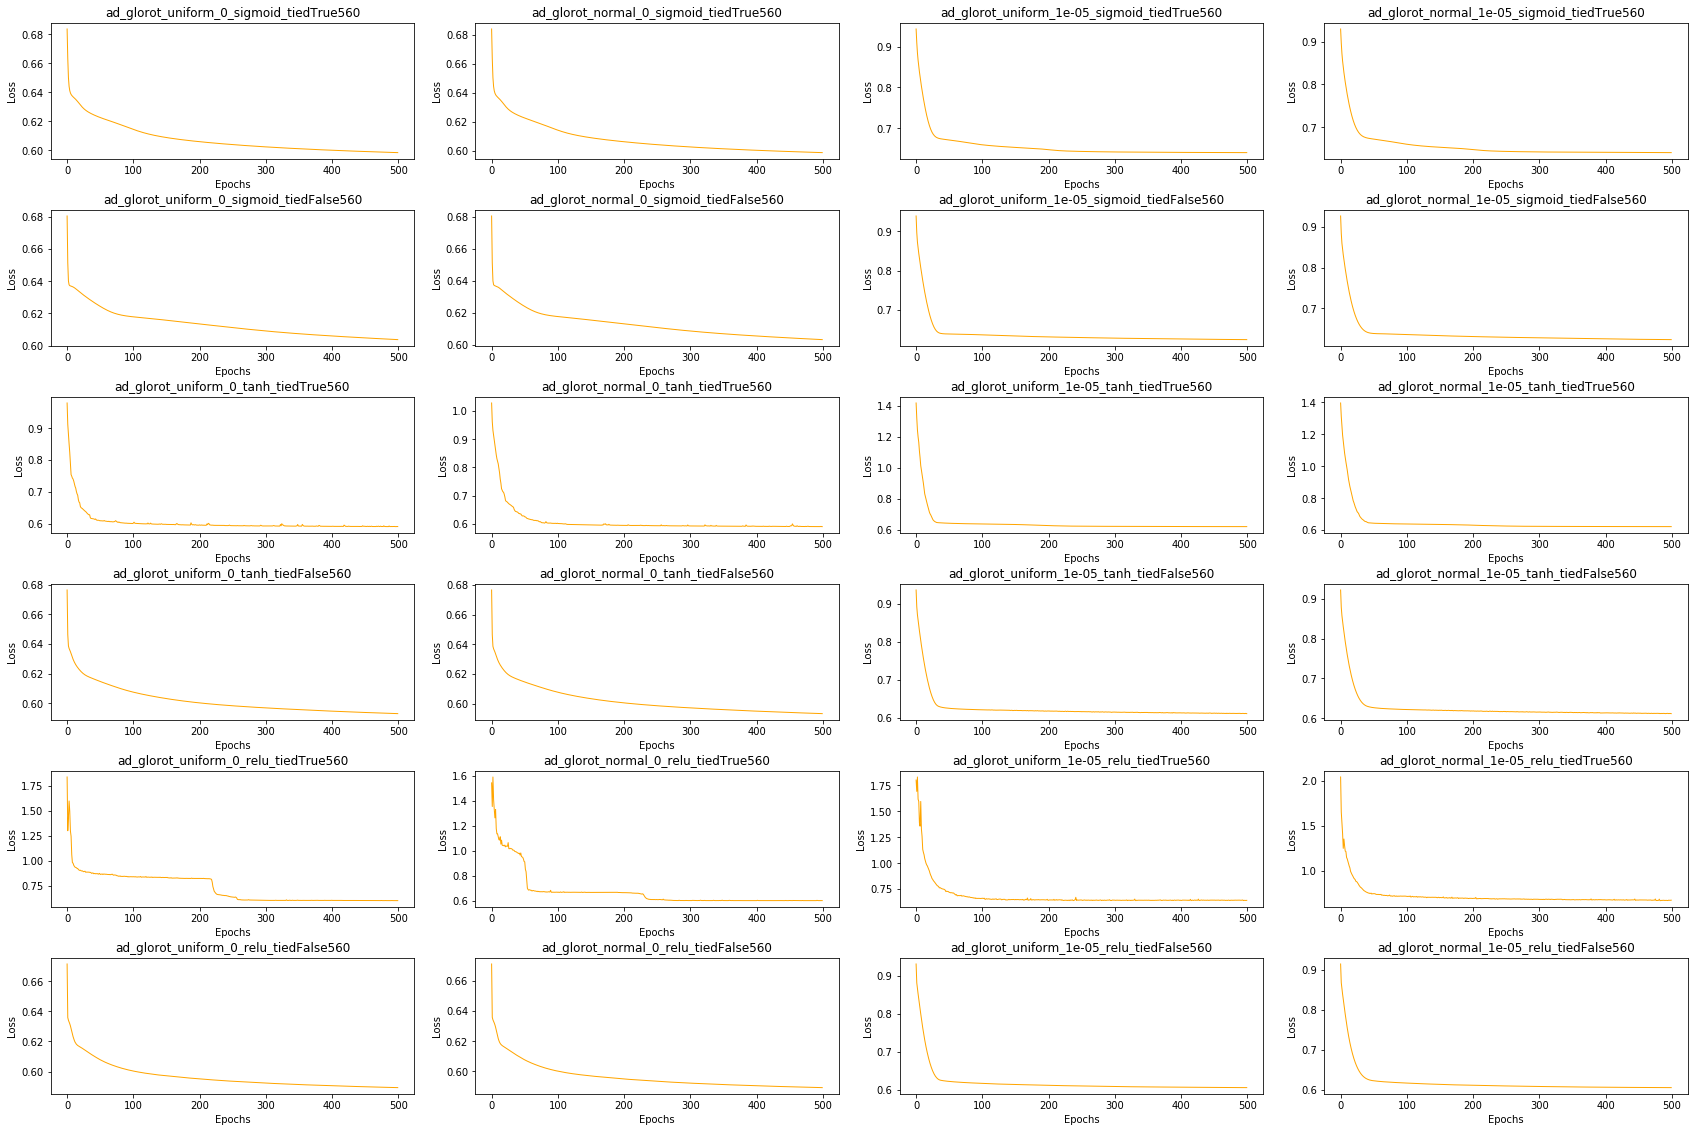

In [535]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict2[name]
                ax[xi,yi].plot(list(range(0,500)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
                ax[xi,yi].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
                xi = xi+1
        yi=yi+1


In [ ]:
fig.savefig('training_loss_array.png')

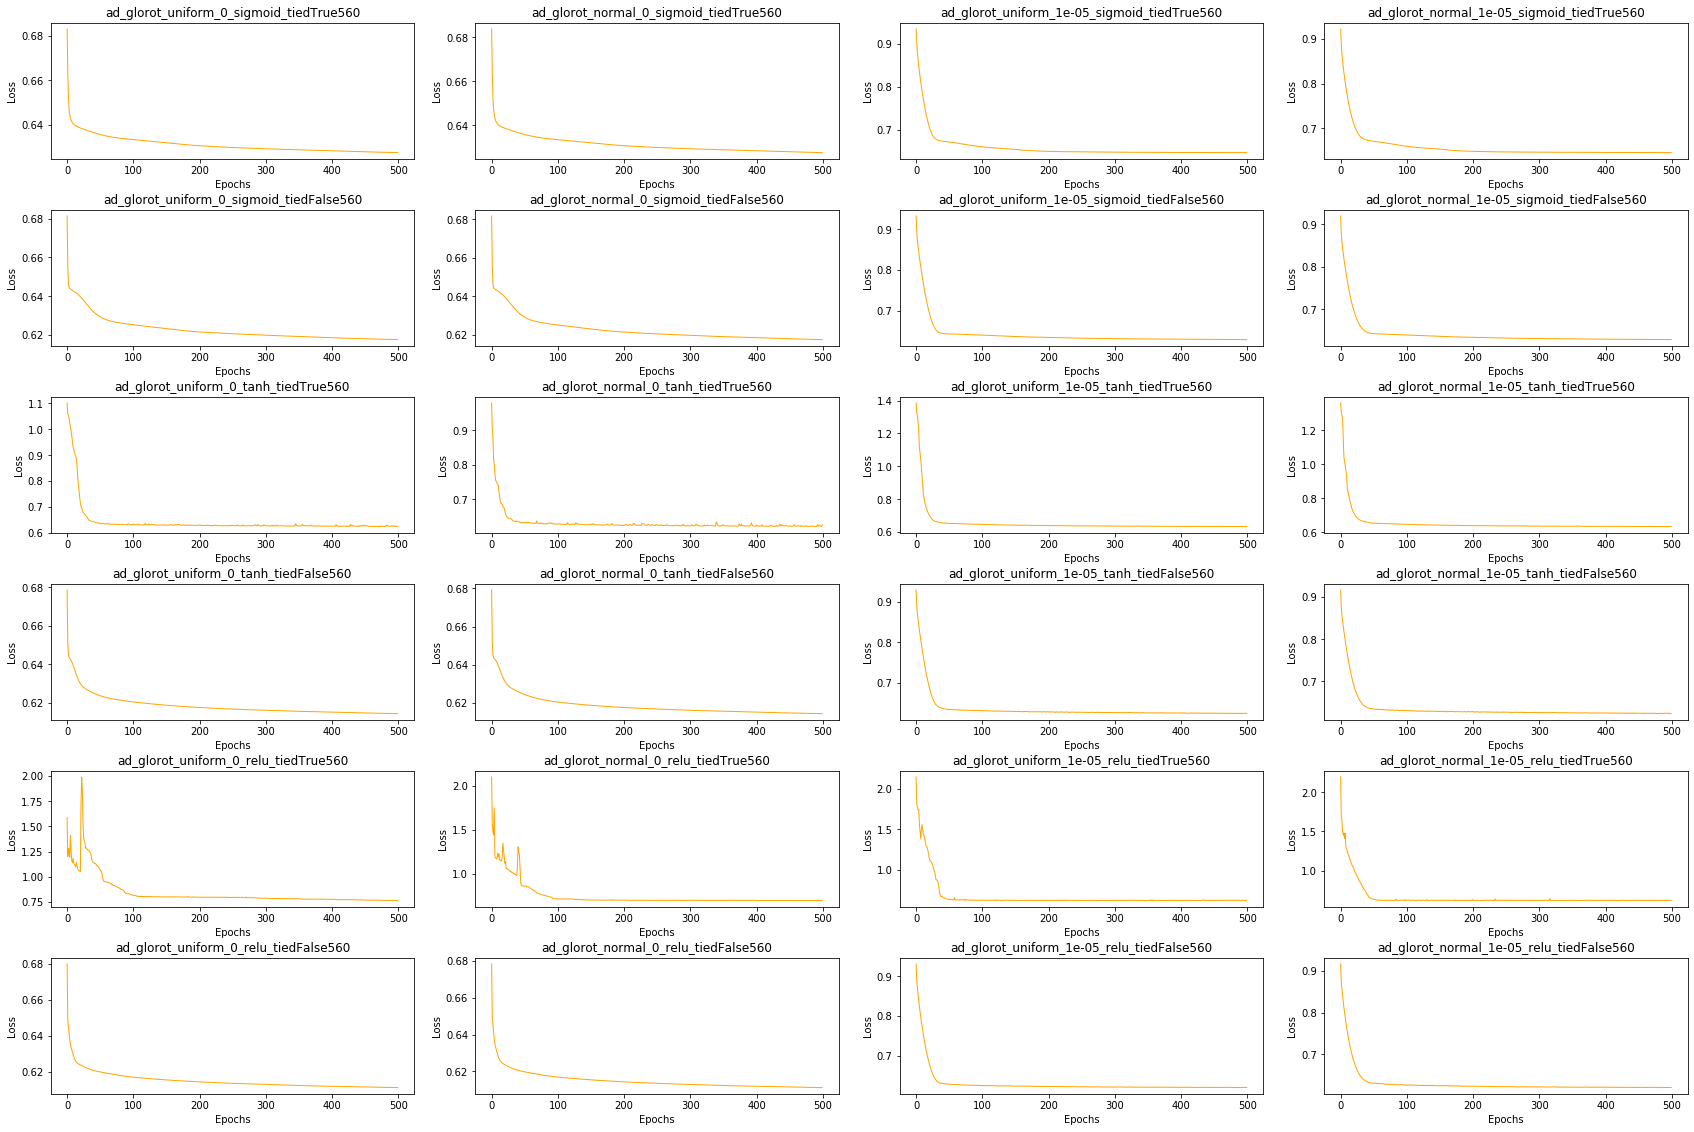

In [182]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict_seq2[name]
                ax[xi,yi].plot(list(range(0,500)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
                ax[xi,yi].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
                xi = xi+1
        yi=yi+1


In [ ]:
fig.savefig('training_loss_seq.png')

#### Node weight distributions

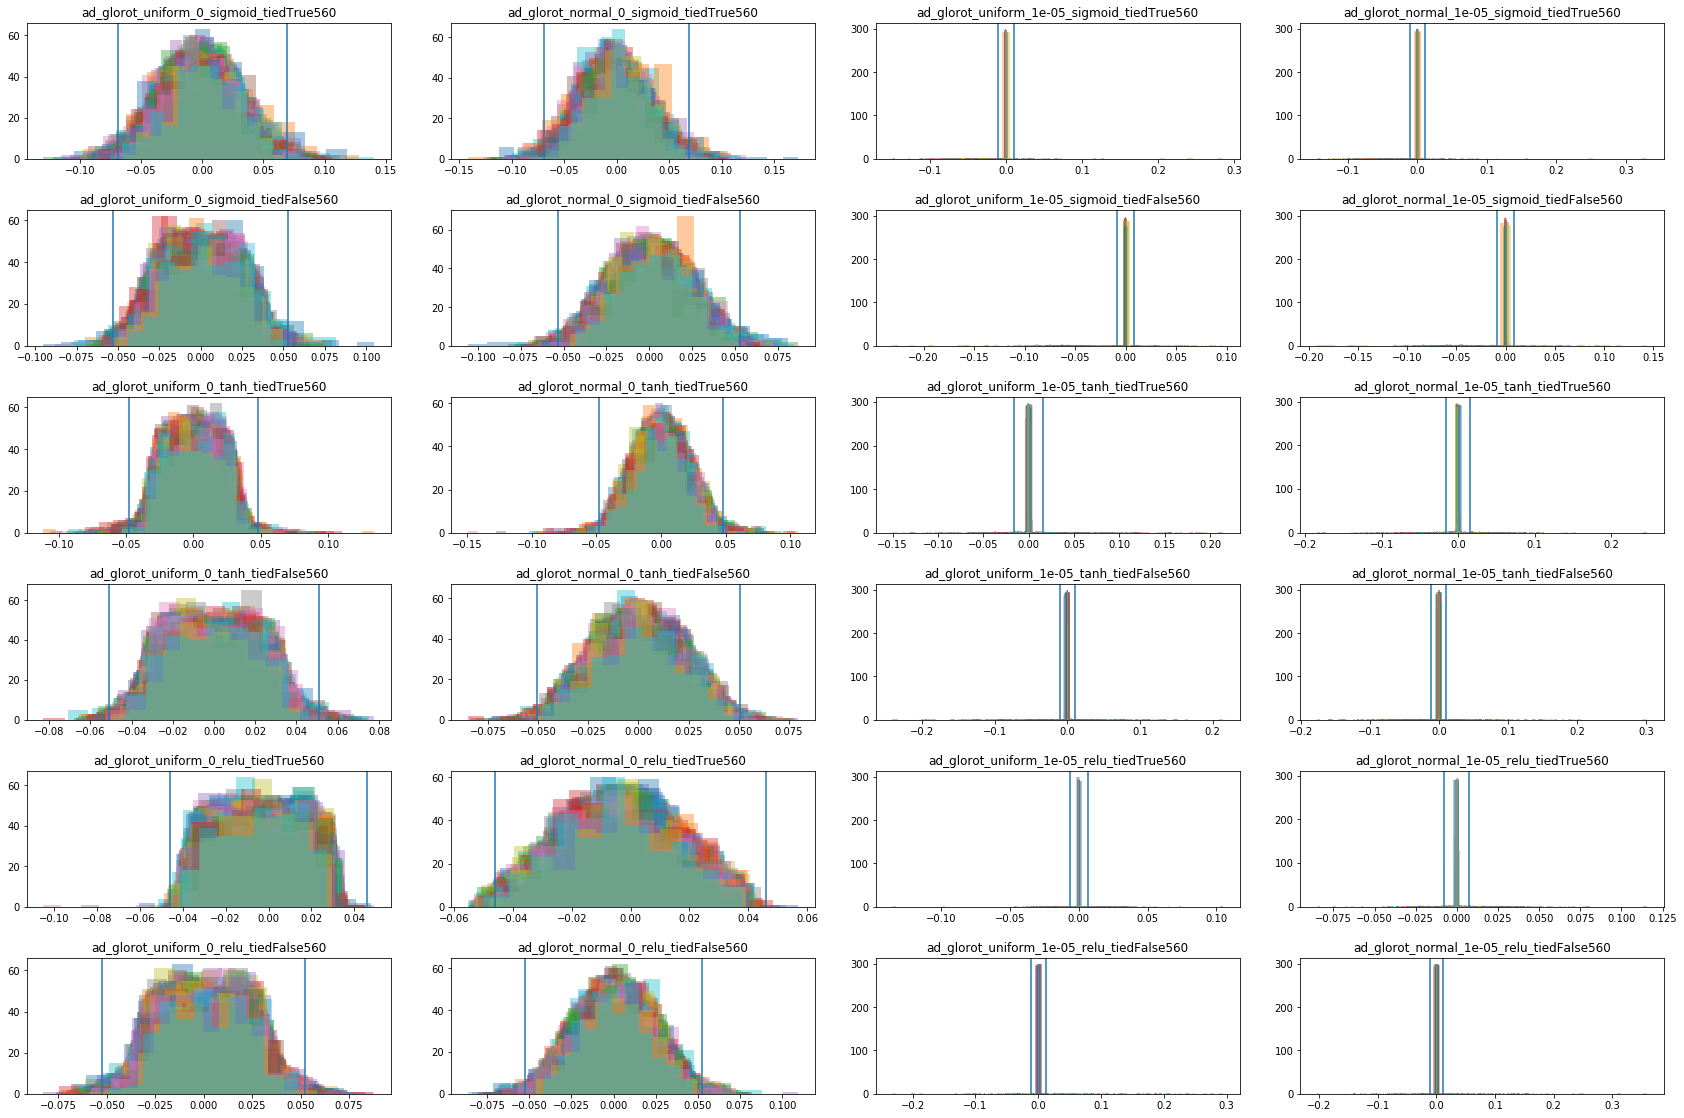

In [521]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict2[name]
                for node in range(0,300):
                    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
                        ax=ax[xi,yi],
                        hist=True,
                        kde=False,
                        rug=False)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*2.5)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*-2.5)
                ax[xi,yi].set(title = name)
                xi = xi+1
        yi=yi+1



In [522]:
fig.savefig('array_distributions_b10.png')

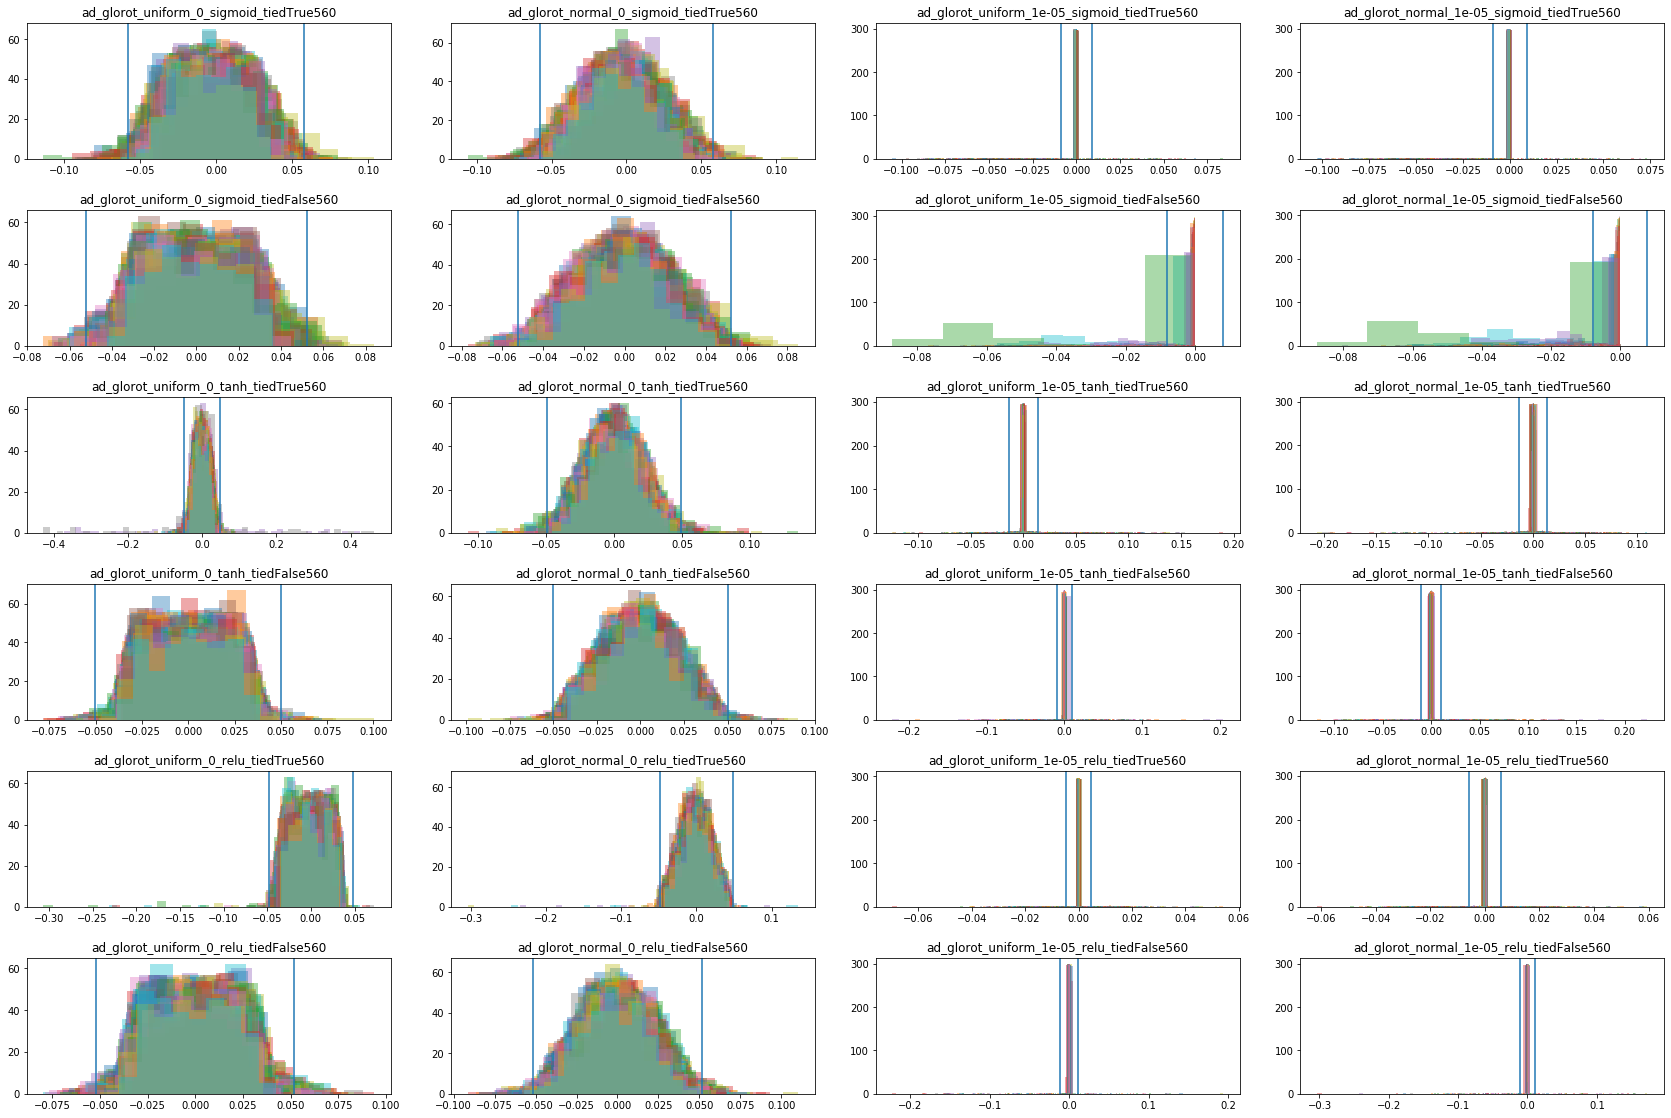

In [523]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict_seq2[name]
                for node in range(0,300):
                    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
                        ax=ax[xi,yi],
                        hist=True,
                        kde=False,
                        rug=False)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*2.5)
                ax[xi,yi].axvline(x = np.std(model_temp.weights)*-2.5)
                ax[xi,yi].set(title = name)
                xi = xi+1
        yi=yi+1



In [524]:
fig.savefig('seq_distributions_b10.png')

[Text(0.5, 1, 'ad_glorot_uniform_0_sigmoid_tiedTrue560')]

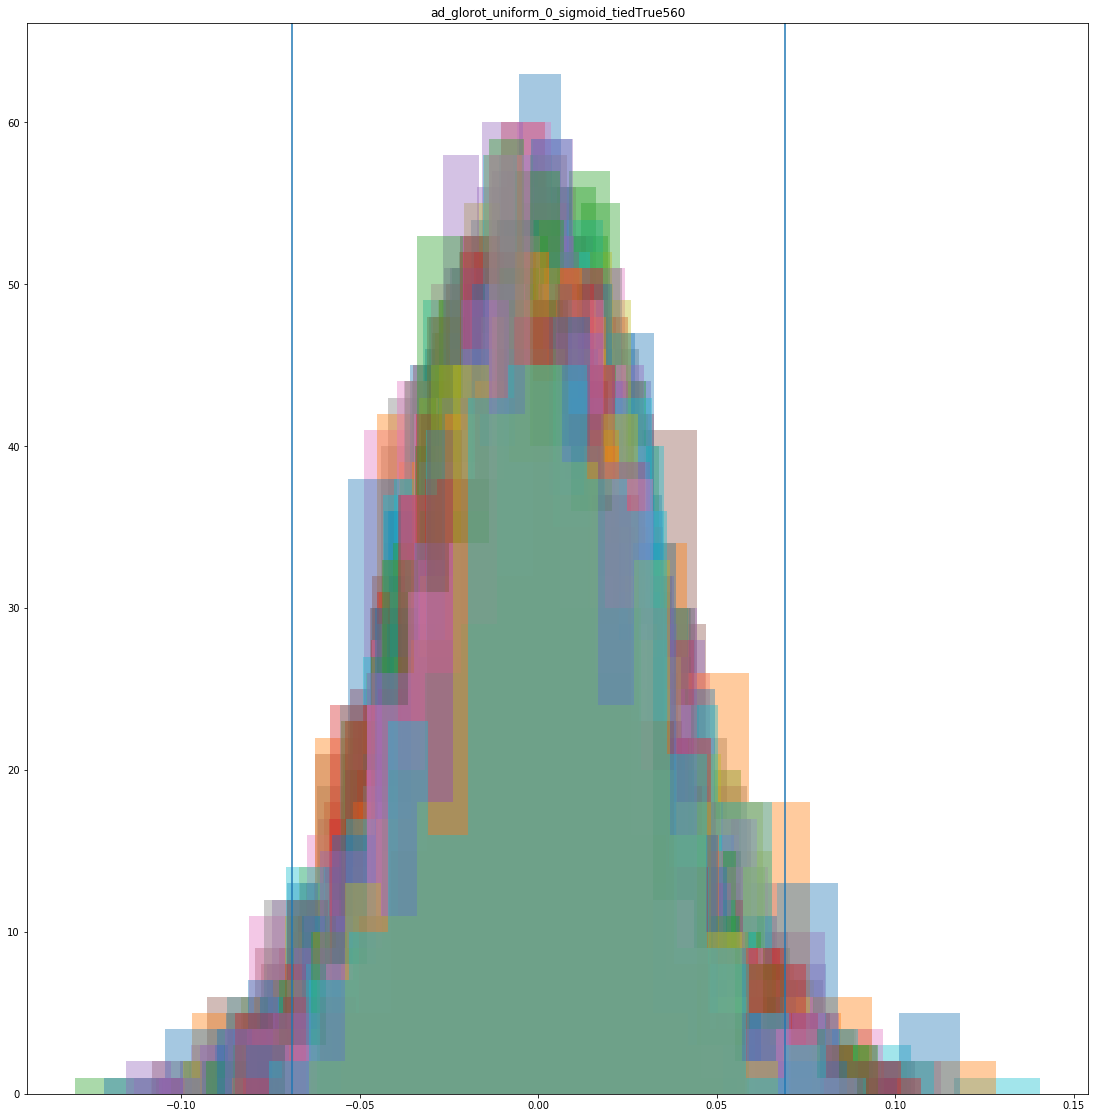

In [255]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*16 ,yd *16))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'ad_glorot_normal_1e-05_relu_tiedFalse560'
name = 'ad_glorot_uniform_0_sigmoid_tiedTrue560'
model_temp = model_dict2[name]
for node in range(0,300):
    sns.distplot(model_temp.weights[node], #[model_temp.weights[node] > 0],
    ax=ax,
    hist=True,
    kde=False,
    rug=False)
ax.axvline(x = np.std(model_temp.weights)*2.5)
ax.axvline(x = np.std(model_temp.weights)*-2.5)
ax.set(title = name)
#ax.set_yscale('log')



#### HWG signature sizes

In [258]:
(model_dict2['tf_adage'].weights > np.std(model_dict2['tf_adage'].weights, axis=0)*2.5).shape

(5549, 300)

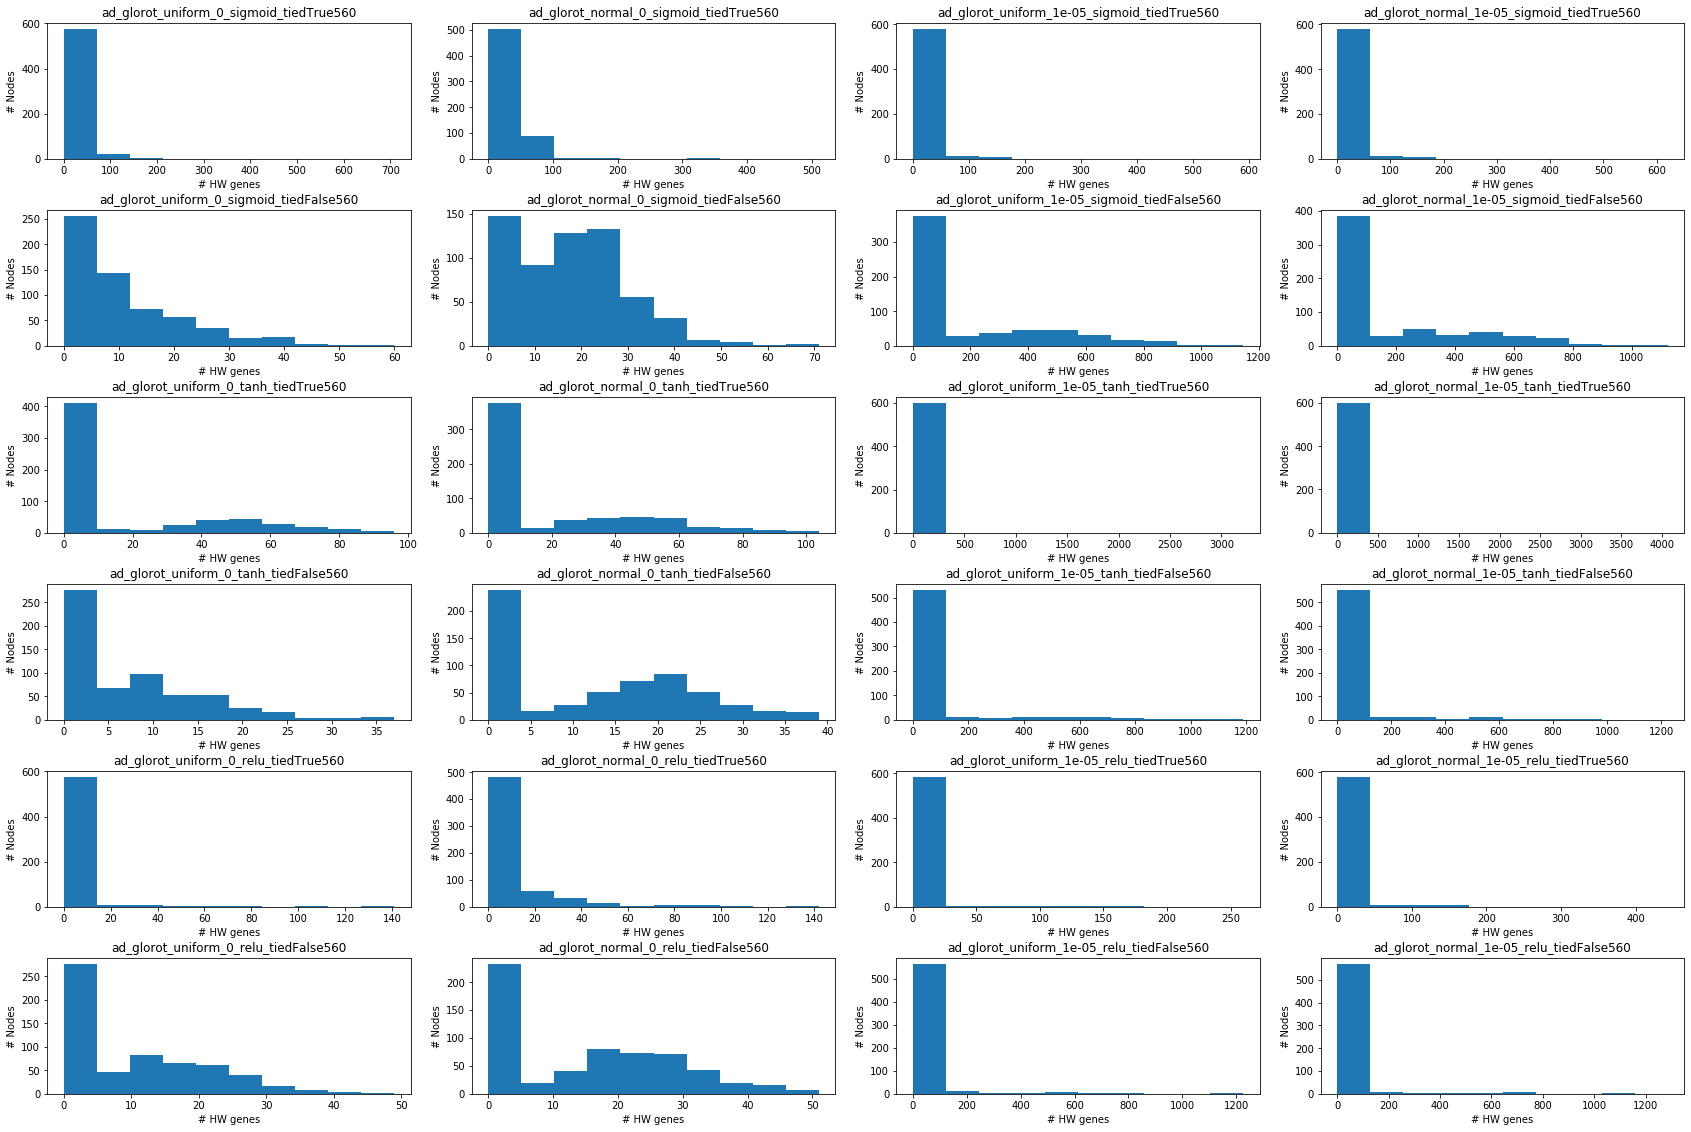

In [257]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict3[name]
                ax[xi,yi].hist(model_temp.hw_genes_all.sum(0))
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                xi = xi+1
        yi=yi+1



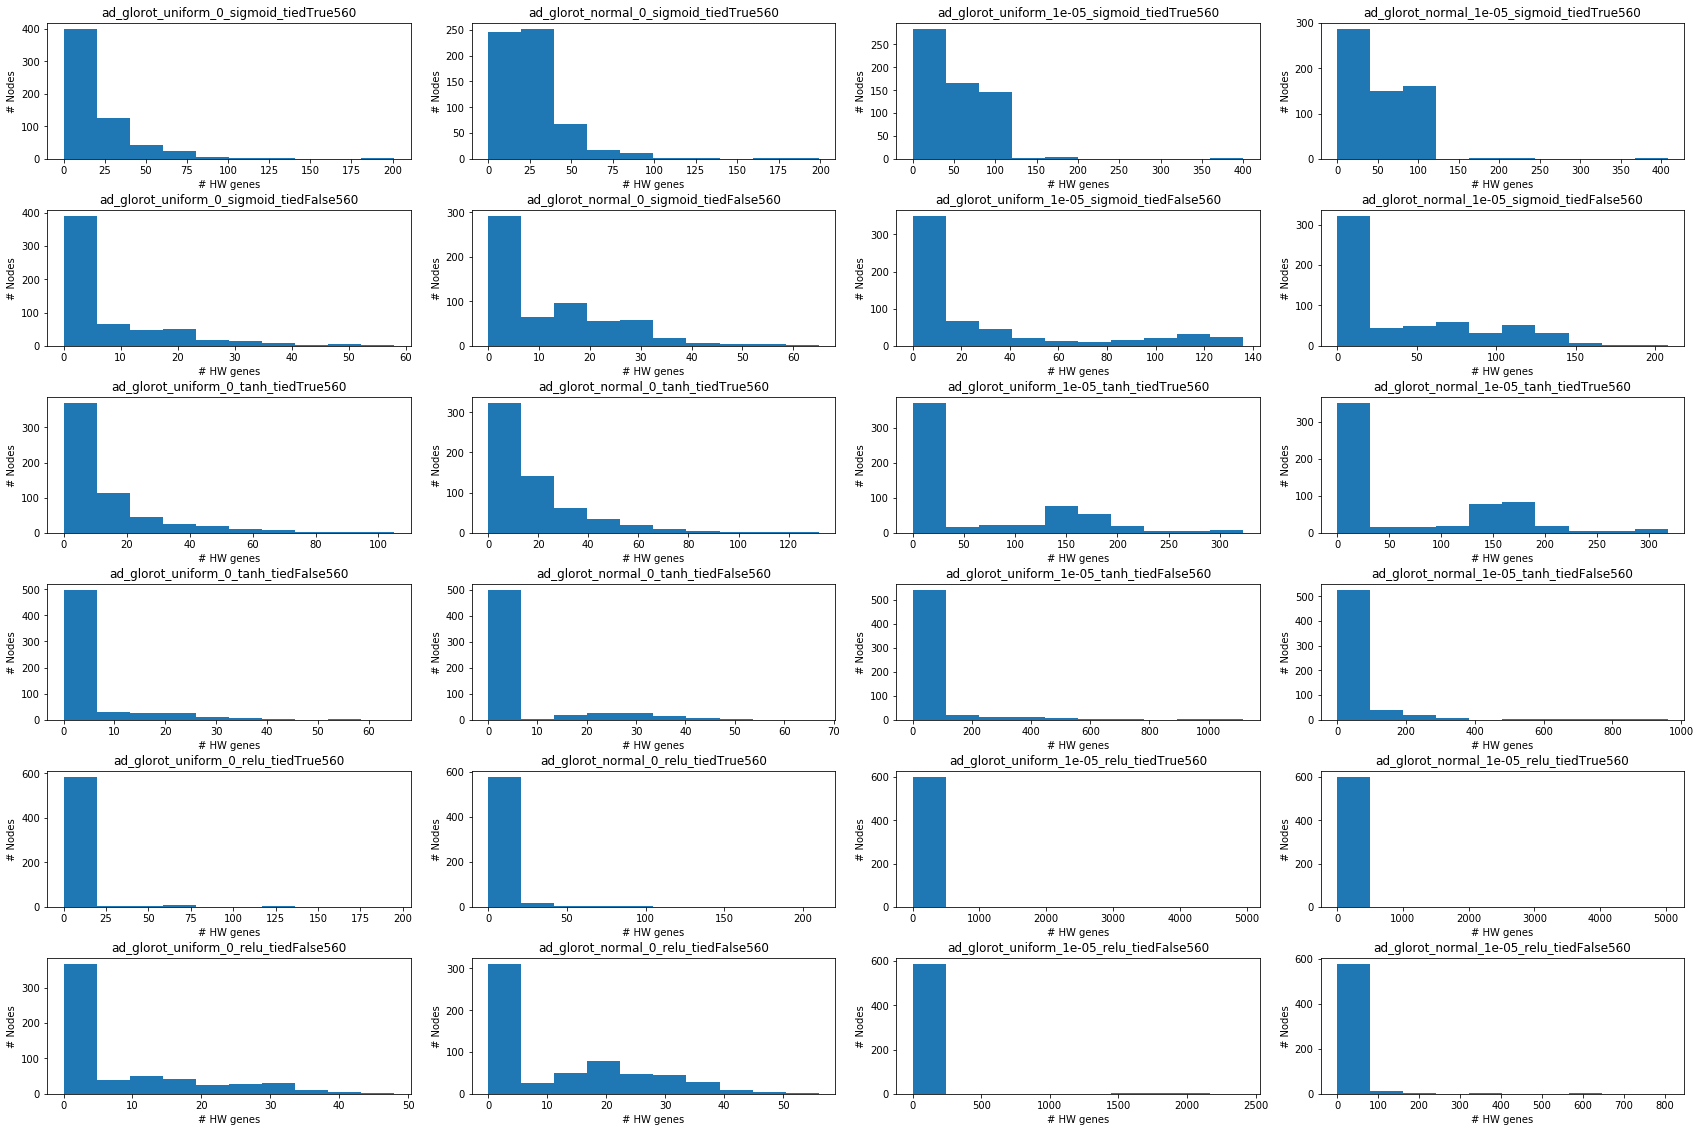

In [259]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict_seq3[name]
                ax[xi,yi].hist(model_temp.hw_genes_all.sum(0))
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                xi = xi+1
        yi=yi+1



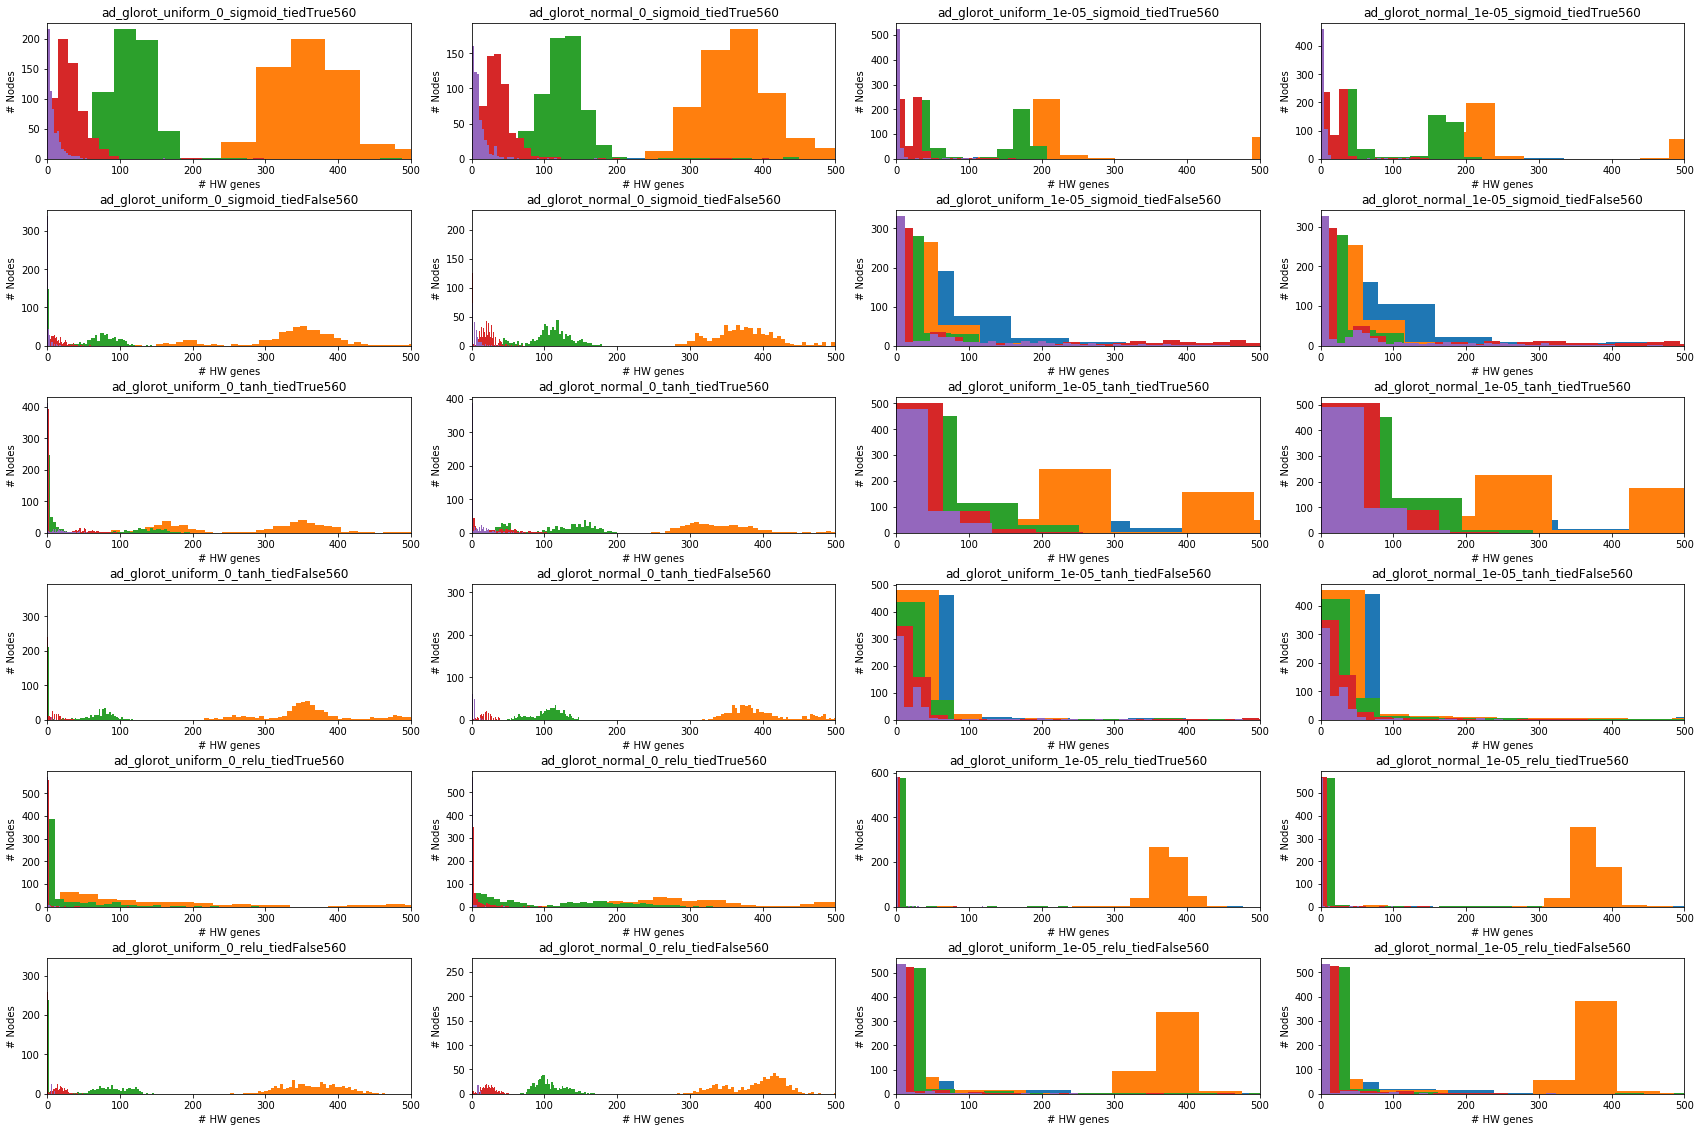

In [426]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict3[name]
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                #ax[xi,yi].set_xscale('log')
                #for c in [1.75,2,2.25,2.5]:
                for c in [1.0,1.5,2.0,2.5,3.0]:
                    model_temp.set_hwg_cutoff(c)
                    ax[xi,yi].hist(model_temp.hw_genes_all.sum(0), bins=50)
                    ax[xi,yi].set_xlim([0,500])

                xi = xi+1
        yi=yi+1

In [427]:
fig.savefig('sig_sizes_by_hw_cutoff_array_xlim500.png')

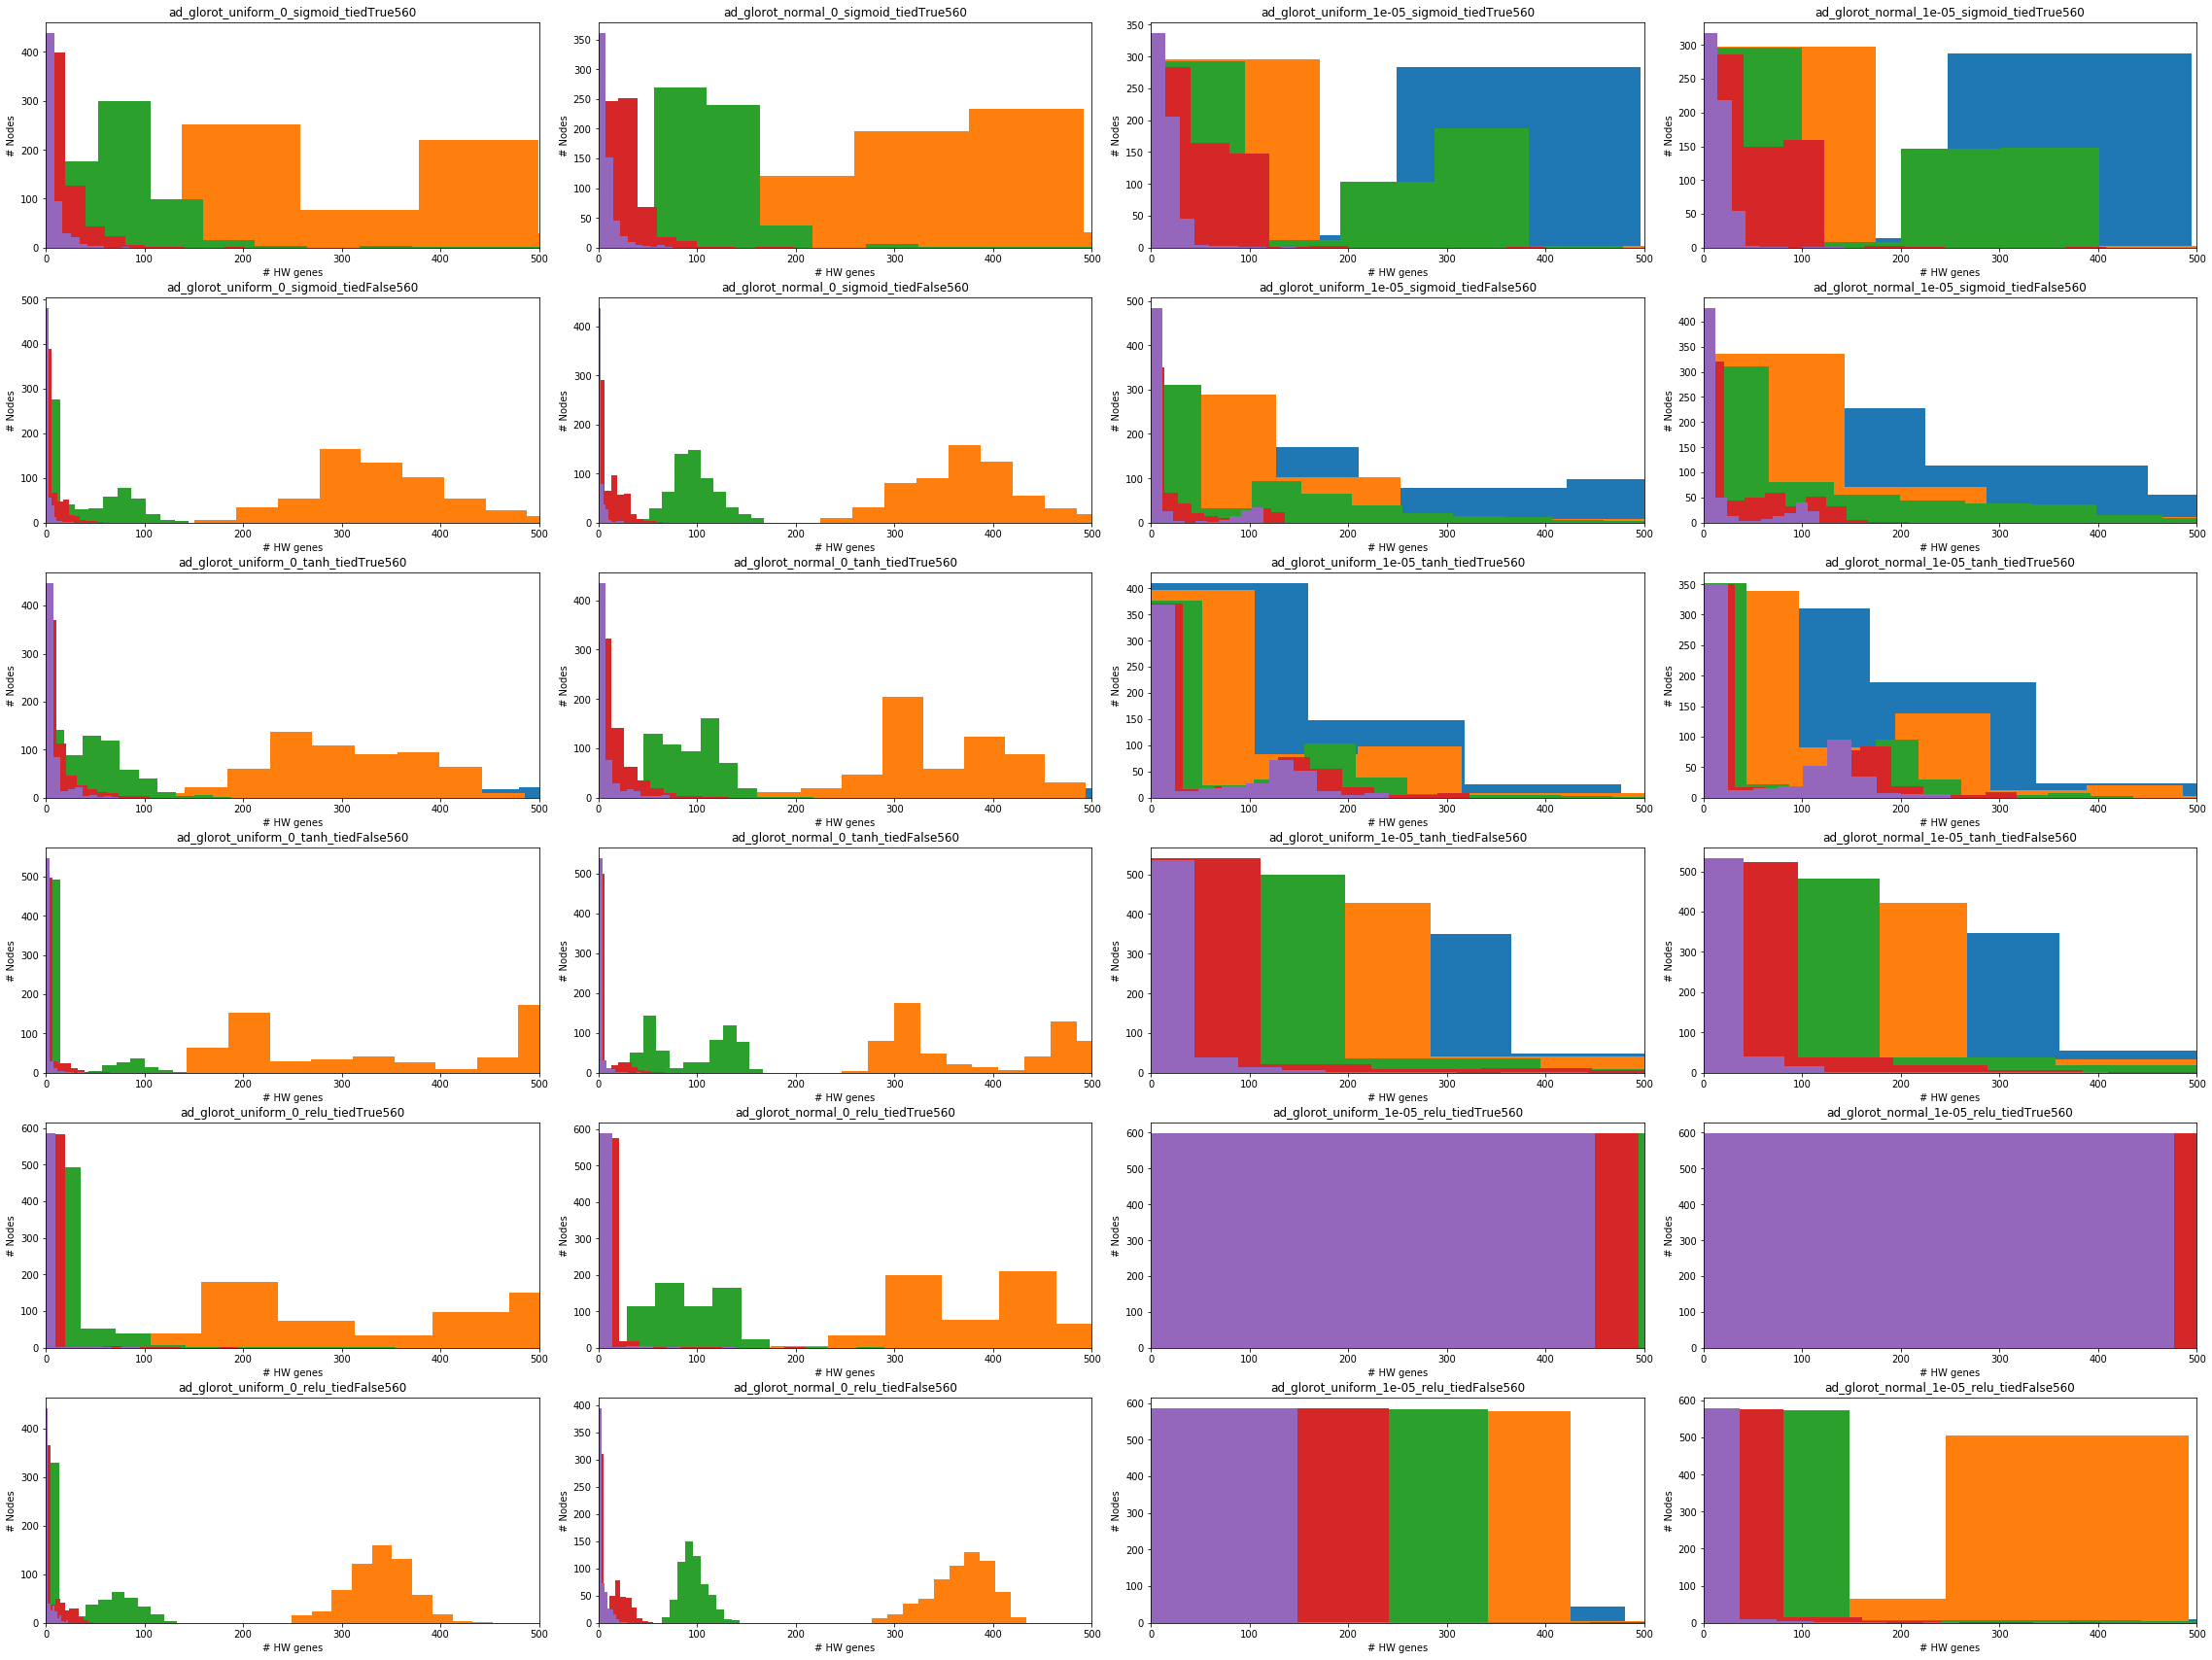

In [428]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(yd*8 ,xd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict_seq3[name]
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                #ax[xi,yi].set_xscale('log')
                #for c in [1.75,2,2.25,2.5]:
                #for c in [3.0,2.5,2.0,1.5,1.0]:
                for c in [1.0,1.5,2.0,2.5,3.0]:
                    model_temp.set_hwg_cutoff(c)
                    ax[xi,yi].hist(model_temp.hw_genes_all.sum(0)) #, bins=50
                    ax[xi,yi].set_xlim([0,500])

                xi = xi+1
        yi=yi+1

In [423]:
fig.savefig('sig_sizes_by_hw_cutoff_seq.png')

[Text(45.125, 0.5, '# Nodes'),
 Text(0.5, 15.0, '# HW genes'),
 Text(0.5, 1, 'tf_adage')]

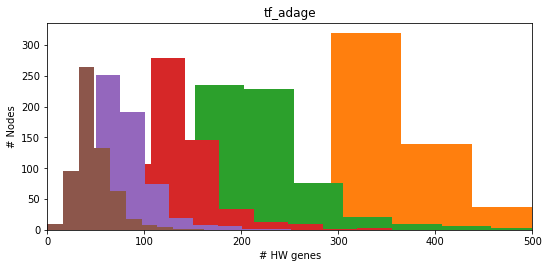

In [300]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'tf_adage'
model_temp = model_dict[name]
for c in [1,1.5,1.75,2,2.25,2.5]:
    model_temp.set_hwg_cutoff(c)
    ax.hist(model_temp.hw_genes_all.sum(0))
    ax.set_xlim([0,500])
ax.set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
#ax.set_yscale('log')



[Text(45.125, 0.5, '# HWGs'),
 Text(0.5, 15.0, 'Cutoff'),
 Text(0.5, 1, 'ad_glorot_normal_0_tanh_tiedTrue560')]

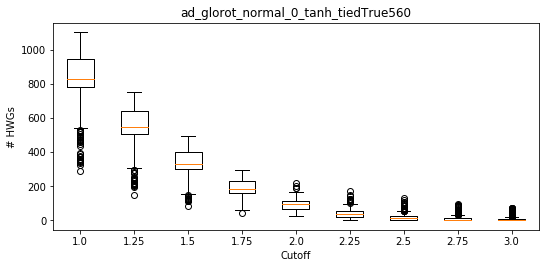

In [409]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
                #print(name)
name = 'tf_adage'
name = 'ad_glorot_normal_0_tanh_tiedTrue560'
model_temp = model_dict_seq3[name]
hwgs = []
for c in [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0]:
    hwgs_temp = model_temp.set_hwg_cutoff(c)
    hwgs.append(model_temp.hw_genes_all.sum(0))
    
ax.boxplot(hwgs, labels = [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])

ax.set(title = name, xlabel = 'Cutoff', ylabel = '# HWGs')
#ax.set_yscale('log')

[Text(45.125, 0.5, '# KEGG / Node'),
 Text(0.5, 15.0, 'Cutoff'),
 Text(0.5, 1, 'ad_glorot_normal_0_tanh_tiedTrue560')]

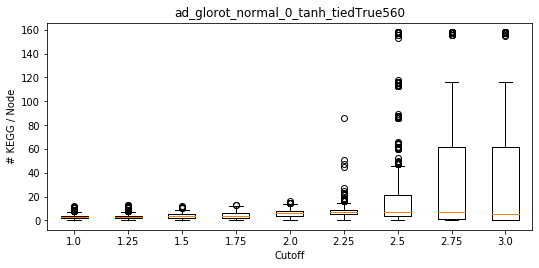

In [410]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)



plim=5
name = 'tf_adage'
name = 'ad_glorot_normal_0_tanh_tiedTrue560'
model_temp = model_dict_seq3[name]
hwgs = []
for c in [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0]:
    hwgs_temp = model_temp.set_hwg_cutoff(c)
    model_temp.set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    en_temp = (model_temp.kegg_ps > plim).sum(1)
    hwgs.append(en_temp)
    
ax.boxplot(hwgs, labels = [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])

ax.set(title = name, xlabel = 'Cutoff', ylabel = '# KEGG / Node')
#ax.set_yscale('log')

In [ ]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)



plim=5
name = 'tf_adage'
name = 'ad_glorot_normal_0_tanh_tiedTrue560'
model_temp = model_dict_seq3[name]
hwgs = []
for c in [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0]:
    hwgs_temp = model_temp.set_hwg_cutoff(c)
    model_temp.set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    en_temp = (model_temp.kegg_ps > plim).sum(1)
    hwgs.append(en_temp)
    
ax.boxplot(hwgs, labels = [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])

ax.set(title = name, xlabel = 'Cutoff', ylabel = '# KEGG / Node')
#ax.set_yscale('log')

[Text(45.125, 0.5, '# KEGG / Node'),
 Text(0.5, 15.0, 'Cutoff'),
 Text(0.5, 1, 'ad_glorot_uniform_0_sigmoid_tiedTrue560')]

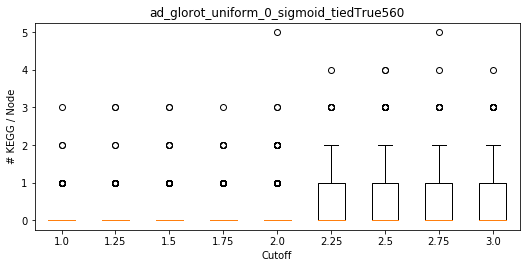

In [355]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
#print(name)
plim=10
name = 'ad_glorot_uniform_0_sigmoid_tiedTrue560'
model_temp = model_dict_seq3[name]
hwgs = []
for c in [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0]:
    hwgs_temp = model_temp.set_hwg_cutoff(c)
    model_temp.set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    en_temp = (model_temp.kegg_ps > plim).sum(1)
    hwgs.append(en_temp)
    
ax.boxplot(hwgs, labels = [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])

ax.set(title = name, xlabel = 'Cutoff', ylabel = '# KEGG / Node')
#ax.set_yscale('log')

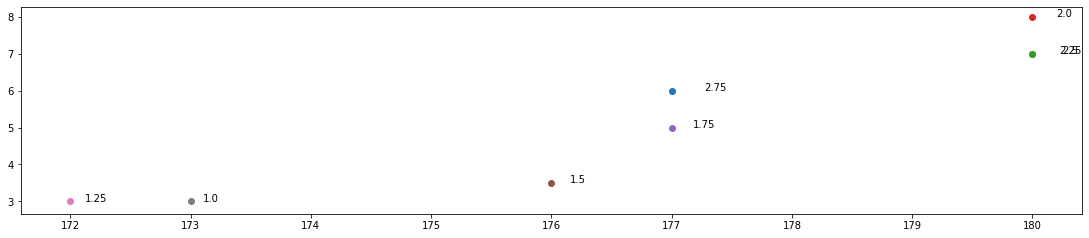

In [414]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*16 ,yd *4))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
#print(name)
plim=5
name = 'ad_glorot_uniform_0_sigmoid_tiedTrue560'
name = 'ad_glorot_uniform_0_tanh_tiedTrue560'
model_temp = model_dict_seq3[name]
hwgs = []
for c in [2.75,2.5,2.25,2.0, 1.75,1.5, 1.25, 1.0]:
    hwgs_temp = model_temp.set_hwg_cutoff(c)
    model_temp.set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    en_temp = (model_temp.kegg_ps > plim).sum(1)
    hwgs.append(en_temp)
    kegg_per_med = (model_temp.kegg_ps > plim).sum(1).median()
    all_kegg = ((model_temp.kegg_ps > plim).sum(0) > 0).sum()
    ax.scatter(x = all_kegg , y = kegg_per_med)
    ax.text(x = all_kegg+(c/10), y = kegg_per_med,s = str(c))
               

               #ax.hist(hwgs, label = [2.75,2.5,2.25,2.0])
#ax.legend(prop={'size': 10})
    
#ax.boxplot(hwgs, labels = [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])

#ax.set(title = name, xlabel = 'Cutoff', ylabel = '# KEGG / Node')
#ax.set_yscale('log')

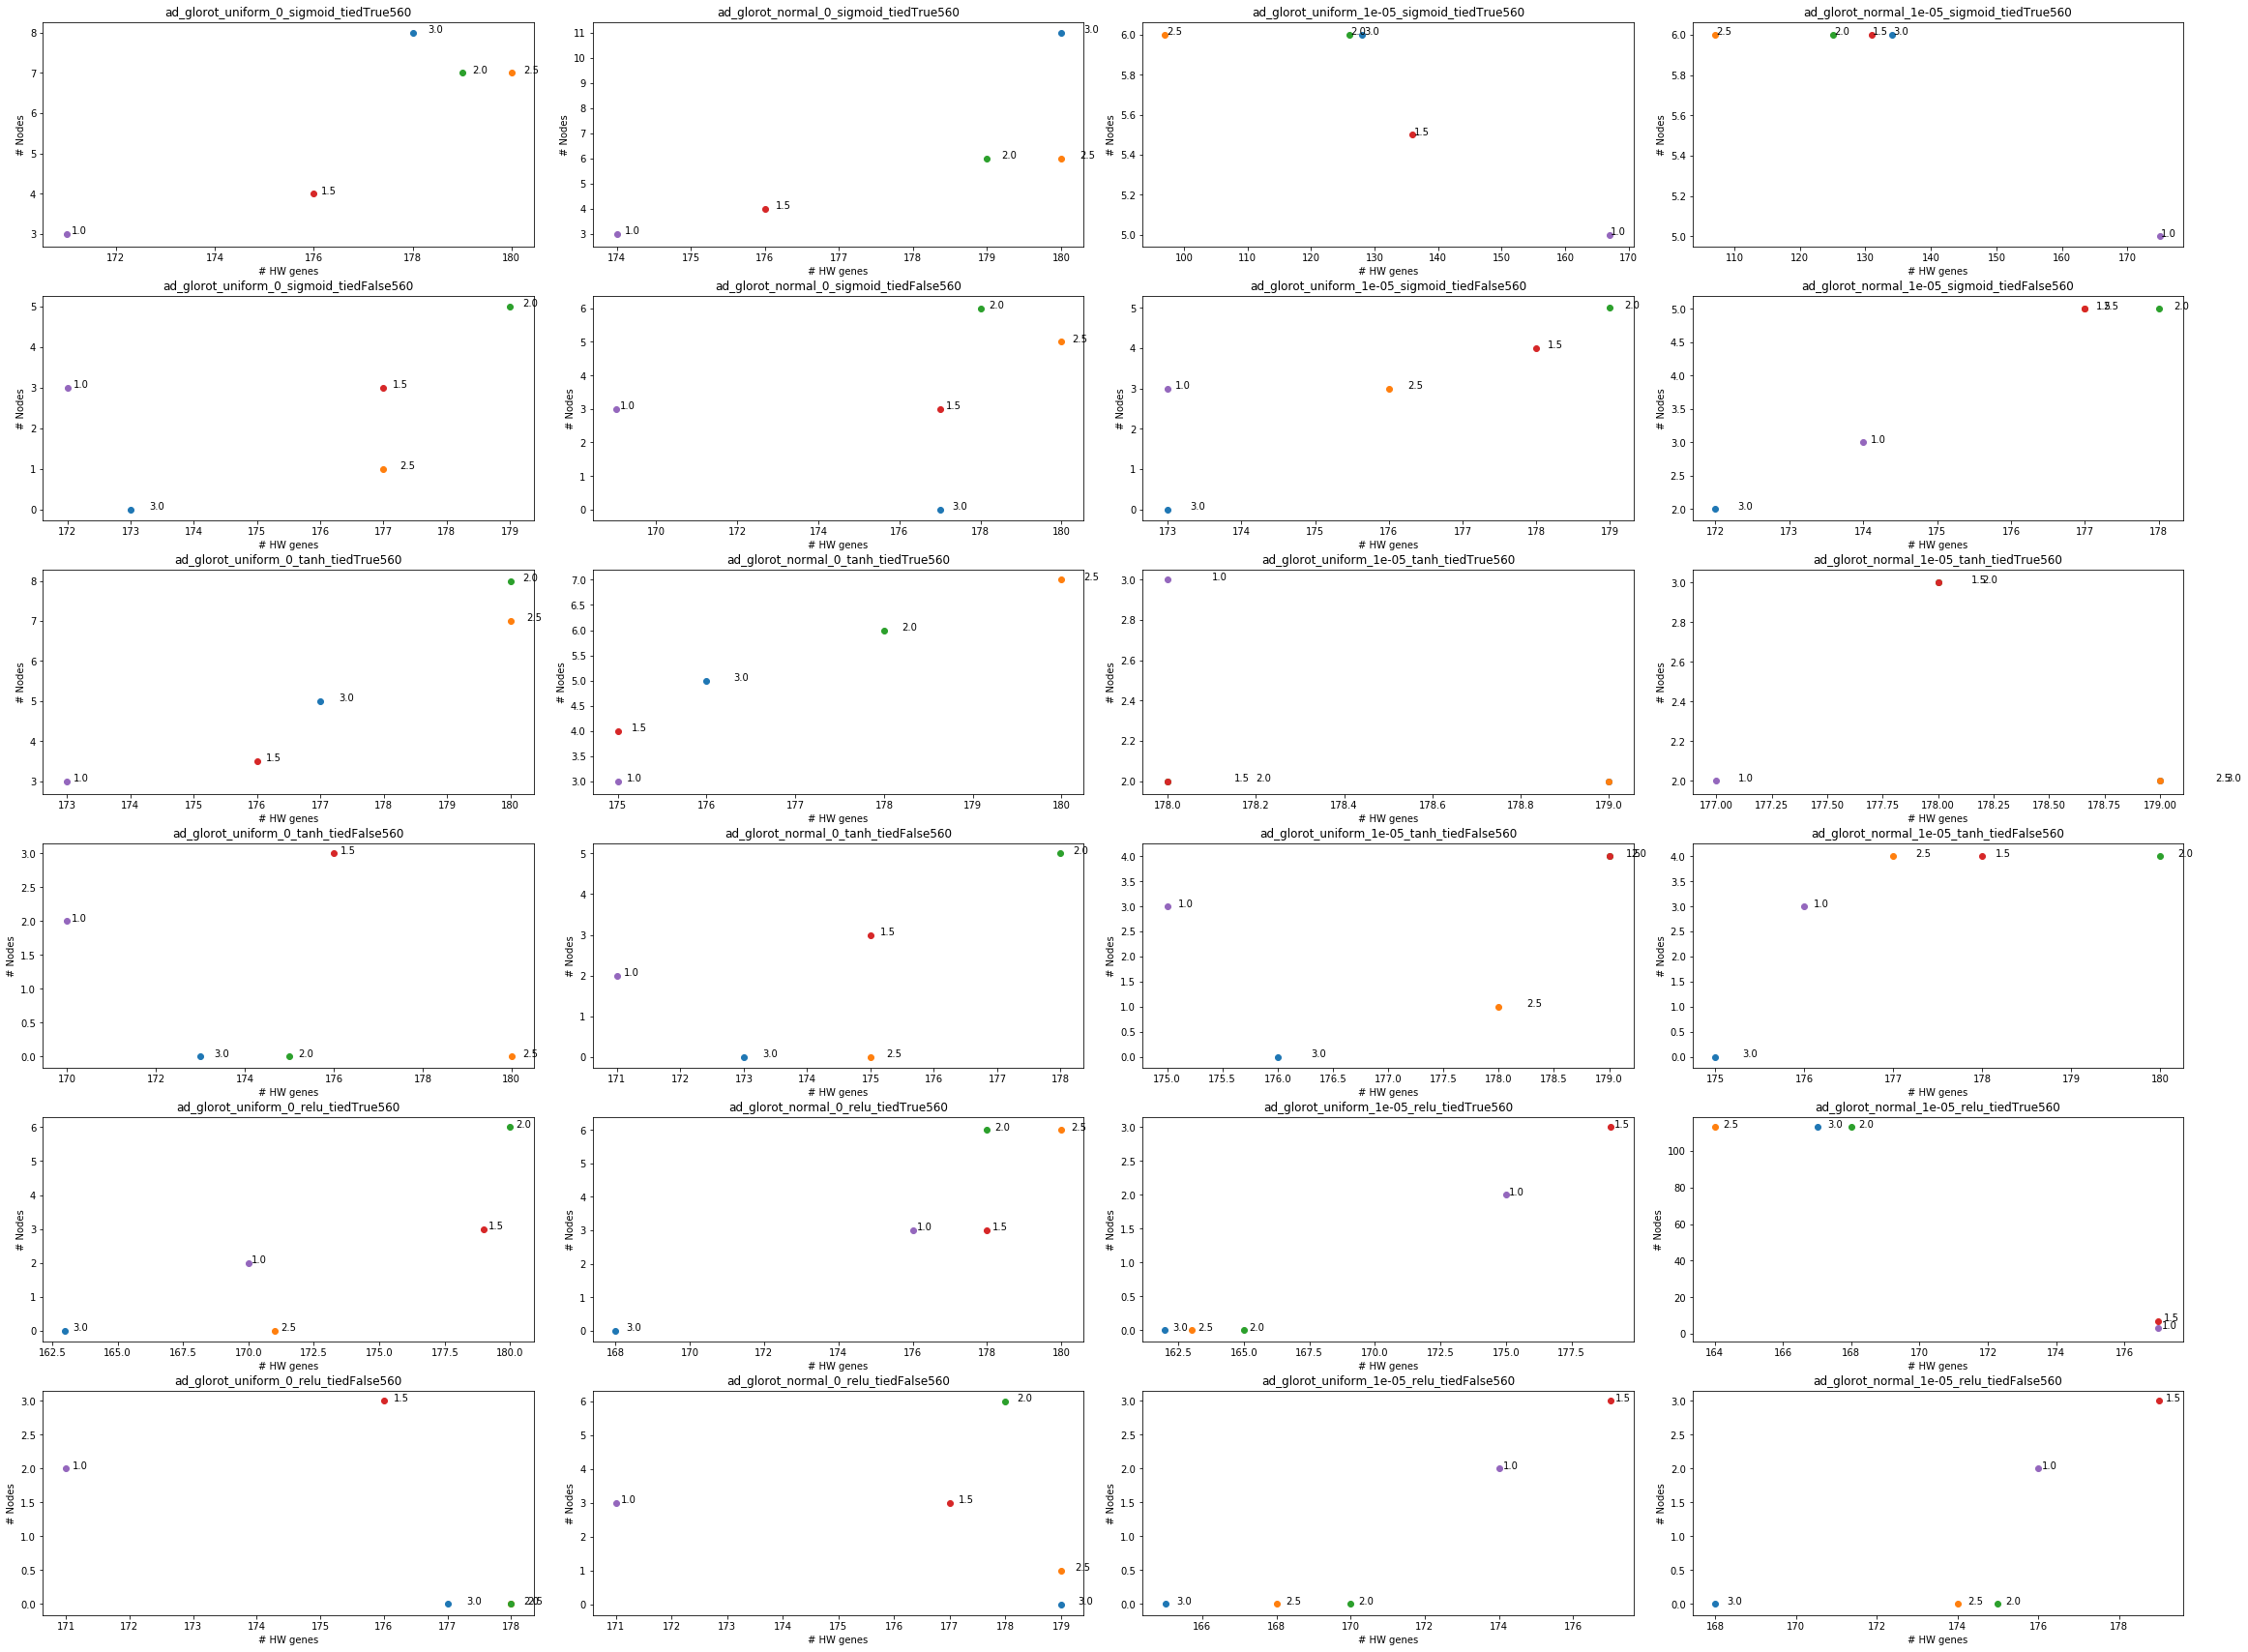

In [415]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(yd*8 ,xd *4))
fig.tight_layout(pad=3.0)
plim = 5
xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(560)
                #print(name)
                model_temp = model_dict_seq3[name]
                ax[xi,yi].set(title = name, xlabel = '# HW genes', ylabel = '# Nodes')
                #ax[xi,yi].set_xscale('log')
                #for c in [1.75,2,2.25,2.5]:
                hwgs = []
                for c in [3.0,2.5,2.0,1.5,1.0]:
                    hwgs_temp = model_temp.set_hwg_cutoff(c)
                    model_temp.set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
                    en_temp = (model_temp.kegg_ps > plim).sum(1)
                    hwgs.append(en_temp)
                    kegg_per_med = (model_temp.kegg_ps > plim).sum(1).median()
                    all_kegg = ((model_temp.kegg_ps > plim).sum(0) > 0).sum()
                    ax[xi,yi].scatter(x = all_kegg , y = kegg_per_med)
                    ax[xi,yi].text(x = all_kegg+(c/10), y = kegg_per_med,s = str(c))

                xi = xi+1
        yi=yi+1

In [416]:
fig.savefig('kegg_en_by_hw_cutoff_seq.png')

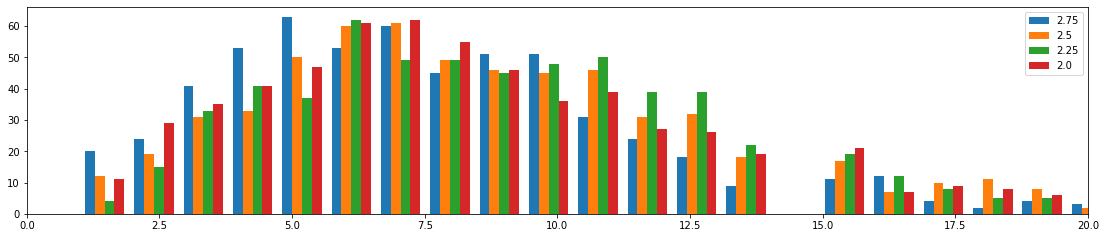

In [342]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*16 ,yd *4))
fig.tight_layout(pad=3.0)
ax.hist(hwgs,bins = 100, label = [2.75,2.5,2.25,2.0])
ax.set_xlim([0,20])
ax.legend(prop={'size': 10})

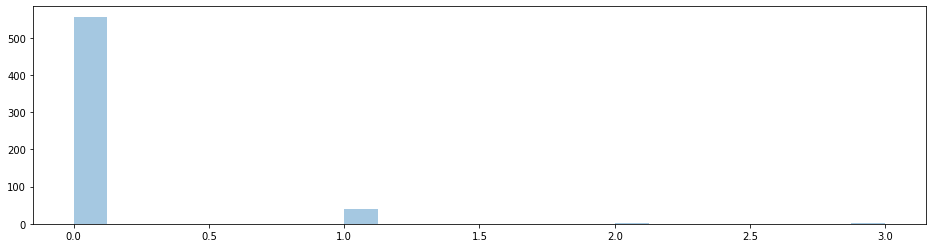

In [385]:
fig, ax = plt.subplots(xd, yd,figsize=(xd*16 ,yd *4))
sns.distplot(hwgs[0], ax=ax, kde=False)

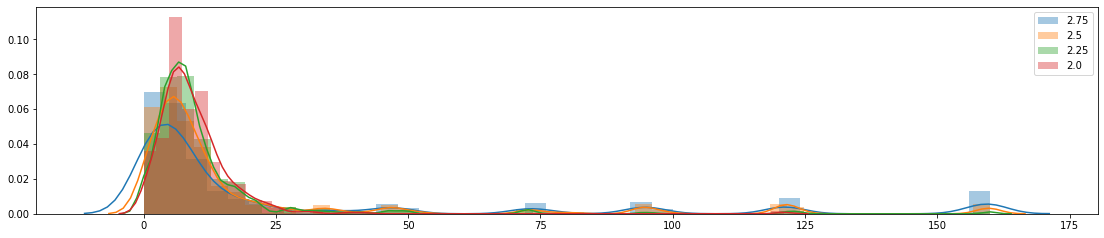

In [400]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*16 ,yd *4))
fig.tight_layout(pad=3.0)
for n in range(4):
    sns.distplot(hwgs[n], label = [2.75,2.5,2.25,2.0][n], #[model_temp.weights[node] > 0],
    ax=ax,
    hist=True,
    kde=True
)
ax.legend()
#ax.axvline(x = np.std(model_temp.weights)*2.5)
#ax.axvline(x = np.std(model_temp.weights)*-2.5)
#ax.set(title = name)

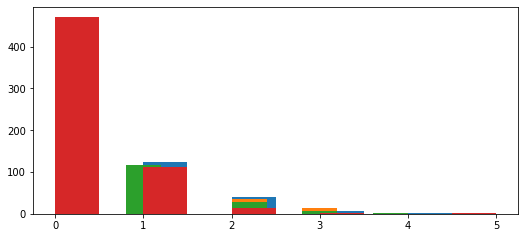

In [321]:
yd = 1 #len(inits) * len(L1_norm)
xd = 1 #len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*8 ,yd *4))
fig.tight_layout(pad=3.0)


name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + str(460)
#print(name)
plim=10
name = 'ad_glorot_uniform_0_sigmoid_tiedTrue560'
model_temp = model_dict_seq3[name]
hwgs = []
for c in [2.75,2.5,2.25,2.0]:
    hwgs_temp = model_temp.set_hwg_cutoff(c)
    model_temp.set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    ax.hist((model_temp.kegg_ps > plim).sum(1))
    
#ax.boxplot(hwgs, labels = [1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])

#ax.set(title = name, xlabel = 'Cutoff', ylabel = '# KEGG / Node')
#ax.set_yscale('log')

In [333]:
(model_dict['tf_adage'].kegg_ps > 10).sum(1)[(model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0]

TypeError: '>' not supported between instances of 'list' and 'int'

In [305]:

model_dict['tf_adage'].set_hwg_cutoff(2.5)
model_dict['tf_adage'].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt')
((model_dict['tf_adage'].kegg_ps > 10).sum(1) > 0).sum()

334

#### Enrichments

In [ ]:
for m in model_dict:
    model_dict[m].set_hwg_cutoff(2.5)
    #model_dict[m].set_kegg('node_interpretation/operons_format.txt')
    model_dict[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    #model_dict[m].set_go('node_interpretation/regulons_format.txt')
  

##### Summary Fig

In [ ]:
plim = 30

fig, ax = plt.subplots(1,1,figsize=(xd*4 ,yd *4))
x = ((model_dict['tf_adage'].go_ps > plim).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plim).sum(1) > 0).sum()
ax.scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(10):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict[name]
                    x = ((model_temp.go_ps > plim).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plim).sum(1) > 0).sum()
                    ax.scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    ax.set(title = m, xlabel = '# Regulons', ylabel = '# Nodes')

                    #xi = xi+1
                ec='red'
            mi = mi+1
        s=500
    c = 'grey'

##### Details

In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for i in inits:
    for l in L1_norm:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].hist((model_temp.kegg_ps > 10).sum(0))
                ax[xi,yi].set(title = name, xlabel = '# Nodes per Pathway', ylabel = '# Pathways')
                xi = xi+1
        yi=yi+1





In [ ]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(tied)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for i in inits:
    for l in L1_norm:
        xi = 0
        for a in act_fun:
            for t in tied:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                #print(name)
                model_temp = model_dict[name]
                ax[xi,yi].hist((model_temp.kegg_ps > 10).sum(1))
                ax[xi,yi].set(title = name, xlabel = '# Pathways in Node', ylabel = '# Nodes')
                xi = xi+1
        yi=yi+1


### Write out HWG lists

In [276]:
for m in model_dict_seq3:
    model_dict_seq3[m].set_hwg_cutoff(2.0)
    #model_dict_seq[m].set_op('node_interpretation/operons_format.txt')
    #print('op done')
    model_dict_seq3[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    #print('kegg done')
    model_dict_seq3[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    #print('go done')
    model_dict_seq3[m].set_reg('node_interpretation/regulons_format.txt')
    #print('reg done')
    print(m)
print('dict seq done') 

tf_adage
ad_glorot_uniform_0_sigmoid_tiedTrue560
ad_glorot_uniform_0_sigmoid_tiedTrue561
ad_glorot_uniform_0_sigmoid_tiedTrue562
ad_glorot_uniform_0_sigmoid_tiedFalse560
ad_glorot_uniform_0_sigmoid_tiedFalse561
ad_glorot_uniform_0_sigmoid_tiedFalse562
ad_glorot_uniform_0_tanh_tiedTrue560
ad_glorot_uniform_0_tanh_tiedTrue561
ad_glorot_uniform_0_tanh_tiedTrue562
ad_glorot_uniform_0_tanh_tiedFalse560
ad_glorot_uniform_0_tanh_tiedFalse561
ad_glorot_uniform_0_tanh_tiedFalse562
ad_glorot_uniform_0_relu_tiedTrue560
ad_glorot_uniform_0_relu_tiedTrue561
ad_glorot_uniform_0_relu_tiedTrue562
ad_glorot_uniform_0_relu_tiedFalse560
ad_glorot_uniform_0_relu_tiedFalse561
ad_glorot_uniform_0_relu_tiedFalse562
ad_glorot_uniform_1e-05_sigmoid_tiedTrue560
ad_glorot_uniform_1e-05_sigmoid_tiedTrue561
ad_glorot_uniform_1e-05_sigmoid_tiedTrue562
ad_glorot_uniform_1e-05_sigmoid_tiedFalse560
ad_glorot_uniform_1e-05_sigmoid_tiedFalse561
ad_glorot_uniform_1e-05_sigmoid_tiedFalse562
ad_glorot_uniform_1e-05_tanh_ti

In [196]:
for m in model_dict:
    model_dict[m].set_hwg_cutoff(2.5)
    model_dict[m].set_op('node_interpretation/operons_format.txt')

print('dict done') 

for m in model_dict_seq:
    model_dict_seq[m].set_hwg_cutoff(2.5)
    model_dict_seq[m].set_op('node_interpretation/operons_format.txt')

print('dict seq done') 

for m in model_dict2:
    model_dict2[m].set_hwg_cutoff(2.5)
    model_dict2[m].set_op('node_interpretation/operons_format.txt')

print('dict2 done')  

for m in model_dict_seq2:
    model_dict_seq2[m].set_hwg_cutoff(2.5)
    model_dict_seq2[m].set_op('node_interpretation/operons_format.txt')

print('dict seq2 done') 

dict done
dict seq done


KeyboardInterrupt: 

In [534]:
for m in model_dict3:
    model_dict3[m].set_hwg_cutoff(2.5)
    model_dict3[m].set_op('node_interpretation/operons_format.txt')

print('dict2 done')  

for m in model_dict_seq3:
    model_dict_seq3[m].set_hwg_cutoff(2.5)
    model_dict_seq3[m].set_op('node_interpretation/operons_format.txt')

print('dict seq2 done') 

dict2 done
dict seq2 done


In [142]:
for m in model_dict:
    model_dict[m].set_hwg_cutoff(2.5)
    model_dict[m].set_op('node_interpretation/operons_format.txt')
    print('op done')
    model_dict[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    print('kegg done')
    model_dict[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    print('go done')
    model_dict[m].set_reg('node_interpretation/regulons_format.txt')
    print('reg done')
print('dict done') 

for m in model_dict_seq:
    model_dict_seq[m].set_hwg_cutoff(2.5)
    model_dict_seq[m].set_op('node_interpretation/operons_format.txt')
    print('op done')
    model_dict_seq[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    print('kegg done')
    model_dict_seq[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    print('go done')
    model_dict_seq[m].set_reg('node_interpretation/regulons_format.txt')
    print('reg done')
print('dict seq done') 

for m in model_dict2:
    model_dict2[m].set_hwg_cutoff(2.5)
    model_dict2[m].set_op('node_interpretation/operons_format.txt')
    print('op done')
    model_dict2[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    print('kegg done')
    model_dict2[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    print('go done')
    model_dict2[m].set_reg('node_interpretation/regulons_format.txt')
    print('reg done')
print('dict2 done')  

for m in model_dict_seq2:
    model_dict_seq2[m].set_hwg_cutoff(2.5)
    model_dict_seq2[m].set_op('node_interpretation/operons_format.txt')
    print('op done')
    model_dict_seq2[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    print('kegg done')
    model_dict_seq2[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    print('go done')
    model_dict_seq2[m].set_reg('node_interpretation/regulons_format.txt')
    print('reg done')
print('dict seq2 done') 

op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go done
reg done
op done
kegg done
go

NameError: name 'model_dict_seq' is not defined

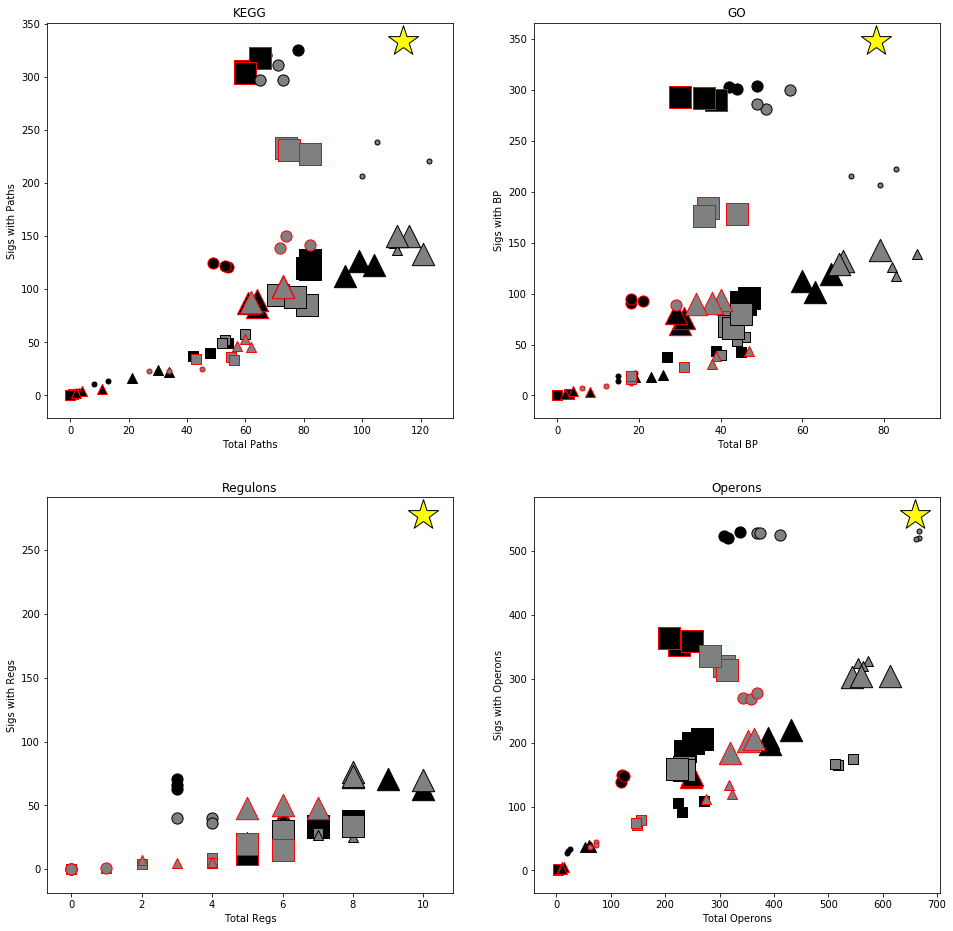

In [303]:
5plimk=10
plimg=10
plimr=10
plimo=10
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                   
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                    y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'



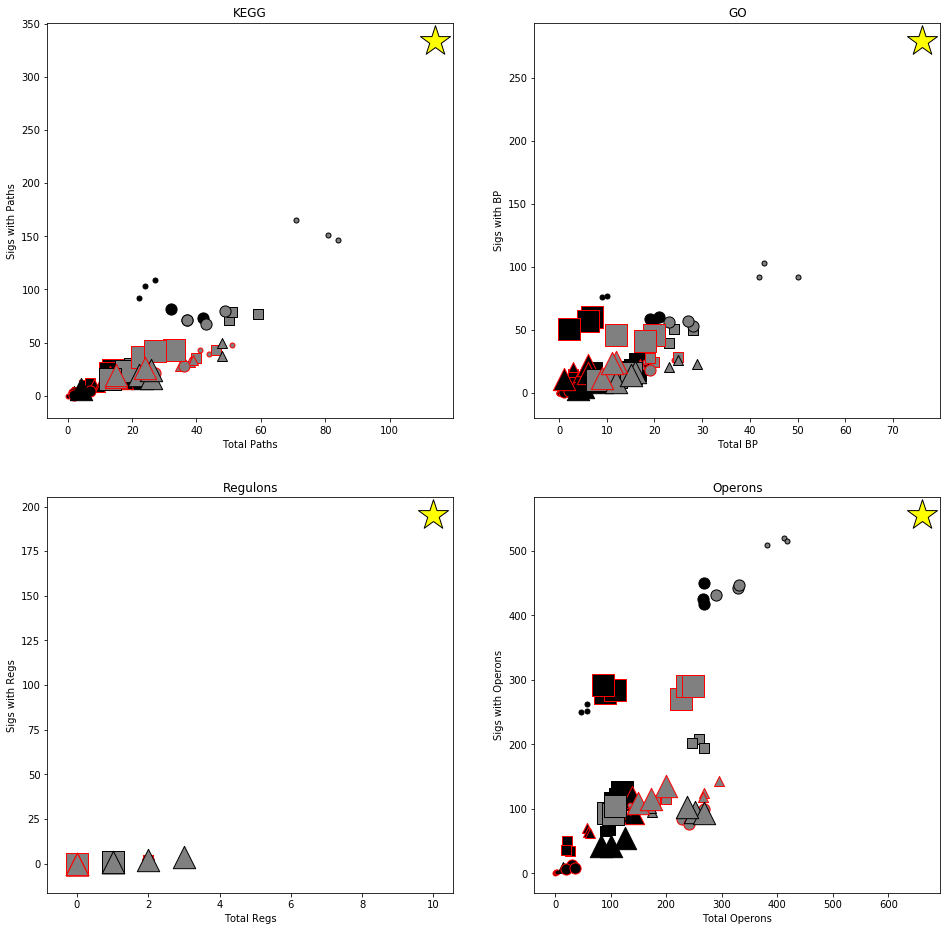

In [207]:
plimk=10
plimg=10
plimr=10
plimo=10
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+460)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                    y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'



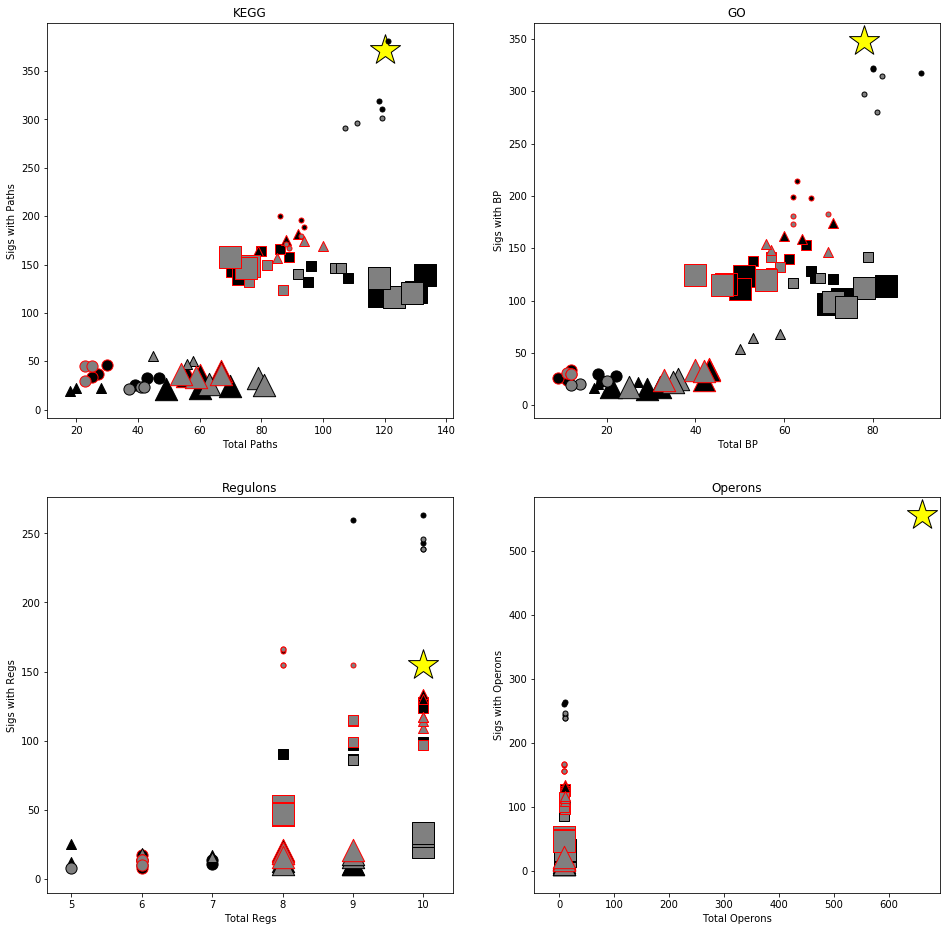

In [532]:
plimk=10
plimg=10
plimr=10
plimo=10
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+560)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict2[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                   # x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                   # y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'



In [526]:
fig.savefig('array_enrichments.png')

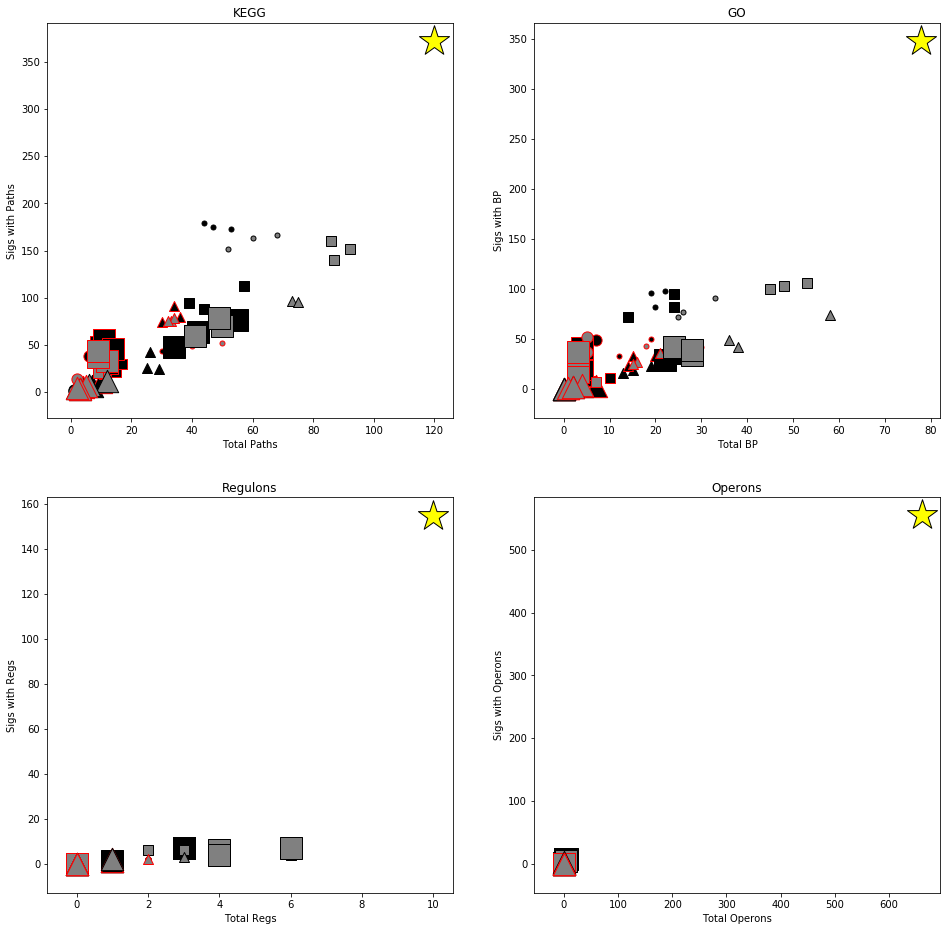

In [527]:
plimk=10
plimg=10
plimr=10
plimo=10
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+560)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq2[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                   # x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                   # y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'



In [1]:
model_dict_seq3

NameError: name 'model_dict_seq3' is not defined

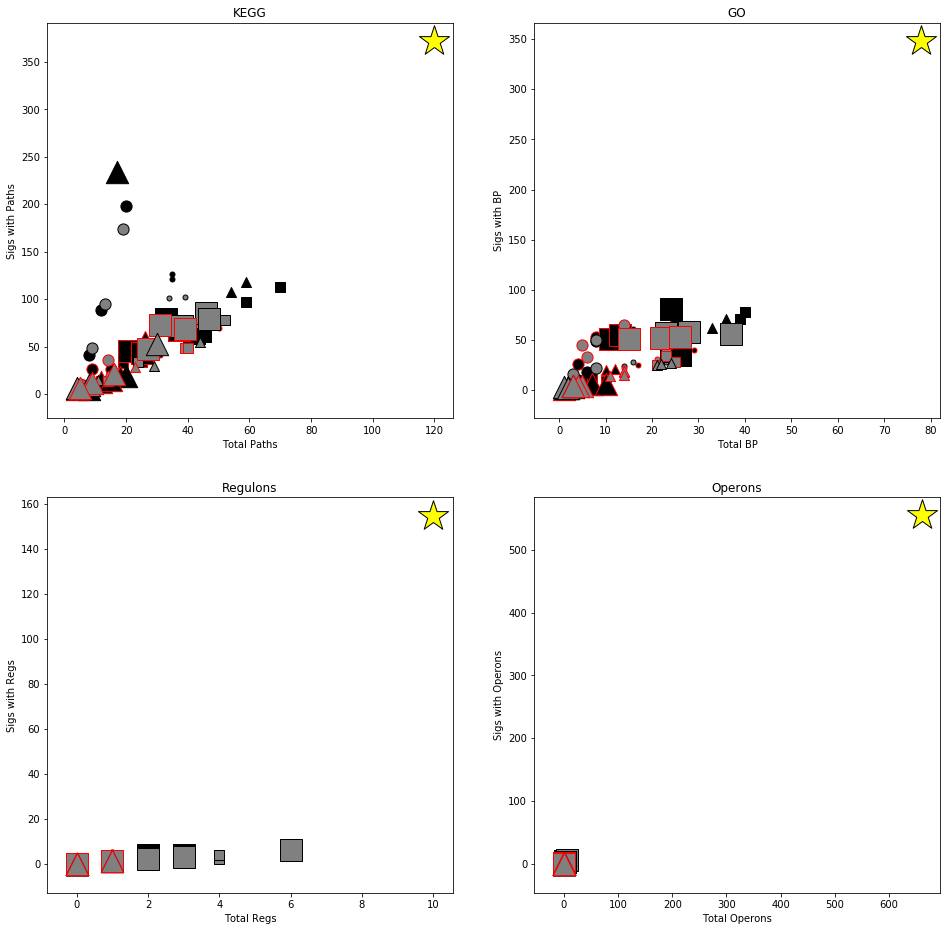

In [533]:
plimk=10
plimg=10
plimr=10
plimo=10
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+560)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq3[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                   # x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                   # y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'



In [529]:
fig.savefig('seq_enrichments.png')

In [280]:
for m in model_dict_seq3:
    model_dict_seq3[m].set_hwg_cutoff(2.0)
    #model_dict_seq[m].set_op('node_interpretation/operons_format.txt')
    #print('op done')
    model_dict_seq3[m].set_kegg('node_interpretation/pseudomonas_KEGG_terms.txt') 
    #print('kegg done')
    model_dict_seq3[m].set_go('node_interpretation/manual_GO_BP_terms.txt') 
    #print('go done')
    model_dict_seq3[m].set_reg('node_interpretation/regulons_format.txt')
    #print('reg done')
    print(m)
print('dict seq done') 

plimk=10
plimg=10
plimr=10
plimo=10
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict_seq3['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict_seq3['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict_seq3['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict_seq3['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict_seq3['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict_seq3['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

#x = ((model_dict['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
#y = ((model_dict['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
#ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'black'
ec = 'black'
ms = ['.','s', '^','h']
mi=0
s=100
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            ec = 'black'
            for t in tied:
                for se in range(3):
                    seed = str(se+560)
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) + seed
                    #print(name)
                    model_temp = model_dict_seq3[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)
                    
                   # x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                   # y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec, s=s)

                ec='red'
            mi = mi+1
        s=500
    c = 'grey'


False

## WRITE OUT GENE LISTS

In [443]:
model_dict3

{'tf_adage': <Adage.Adage at 0x7f6bffe070d0>,
 'ad_glorot_uniform_0_sigmoid_tiedTrue560': <Adage.Adage at 0x7f6b8487a310>,
 'ad_glorot_uniform_0_sigmoid_tiedTrue561': <Adage.Adage at 0x7f6c08843ed0>,
 'ad_glorot_uniform_0_sigmoid_tiedTrue562': <Adage.Adage at 0x7f6ba71e2150>,
 'ad_glorot_uniform_0_sigmoid_tiedFalse560': <Adage.Adage at 0x7f6c03ac6050>,
 'ad_glorot_uniform_0_sigmoid_tiedFalse561': <Adage.Adage at 0x7f6bfeb80850>,
 'ad_glorot_uniform_0_sigmoid_tiedFalse562': <Adage.Adage at 0x7f6b849ae650>,
 'ad_glorot_uniform_0_tanh_tiedTrue560': <Adage.Adage at 0x7f6b849ae6d0>,
 'ad_glorot_uniform_0_tanh_tiedTrue561': <Adage.Adage at 0x7f6b84861f50>,
 'ad_glorot_uniform_0_tanh_tiedTrue562': <Adage.Adage at 0x7f6b84813d10>,
 'ad_glorot_uniform_0_tanh_tiedFalse560': <Adage.Adage at 0x7f6b849c2890>,
 'ad_glorot_uniform_0_tanh_tiedFalse561': <Adage.Adage at 0x7f6bb8a7db90>,
 'ad_glorot_uniform_0_tanh_tiedFalse562': <Adage.Adage at 0x7f6b85252690>,
 'ad_glorot_uniform_0_relu_tiedTrue560': <

In [563]:
name = 'ad_glorot_normal_1e-05_tanh_tiedTrue560'
name = 'ad_glorot_uniform_0_tanh_tiedTrue560'
name = 'ad_glorot_uniform_0_sigmoid_tiedTrue560'
name = 'ad_glorot_normal_1e-05_tanh_tiedTrue560'
model_names = ['tf_adage','ad_glorot_normal_1e-05_tanh_tiedTrue560', 'ad_glorot_uniform_0_tanh_tiedTrue560',
              'ad_glorot_uniform_0_sigmoid_tiedTrue560']
hwgc = 0.0

for m in model_names:
    #model_temp = model_dict_seq3[name]
    model_temp = model_dict3[m]
    model_temp.set_hwg_cutoff(hwgc)
    hw_gene_lists = []
    weight_lists = []
    for n in range(model_temp.hw_genes_all.shape[1]):
        genes_temp = ['node'+str(n)]
        weights_temp = [1]
        for g in range(model_temp.hw_genes_all.shape[0]):
            if(model_temp.hw_genes_all[g,n]):
                #print(g)
                genes_temp.append(model_temp.compendium.index[g])
                weights_temp.append(abs(model_temp.weights[g,n % model_temp.weights.shape[1]]))

        genes_temp_sorted = [x for _,x in sorted(zip(weights_temp, genes_temp), reverse=True)]
        weights_temp_sorted = [x for _,x in sorted(zip(weights_temp, weights_temp), reverse=True)]
        hw_gene_lists.append(genes_temp_sorted)
        weight_lists.append(weights_temp_sorted)
        
    hw_gene_df = pd.DataFrame(hw_gene_lists).fillna('').values  
    hw_weight_df = pd.DataFrame(weight_lists).fillna(0).values  
    #hw_gene_lists[1]
    #write_data('test_hwgs.csv', hw_gene_lists)
    with open( 'new_models/' + m + "array_hwgs_" + str(hwgc) + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(hw_gene_df)
    with open(  'new_models/' + m + "array_hwg_weights_" + str(hwgc) + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(hw_weight_df)
        
    with open(  'new_models/' + m + "array_weights.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(model_temp.weights)
        
        
for m in model_names:
    #model_temp = model_dict_seq3[name]
    model_temp = model_dict_seq3[m]
    model_temp.set_hwg_cutoff(hwgc)
    hw_gene_lists = []
    weight_lists = []
    for n in range(model_temp.hw_genes_all.shape[1]):
        genes_temp = ['node'+str(n)]
        weights_temp = [1]
        for g in range(model_temp.hw_genes_all.shape[0]):
            if(model_temp.hw_genes_all[g,n]):
                #print(g)
                genes_temp.append(model_temp.compendium.index[g])
                weights_temp.append(abs(model_temp.weights[g,n % model_temp.weights.shape[1]]))

        genes_temp_sorted = [x for _,x in sorted(zip(weights_temp, genes_temp), reverse=True)]
        weights_temp_sorted = [x for _,x in sorted(zip(weights_temp, weights_temp), reverse=True)]
        hw_gene_lists.append(genes_temp_sorted)
        weight_lists.append(weights_temp_sorted)
        
    hw_gene_df = pd.DataFrame(hw_gene_lists).fillna('').values  
    hw_weight_df = pd.DataFrame(weight_lists).fillna(0).values 
    #hw_gene_lists[1]
    #write_data('test_hwgs.csv', hw_gene_lists)
    with open(  'new_models/' + m + "seq_hwgs_" + str(hwgc) + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(hw_gene_df)
    with open(  'new_models/' + m + "seq_hwg_weights_" + str(hwgc) + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(hw_weight_df)
        
    with open(  'new_models/' + m + "seq_weights.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(model_temp.weights)

## write out enrichments

In [497]:
model_temp.kegg_ps

[]

In [519]:
name = 'tf_adage'
#name = 'ad_glorot_uniform_0_tanh_tiedTrue560'
model_dict_seq3[name].set_reg('node_interpretation/regulons_format.txt') 

0    Anr_regulon  PhoB_regulon  PvdR_regulon  PchR_regulon  AlgU_regulon  \
0       3.515272      0.777285      6.718862      3.111741      0.506846   
1       1.310983      0.682734      2.831144      2.981172      1.290197   
2       2.198471      1.462515      3.794460      3.947171      1.120229   
3       1.929693      3.098536      3.510287      3.662458      0.893108   
4       2.584913      4.466859      4.196414      4.349664      1.463733   
..           ...           ...           ...           ...           ...   
595    12.675450      3.648236      3.794460      3.947171      2.917954   
596     2.010416      3.262092      3.596129      3.748480      0.960088   
597     0.978063      0.427115      2.439636      2.587536      0.773726   
598     1.513812      2.276593      3.058929      3.209848      1.635339   
599    10.600472      0.579607      2.681651      2.830968      0.345512   

0    LasR_regulon  RhlR_regulon  PqsR_regulon  QscR_regulon  VreI_regulon  
0        0.680917      0.978198      0.916936      5.784154      2.227616  
1        1.678492      0.875319      0.816353      1.372065      2.101811  
2        1.344428      1.699294      1.628226      0.703815      3.043832  
3       13.889035      3.582050      8.913920     15.062785      2.763947  
4        7.329671      2.072309      1.998633      5.030659      3.441481  
..            ...           ...           ...           ...           ...  
595      1.344428      1.699294      6.890549      0.703815      3.043832  
596      5.341711      1.520056      1.450692      3.194471      2.848361  
597      1.096440      1.664003      1.545833      5.601526      1.727069  
598      8.129610      1.057647      0.994820      0.894500      2.322539  
599      0.494487      3.761317      3.558405      0.126863      1.957933  

[600 rows x 10 columns]

In [520]:

name = 'ad_glorot_normal_1e-05_tanh_tiedTrue560'
name = 'ad_glorot_uniform_0_tanh_tiedTrue560'
name = 'ad_glorot_uniform_0_sigmoid_tiedTrue560'
name = 'ad_glorot_normal_1e-05_tanh_tiedTrue560'
name = 'tf_adage'
model_temp = model_dict_seq3[name]
#model_temp = model_dict3[name]

node_paths_list=[]
for n in range(model_temp.hw_genes_all.shape[1]):
    paths_temp = ['node'+str(n)]
    for k in range(model_temp.regs_ps.shape[1]):
        if(model_temp.regs_ps.loc[n][k] > -np.log(0.01)):
            paths_temp.append(model_temp.regs_ps.columns[k])
    node_paths_list.append(paths_temp)
node_paths_list

with open("jie_adage_regs.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(node_paths_list)